In [1]:
import os
import sys
import csv
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import glob
import math
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras import models
from sklearn.svm import OneClassSVM
from deep_svdd import BaseSVDD
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, AveragePooling2D, UpSampling2D, Conv2D, Conv2DTranspose, MaxPooling2D, Reshape, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.applications.efficientnet import decode_predictions
from efficientnet.tfkeras import EfficientNetB2, preprocess_input
import MVTecAD_loaddata as mv
import pandas as pd
acc = []

In [3]:
X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
x_train, x_test = train_test_split(X_train, test_size=0.9)

In [4]:
model = Sequential()
model.add(layers.Conv2D(32, kernel_size=(5, 5), activation='tanh', padding='same',input_shape=(256,256,3), strides=(2,2)))
model.add(layers.AveragePooling2D(pool_size=(2, 2), padding='same'))

model.add(layers.Conv2D(64, kernel_size=(5, 5),activation='tanh',padding='same', strides=(2,2)))
model.add(layers.AveragePooling2D(pool_size=(2, 2), padding='same'))

model.add(layers.Conv2D(128, kernel_size=(5, 5),activation='tanh',padding='same', strides=(2,2)))
model.add(layers.AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='tanh'))

model.add(layers.Dense(4*4*128,activation='tanh'))
model.add(layers.Reshape((4,4,128)))
model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5),activation='tanh', padding='same', strides=(2,2)))
model.add(layers.UpSampling2D(size=(2, 2)))

model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5),activation='tanh', padding='same', strides=(2,2)))
model.add(layers.UpSampling2D(size=(2, 2)))

model.add(layers.Conv2DTranspose(32, kernel_size=(5, 5),activation='tanh', padding='same', strides=(2,2)))
model.add(layers.UpSampling2D(size=(2, 2)))

model.add(layers.Conv2D(3, kernel_size=(5, 5),activation='tanh', padding='same'))
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(X_train, X_train,epochs=50,batch_size=16,shuffle=True,validation_data=(x_test, x_test))

Epoch 1/50
Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 8.6385 - accuracy: 0.3208

KeyboardInterrupt: 

KeyboardInterrupt: 

In [ ]:
encoder = models.clone_model(model)
encoder.compile(optimizer='adam',loss='binary_crossentropy')
encoder.set_weights(model.get_weights())
for i in range(9):
    encoder.pop()
x_tr = encoder.predict(X_train,verbose=0)
x_tg = encoder.predict(X_test_good,verbose=0)
x_te = encoder.predict(X_test_error,verbose=0)
x_ts = encoder.predict(X_test,verbose=0)

#     x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
#     x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
#     x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
#     x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

svdd = BaseSVDD(C=2**(-4), gamma=10**(-4), kernel='rbf', display='on')
svdd.fit(x_tr)
svdd.predict(x_tg, y_tg)
svdd.predict(x_te, y_te)
svdd.predict(x_ts, y_ts)
radius = svdd.radius
distance = svdd.get_distance(x_ts)
svdd.plot_distance(radius, distance)
alphas = svdd.alpha
Param = svdd.C
acc.append(svdd.accuracy)

In [2]:
%%time
for num in range(5):
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
    
    model = Sequential()
    model.add(layers.Conv2D(32, kernel_size=(5, 5), activation='tanh', padding='same',input_shape=(256,256,3), strides=(2,2)))
    model.add(layers.AveragePooling2D(pool_size=(2, 2), padding='same'))

    model.add(layers.Conv2D(64, kernel_size=(5, 5),activation='tanh',padding='same', strides=(2,2)))
    model.add(layers.AveragePooling2D(pool_size=(2, 2), padding='same'))

    model.add(layers.Conv2D(128, kernel_size=(5, 5),activation='tanh',padding='same', strides=(2,2)))
    model.add(layers.AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation='tanh'))

    model.add(layers.Dense(4*4*128,activation='tanh'))
    model.add(layers.Reshape((4,4,128)))
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5),activation='tanh', padding='same', strides=(2,2)))
    model.add(layers.UpSampling2D(size=(2, 2)))

    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5),activation='tanh', padding='same', strides=(2,2)))
    model.add(layers.UpSampling2D(size=(2, 2)))

    model.add(layers.Conv2DTranspose(32, kernel_size=(5, 5),activation='tanh', padding='same', strides=(2,2)))
    model.add(layers.UpSampling2D(size=(2, 2)))

    model.add(layers.Conv2D(3, kernel_size=(5, 5),activation='tanh', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(X_train, X_train,epochs=50,batch_size=16,shuffle=True,validation_data=(x_test, x_test))

    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(9):
        encoder.pop()
    x_tr = encoder.predict(X_train,verbose=0)
    x_tg = encoder.predict(X_test_good,verbose=0)
    x_te = encoder.predict(X_test_error,verbose=0)
    x_ts = encoder.predict(X_test,verbose=0)

#     x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
#     x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
#     x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
#     x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-4), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    acc.append(svdd.accuracy)

Epoch 1/50
Epoch 1/50
14/14 [==============================] - 45s 3s/step - loss: 8.7156 - accuracy: 0.3629 - val_loss: 8.4009 - val_accuracy: 0.3579
Epoch 2/50
Epoch 2/50
14/14 [==============================] - 44s 3s/step - loss: 8.2345 - accuracy: 0.3513 - val_loss: 8.0162 - val_accuracy: 0.3494
Epoch 3/50
Epoch 3/50
14/14 [==============================] - 48s 3s/step - loss: 7.7858 - accuracy: 0.3551 - val_loss: 7.4275 - val_accuracy: 0.3624
Epoch 4/50
Epoch 4/50
14/14 [==============================] - 46s 3s/step - loss: 7.0910 - accuracy: 0.3657 - val_loss: 6.4998 - val_accuracy: 0.3745
Epoch 5/50
Epoch 5/50
 8/14 [================>.............] - ETA: 19s - loss: 6.1282 - accuracy: 0.3769

KeyboardInterrupt: 

KeyboardInterrupt: 

Epoch 1/15
Epoch 1/15
14/14 [==============================] - 55s 4s/step - loss: 1.3890 - accuracy: 0.0873 - val_loss: 1.3273 - val_accuracy: 0.0909
Epoch 2/15
Epoch 2/15
14/14 [==============================] - 55s 4s/step - loss: 1.3186 - accuracy: 0.6098 - val_loss: 1.3161 - val_accuracy: 0.8160
Epoch 3/15
Epoch 3/15
14/14 [==============================] - 54s 4s/step - loss: 1.3167 - accuracy: 0.8157 - val_loss: 1.3159 - val_accuracy: 0.8160
Epoch 4/15
14/14 [==============================] - 54s 4s/step - loss: 1.3167 - accuracy: 0.8157 - val_loss: 1.3159 - val_accuracy: 0.8160
Epoch 4/15
14/14 [==============================] - 54s 4s/step - loss: 1.3162 - accuracy: 0.8157 - val_loss: 1.3158 - val_accuracy: 0.8160
Epoch 5/15
14/14 [==============================] - 54s 4s/step - loss: 1.3162 - accuracy: 0.8157 - val_loss: 1.3158 - val_accuracy: 0.8160
Epoch 5/15
14/14 [==============================] - 54s 4s/step - loss: 1.3168 - accuracy: 0.8157 - val_loss: 1.3171 - val_accu

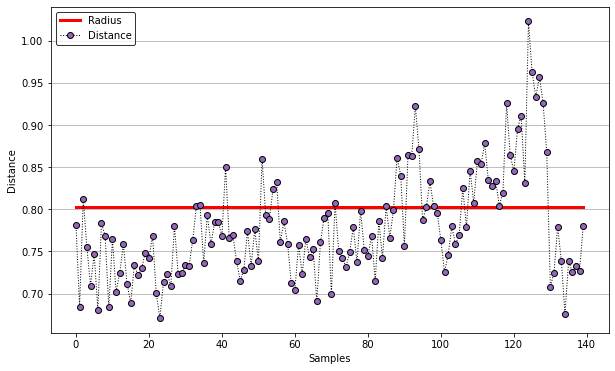

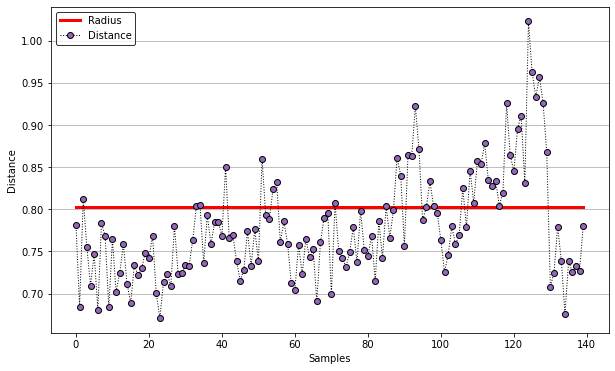

Epoch 1/15
Epoch 1/15
14/14 [==============================] - 55s 4s/step - loss: 1.3216 - accuracy: 0.8158 - val_loss: 1.3217 - val_accuracy: 0.8154
Epoch 2/15
14/14 [==============================] - 55s 4s/step - loss: 1.3216 - accuracy: 0.8158 - val_loss: 1.3217 - val_accuracy: 0.8154
Epoch 2/15
14/14 [==============================] - 54s 4s/step - loss: 1.3212 - accuracy: 0.8158 - val_loss: 1.3212 - val_accuracy: 0.8154
Epoch 3/15
14/14 [==============================] - 54s 4s/step - loss: 1.3212 - accuracy: 0.8158 - val_loss: 1.3212 - val_accuracy: 0.8154
Epoch 3/15
14/14 [==============================] - 55s 4s/step - loss: 1.3206 - accuracy: 0.8158 - val_loss: 1.3206 - val_accuracy: 0.8154
Epoch 4/15
14/14 [==============================] - 55s 4s/step - loss: 1.3206 - accuracy: 0.8158 - val_loss: 1.3206 - val_accuracy: 0.8154
Epoch 4/15
14/14 [==============================] - 54s 4s/step - loss: 1.3198 - accuracy: 0.8158 - val_loss: 1.3195 - val_accuracy: 0.8154
Epoch 5/1

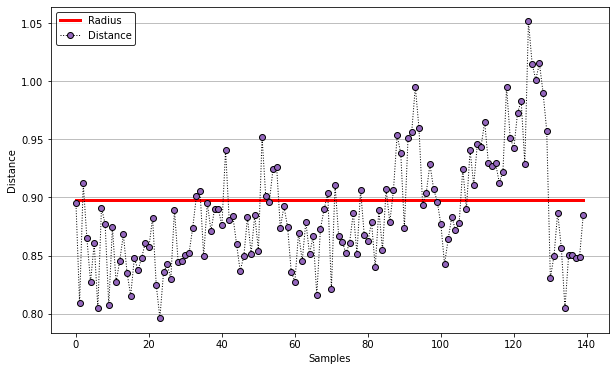

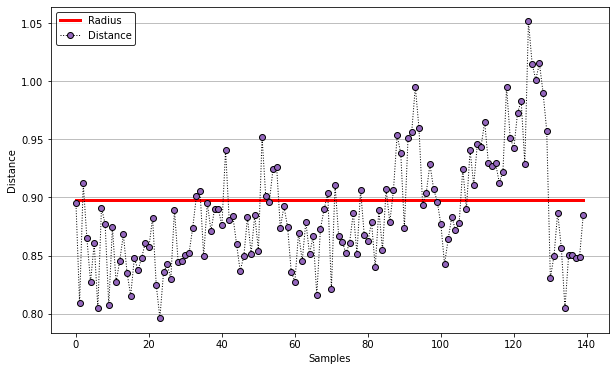

Epoch 1/15
Epoch 1/15
14/14 [==============================] - 56s 4s/step - loss: 1.3203 - accuracy: 0.7601 - val_loss: 1.3152 - val_accuracy: 0.8117
Epoch 2/15
14/14 [==============================] - 56s 4s/step - loss: 1.3203 - accuracy: 0.7601 - val_loss: 1.3152 - val_accuracy: 0.8117
Epoch 2/15
14/14 [==============================] - 54s 4s/step - loss: 1.3170 - accuracy: 0.8119 - val_loss: 1.3152 - val_accuracy: 0.8117
Epoch 3/15
Epoch 3/15
14/14 [==============================] - 54s 4s/step - loss: 1.3170 - accuracy: 0.8119 - val_loss: 1.3152 - val_accuracy: 0.8117
Epoch 4/15
14/14 [==============================] - 54s 4s/step - loss: 1.3170 - accuracy: 0.8119 - val_loss: 1.3152 - val_accuracy: 0.8117
Epoch 4/15
14/14 [==============================] - 54s 4s/step - loss: 1.3174 - accuracy: 0.8117 - val_loss: 1.3162 - val_accuracy: 0.8099
Epoch 5/15
14/14 [==============================] - 54s 4s/step - loss: 1.3174 - accuracy: 0.8117 - val_loss: 1.3162 - val_accuracy: 0.809

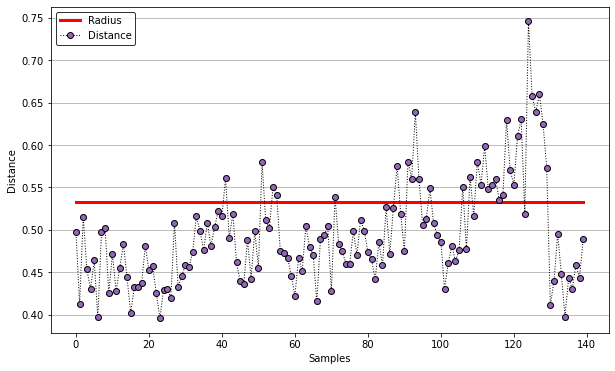

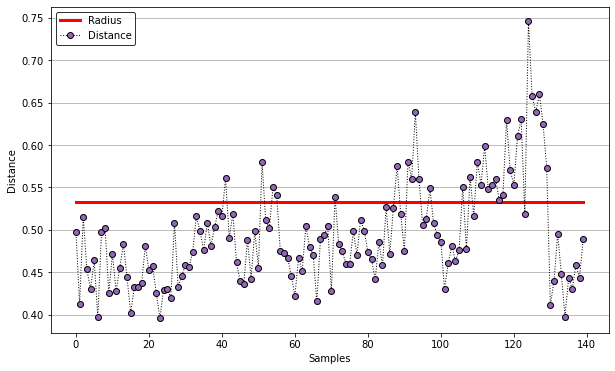

Epoch 1/15
Epoch 1/15
14/14 [==============================] - 55s 4s/step - loss: 1.5605 - accuracy: 0.0829 - val_loss: 1.4307 - val_accuracy: 0.0832
Epoch 2/15
14/14 [==============================] - 55s 4s/step - loss: 1.5605 - accuracy: 0.0829 - val_loss: 1.4307 - val_accuracy: 0.0832
Epoch 2/15
14/14 [==============================] - 54s 4s/step - loss: 1.3764 - accuracy: 0.0837 - val_loss: 1.3392 - val_accuracy: 0.0871
Epoch 3/15
14/14 [==============================] - 54s 4s/step - loss: 1.3764 - accuracy: 0.0837 - val_loss: 1.3392 - val_accuracy: 0.0871
Epoch 3/15
14/14 [==============================] - 54s 4s/step - loss: 1.3281 - accuracy: 0.3044 - val_loss: 1.3211 - val_accuracy: 0.7981
Epoch 4/15
14/14 [==============================] - 54s 4s/step - loss: 1.3281 - accuracy: 0.3044 - val_loss: 1.3211 - val_accuracy: 0.7981
Epoch 4/15
14/14 [==============================] - 54s 4s/step - loss: 1.3189 - accuracy: 0.8070 - val_loss: 1.3189 - val_accuracy: 0.8079
Epoch 5/1

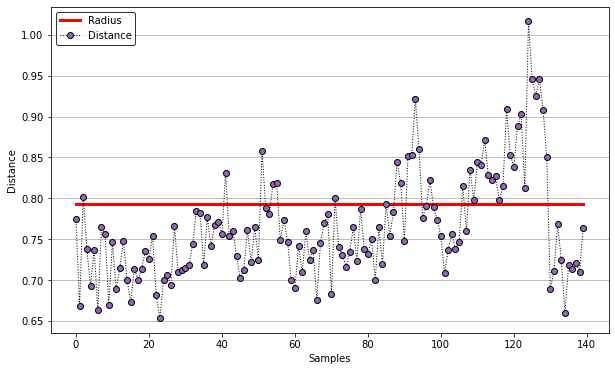

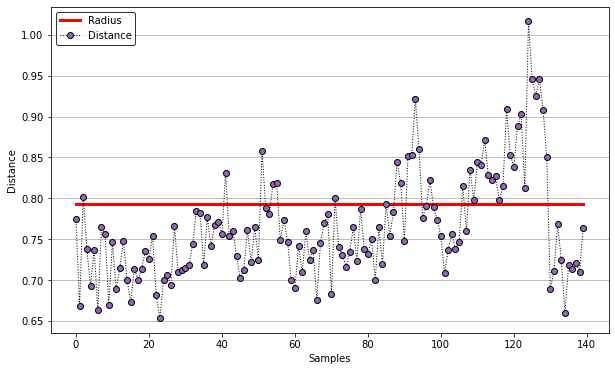

Epoch 1/15
Epoch 1/15
14/14 [==============================] - 56s 4s/step - loss: 1.4243 - accuracy: 0.0902 - val_loss: 1.3703 - val_accuracy: 0.0865
Epoch 2/15
14/14 [==============================] - 56s 4s/step - loss: 1.4243 - accuracy: 0.0902 - val_loss: 1.3703 - val_accuracy: 0.0865
Epoch 2/15
14/14 [==============================] - 54s 4s/step - loss: 1.3407 - accuracy: 0.0868 - val_loss: 1.3261 - val_accuracy: 0.0866
Epoch 3/15
14/14 [==============================] - 54s 4s/step - loss: 1.3407 - accuracy: 0.0868 - val_loss: 1.3261 - val_accuracy: 0.0866
Epoch 3/15
14/14 [==============================] - 53s 4s/step - loss: 1.3214 - accuracy: 0.0867 - val_loss: 1.3239 - val_accuracy: 0.0866
Epoch 4/15
Epoch 4/15
14/14 [==============================] - 54s 4s/step - loss: 1.3209 - accuracy: 0.1574 - val_loss: 1.3229 - val_accuracy: 0.2982
Epoch 5/15
14/14 [==============================] - 54s 4s/step - loss: 1.3209 - accuracy: 0.1574 - val_loss: 1.3229 - val_accuracy: 0.298

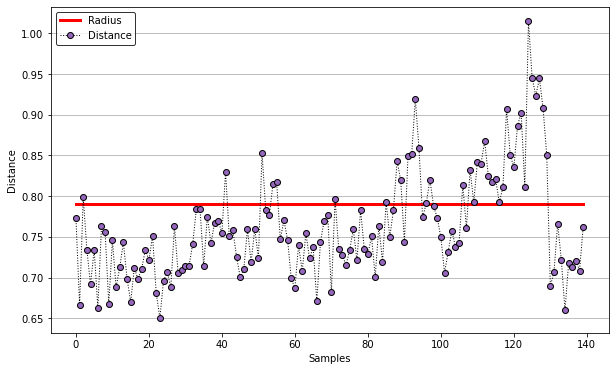

Wall time: 1h 8min 57s


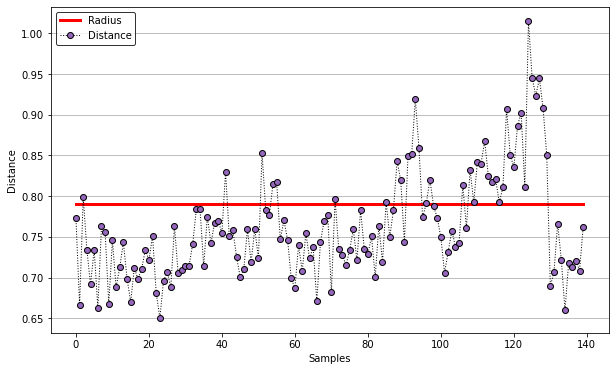

Wall time: 1h 8min 57s


In [3]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
    
    input_shape = (256,256, 3)
    model = Sequential()
    model.add(layers.Conv2D(32, kernel_size=(5, 5), activation='tanh', padding='same',input_shape=(256,256,3), strides=(2,2)))
    model.add(layers.AveragePooling2D(pool_size=(2, 2), padding='same'))

    model.add(layers.Conv2D(64, kernel_size=(5, 5),activation='tanh',padding='same', strides=(2,2)))
    model.add(layers.AveragePooling2D(pool_size=(2, 2), padding='same'))

    model.add(layers.Conv2D(128, kernel_size=(5, 5),activation='tanh',padding='same', strides=(2,2)))
    model.add(layers.AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation='tanh'))

    model.add(layers.Dense(4*4*128,activation='tanh'))
    model.add(layers.Reshape((4,4,128)))
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5),activation='tanh', padding='same', strides=(2,2)))
    model.add(layers.UpSampling2D(size=(2, 2)))

    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5),activation='tanh', padding='same', strides=(2,2)))
    model.add(layers.UpSampling2D(size=(2, 2)))

    model.add(layers.Conv2DTranspose(32, kernel_size=(5, 5),activation='tanh', padding='same', strides=(2,2)))
    model.add(layers.UpSampling2D(size=(2, 2)))

    model.add(layers.Conv2D(3, kernel_size=(5, 5),activation='tanh', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(X_train, X_train,epochs=50,batch_size=16,shuffle=True,validation_data=(x_test, x_test))

    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(9):
        encoder.pop()
    x_tr = encoder.predict(X_train,verbose=0)
    x_tg = encoder.predict(X_test_good,verbose=0)
    x_te = encoder.predict(X_test_error,verbose=0)
    x_ts = encoder.predict(X_test,verbose=0)

#     x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
#     x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
#     x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
#     x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-4), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    acc.append(svdd.accuracy)

Epoch 1/15
Epoch 1/15
14/14 [==============================] - 54s 4s/step - loss: 2.4964 - accuracy: 0.2328 - val_loss: 2.4895 - val_accuracy: 0.2328
Epoch 2/15
14/14 [==============================] - 54s 4s/step - loss: 2.4964 - accuracy: 0.2328 - val_loss: 2.4895 - val_accuracy: 0.2328
Epoch 2/15
14/14 [==============================] - 53s 4s/step - loss: 2.4830 - accuracy: 0.2328 - val_loss: 2.4713 - val_accuracy: 0.2328
Epoch 3/15
14/14 [==============================] - 53s 4s/step - loss: 2.4830 - accuracy: 0.2328 - val_loss: 2.4713 - val_accuracy: 0.2328
Epoch 3/15
14/14 [==============================] - 54s 4s/step - loss: 2.4600 - accuracy: 0.2328 - val_loss: 2.4395 - val_accuracy: 0.2328
Epoch 4/15
14/14 [==============================] - 54s 4s/step - loss: 2.4600 - accuracy: 0.2328 - val_loss: 2.4395 - val_accuracy: 0.2328
Epoch 4/15
14/14 [==============================] - 53s 4s/step - loss: 2.4180 - accuracy: 0.2328 - val_loss: 2.3856 - val_accuracy: 0.2328
Epoch 5/1

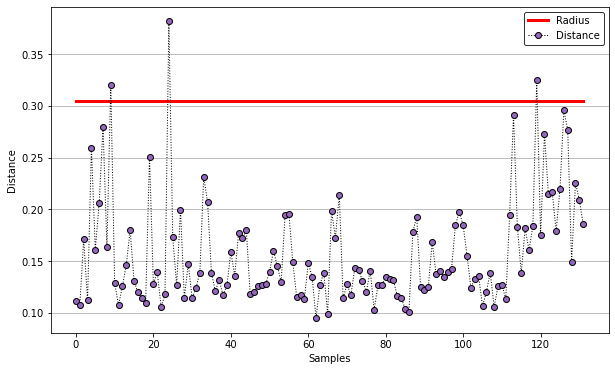

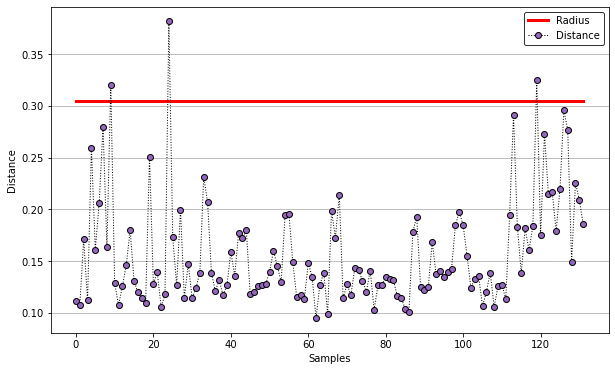

Epoch 1/15
Epoch 1/15
14/14 [==============================] - 53s 4s/step - loss: 2.3192 - accuracy: 0.5808 - val_loss: 2.3156 - val_accuracy: 0.5819
Epoch 2/15
Epoch 2/15
14/14 [==============================] - 54s 4s/step - loss: 2.3109 - accuracy: 0.5808 - val_loss: 2.3042 - val_accuracy: 0.5819
Epoch 3/15
14/14 [==============================] - 54s 4s/step - loss: 2.3109 - accuracy: 0.5808 - val_loss: 2.3042 - val_accuracy: 0.5819
Epoch 3/15
14/14 [==============================] - 53s 4s/step - loss: 2.2967 - accuracy: 0.5808 - val_loss: 2.2849 - val_accuracy: 0.5819
Epoch 4/15
14/14 [==============================] - 53s 4s/step - loss: 2.2967 - accuracy: 0.5808 - val_loss: 2.2849 - val_accuracy: 0.5819
Epoch 4/15
14/14 [==============================] - 53s 4s/step - loss: 2.2723 - accuracy: 0.5808 - val_loss: 2.2562 - val_accuracy: 0.5819
Epoch 5/15
Epoch 5/15
14/14 [==============================] - 54s 4s/step - loss: 2.2462 - accuracy: 0.5808 - val_loss: 2.2384 - val_accu

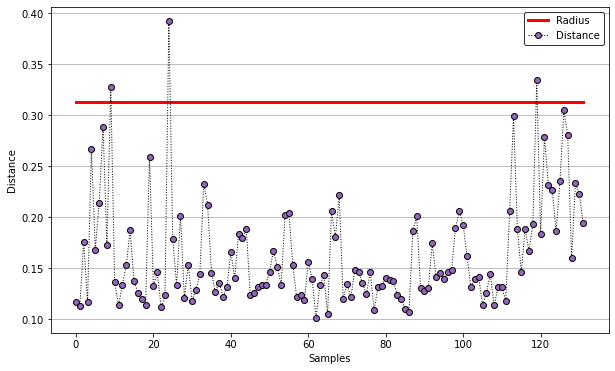

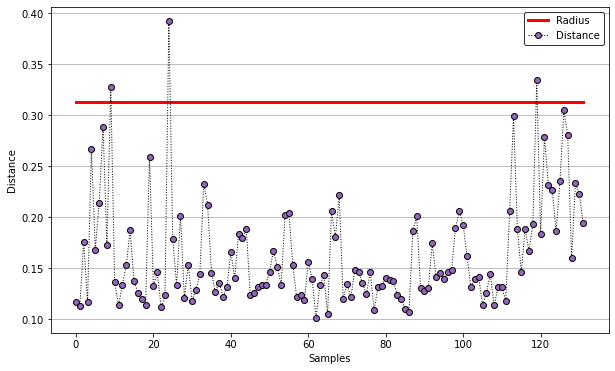

Epoch 1/15
Epoch 1/15
14/14 [==============================] - 54s 4s/step - loss: 2.2769 - accuracy: 0.2305 - val_loss: 2.2777 - val_accuracy: 0.2294
Epoch 2/15
14/14 [==============================] - 54s 4s/step - loss: 2.2769 - accuracy: 0.2305 - val_loss: 2.2777 - val_accuracy: 0.2294
Epoch 2/15
14/14 [==============================] - 52s 4s/step - loss: 2.2779 - accuracy: 0.2305 - val_loss: 2.2790 - val_accuracy: 0.2294
Epoch 3/15
Epoch 3/15
14/14 [==============================] - 53s 4s/step - loss: 2.2792 - accuracy: 0.2305 - val_loss: 2.2803 - val_accuracy: 0.2294
Epoch 4/15
14/14 [==============================] - 53s 4s/step - loss: 2.2792 - accuracy: 0.2305 - val_loss: 2.2803 - val_accuracy: 0.2294
Epoch 4/15
14/14 [==============================] - 52s 4s/step - loss: 2.2798 - accuracy: 0.2305 - val_loss: 2.2793 - val_accuracy: 0.2294
Epoch 5/15
14/14 [==============================] - 52s 4s/step - loss: 2.2798 - accuracy: 0.2305 - val_loss: 2.2793 - val_accuracy: 0.229

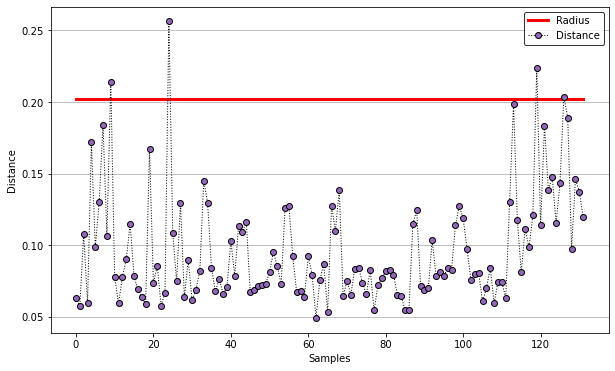

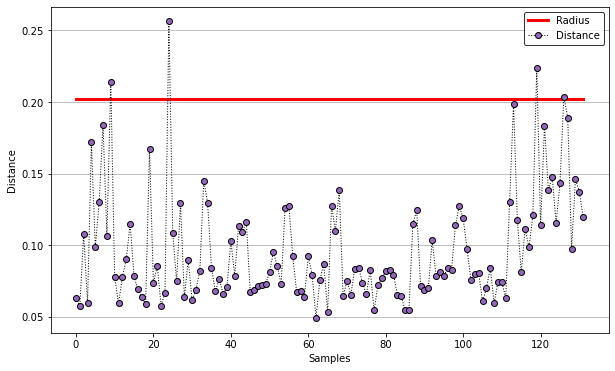

Epoch 1/15
Epoch 1/15
14/14 [==============================] - 53s 4s/step - loss: 2.7024 - accuracy: 0.1873 - val_loss: 2.6967 - val_accuracy: 0.1858
Epoch 2/15
14/14 [==============================] - 53s 4s/step - loss: 2.7024 - accuracy: 0.1873 - val_loss: 2.6967 - val_accuracy: 0.1858
Epoch 2/15
14/14 [==============================] - 53s 4s/step - loss: 2.6847 - accuracy: 0.1873 - val_loss: 2.6701 - val_accuracy: 0.1858
Epoch 3/15
14/14 [==============================] - 53s 4s/step - loss: 2.6847 - accuracy: 0.1873 - val_loss: 2.6701 - val_accuracy: 0.1858
Epoch 3/15
14/14 [==============================] - 53s 4s/step - loss: 2.6439 - accuracy: 0.1873 - val_loss: 2.6092 - val_accuracy: 0.1858
Epoch 4/15
14/14 [==============================] - 53s 4s/step - loss: 2.6439 - accuracy: 0.1873 - val_loss: 2.6092 - val_accuracy: 0.1858
Epoch 4/15
14/14 [==============================] - 53s 4s/step - loss: 2.5621 - accuracy: 0.1873 - val_loss: 2.4985 - val_accuracy: 0.1858
Epoch 5/1

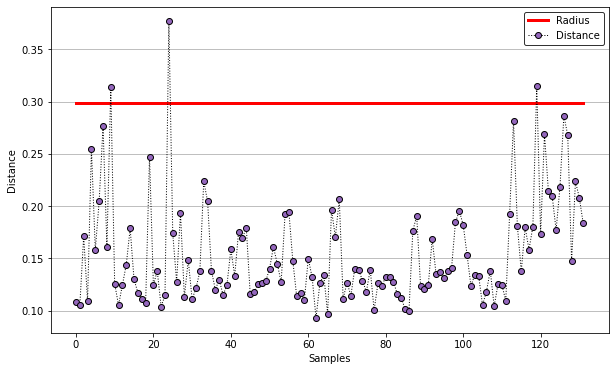

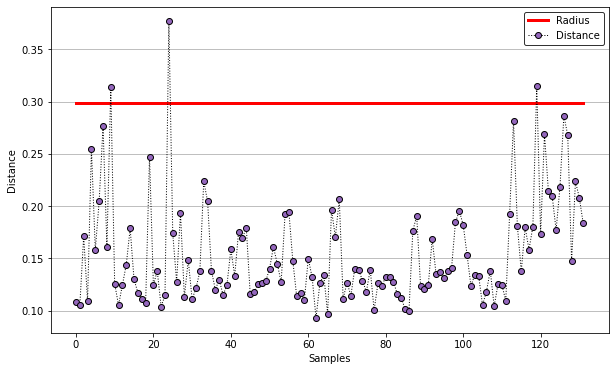

Epoch 1/15
Epoch 1/15
14/14 [==============================] - 53s 4s/step - loss: 2.2445 - accuracy: 0.5798 - val_loss: 2.2447 - val_accuracy: 0.5785
Epoch 2/15
14/14 [==============================] - 53s 4s/step - loss: 2.2445 - accuracy: 0.5798 - val_loss: 2.2447 - val_accuracy: 0.5785
Epoch 2/15
14/14 [==============================] - 53s 4s/step - loss: 2.2433 - accuracy: 0.5798 - val_loss: 2.2422 - val_accuracy: 0.5785
Epoch 3/15
14/14 [==============================] - 53s 4s/step - loss: 2.2433 - accuracy: 0.5798 - val_loss: 2.2422 - val_accuracy: 0.5785
Epoch 3/15
14/14 [==============================] - 53s 4s/step - loss: 2.2395 - accuracy: 0.5798 - val_loss: 2.2368 - val_accuracy: 0.5785
Epoch 4/15
Epoch 4/15
14/14 [==============================] - 53s 4s/step - loss: 2.2324 - accuracy: 0.5798 - val_loss: 2.2275 - val_accuracy: 0.5785
Epoch 5/15
14/14 [==============================] - 53s 4s/step - loss: 2.2324 - accuracy: 0.5798 - val_loss: 2.2275 - val_accuracy: 0.578

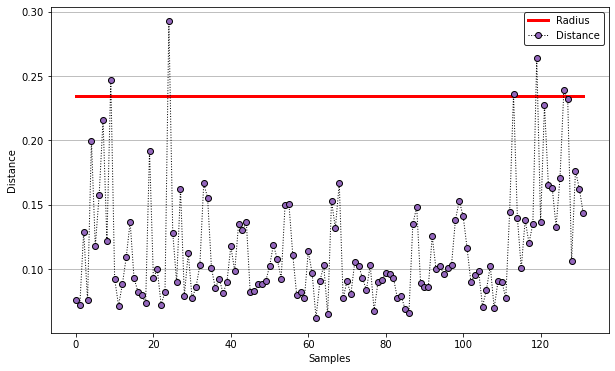

Wall time: 1h 7min 9s


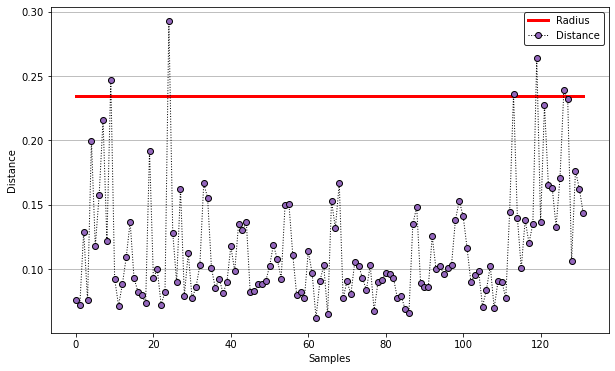

Wall time: 1h 7min 9s


In [4]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
    
    input_shape = (256,256, 3)
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(X_train, X_train,epochs=15,batch_size=16,shuffle=True,validation_data=(x_test, x_test))

    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)

    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-4), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    acc.append(svdd.accuracy)

Epoch 1/15
Epoch 1/15
18/18 [==============================] - 68s 4s/step - loss: 1.2429 - accuracy: 0.3306 - val_loss: 1.1874 - val_accuracy: 0.3322
Epoch 2/15
Epoch 2/15
18/18 [==============================] - 68s 4s/step - loss: 1.1804 - accuracy: 0.2075 - val_loss: 1.1787 - val_accuracy: 0.5734
Epoch 3/15
18/18 [==============================] - 68s 4s/step - loss: 1.1804 - accuracy: 0.2075 - val_loss: 1.1787 - val_accuracy: 0.5734
Epoch 3/15
18/18 [==============================] - 67s 4s/step - loss: 1.1780 - accuracy: 0.5728 - val_loss: 1.1773 - val_accuracy: 0.5461
Epoch 4/15
18/18 [==============================] - 67s 4s/step - loss: 1.1780 - accuracy: 0.5728 - val_loss: 1.1773 - val_accuracy: 0.5461
Epoch 4/15
18/18 [==============================] - 67s 4s/step - loss: 1.1770 - accuracy: 0.5037 - val_loss: 1.1771 - val_accuracy: 0.5264
Epoch 5/15
Epoch 5/15
18/18 [==============================] - 67s 4s/step - loss: 1.1772 - accuracy: 0.5318 - val_loss: 1.1778 - val_accu

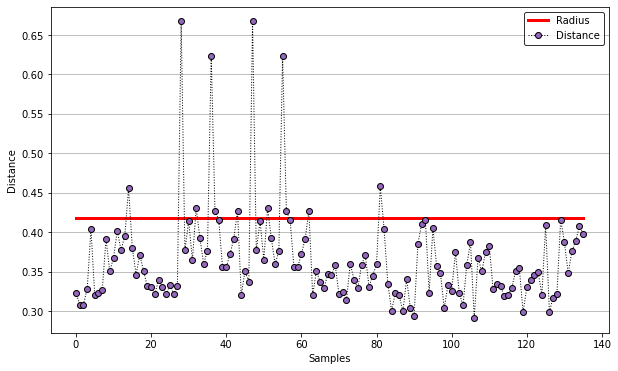

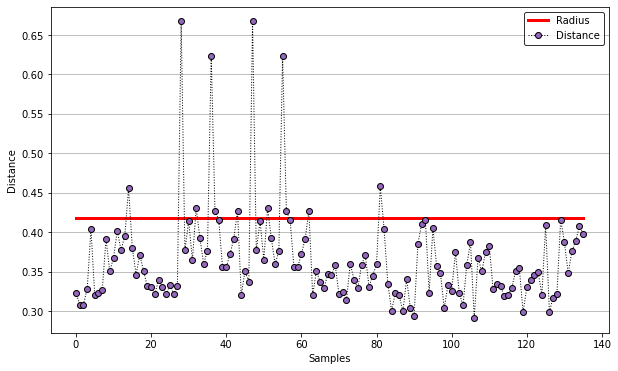

Epoch 1/15
Epoch 1/15
18/18 [==============================] - 69s 4s/step - loss: 1.2204 - accuracy: 0.1547 - val_loss: 1.1817 - val_accuracy: 0.5758
Epoch 2/15
18/18 [==============================] - 69s 4s/step - loss: 1.2204 - accuracy: 0.1547 - val_loss: 1.1817 - val_accuracy: 0.5758
Epoch 2/15
18/18 [==============================] - 67s 4s/step - loss: 1.1802 - accuracy: 0.5388 - val_loss: 1.1803 - val_accuracy: 0.3304
Epoch 3/15
Epoch 3/15
18/18 [==============================] - 67s 4s/step - loss: 1.1783 - accuracy: 0.4628 - val_loss: 1.1788 - val_accuracy: 0.5758
Epoch 4/15
18/18 [==============================] - 67s 4s/step - loss: 1.1783 - accuracy: 0.4628 - val_loss: 1.1788 - val_accuracy: 0.5758
Epoch 4/15
18/18 [==============================] - 67s 4s/step - loss: 1.1779 - accuracy: 0.5748 - val_loss: 1.1789 - val_accuracy: 0.5758
Epoch 5/15
18/18 [==============================] - 67s 4s/step - loss: 1.1779 - accuracy: 0.5748 - val_loss: 1.1789 - val_accuracy: 0.575

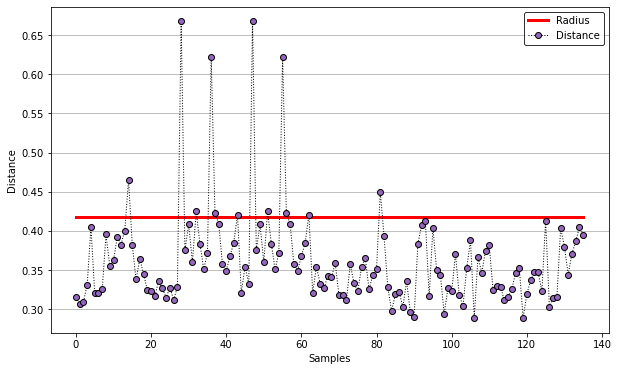

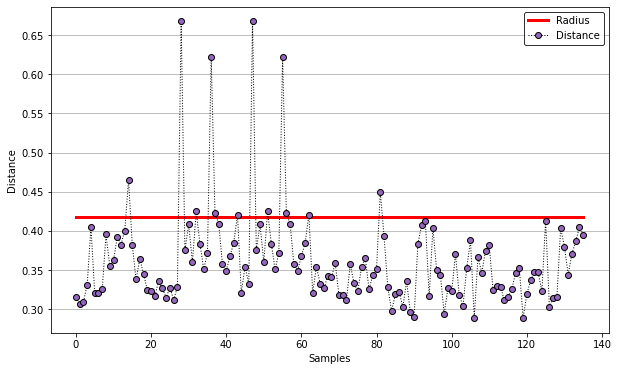

Epoch 1/15
Epoch 1/15
18/18 [==============================] - 69s 4s/step - loss: 1.6340 - accuracy: 0.3304 - val_loss: 1.4515 - val_accuracy: 0.3312
Epoch 2/15
18/18 [==============================] - 69s 4s/step - loss: 1.6340 - accuracy: 0.3304 - val_loss: 1.4515 - val_accuracy: 0.3312
Epoch 2/15
18/18 [==============================] - 68s 4s/step - loss: 1.3552 - accuracy: 0.3291 - val_loss: 1.2586 - val_accuracy: 0.3293
Epoch 3/15
18/18 [==============================] - 68s 4s/step - loss: 1.3552 - accuracy: 0.3291 - val_loss: 1.2586 - val_accuracy: 0.3293
Epoch 3/15
18/18 [==============================] - 67s 4s/step - loss: 1.2084 - accuracy: 0.2921 - val_loss: 1.1774 - val_accuracy: 0.2129
Epoch 4/15
Epoch 4/15
18/18 [==============================] - 67s 4s/step - loss: 1.1786 - accuracy: 0.5353 - val_loss: 1.1780 - val_accuracy: 0.5492
Epoch 5/15
18/18 [==============================] - 67s 4s/step - loss: 1.1786 - accuracy: 0.5353 - val_loss: 1.1780 - val_accuracy: 0.549

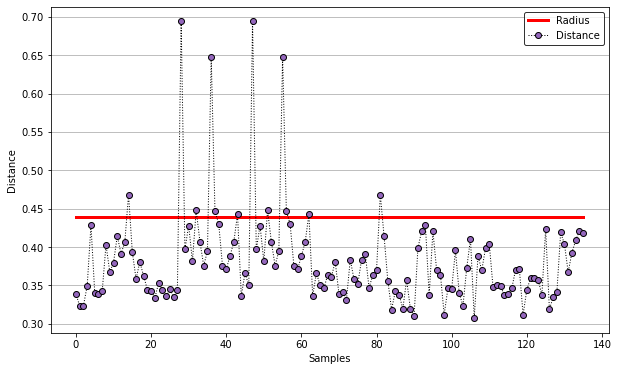

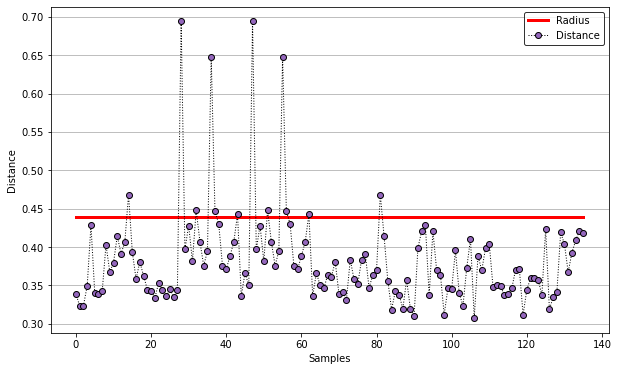

Epoch 1/15
Epoch 1/15
18/18 [==============================] - 68s 4s/step - loss: 1.2414 - accuracy: 0.5755 - val_loss: 1.1853 - val_accuracy: 0.5772
Epoch 2/15
18/18 [==============================] - 68s 4s/step - loss: 1.2414 - accuracy: 0.5755 - val_loss: 1.1853 - val_accuracy: 0.5772
Epoch 2/15
18/18 [==============================] - 68s 4s/step - loss: 1.1790 - accuracy: 0.2283 - val_loss: 1.1775 - val_accuracy: 0.0960
Epoch 3/15
18/18 [==============================] - 68s 4s/step - loss: 1.1790 - accuracy: 0.2283 - val_loss: 1.1775 - val_accuracy: 0.0960
Epoch 3/15
18/18 [==============================] - 67s 4s/step - loss: 1.1776 - accuracy: 0.0966 - val_loss: 1.1765 - val_accuracy: 0.0951
Epoch 4/15
18/18 [==============================] - 67s 4s/step - loss: 1.1776 - accuracy: 0.0966 - val_loss: 1.1765 - val_accuracy: 0.0951
Epoch 4/15
18/18 [==============================] - 67s 4s/step - loss: 1.1771 - accuracy: 0.0965 - val_loss: 1.1764 - val_accuracy: 0.0952
Epoch 5/1

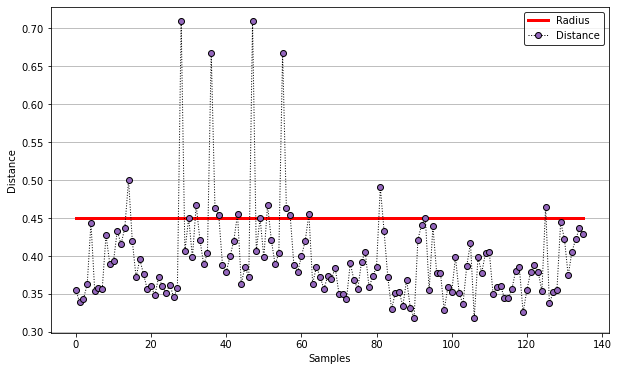

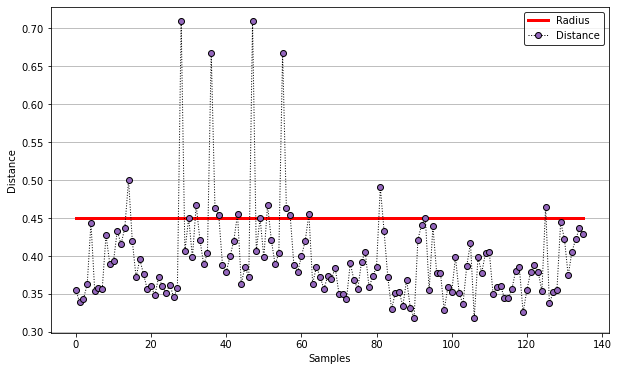

Epoch 1/15
Epoch 1/15
18/18 [==============================] - 68s 4s/step - loss: 1.3238 - accuracy: 0.0932 - val_loss: 1.2000 - val_accuracy: 0.0967
Epoch 2/15
Epoch 2/15
18/18 [==============================] - 68s 4s/step - loss: 1.1820 - accuracy: 0.3489 - val_loss: 1.1813 - val_accuracy: 0.5648
Epoch 3/15
18/18 [==============================] - 68s 4s/step - loss: 1.1820 - accuracy: 0.3489 - val_loss: 1.1813 - val_accuracy: 0.5648
Epoch 3/15
18/18 [==============================] - 67s 4s/step - loss: 1.1799 - accuracy: 0.5558 - val_loss: 1.1771 - val_accuracy: 0.5468
Epoch 4/15
18/18 [==============================] - 67s 4s/step - loss: 1.1799 - accuracy: 0.5558 - val_loss: 1.1771 - val_accuracy: 0.5468
Epoch 4/15
18/18 [==============================] - 69s 4s/step - loss: 1.1768 - accuracy: 0.5386 - val_loss: 1.1766 - val_accuracy: 0.5389
Epoch 5/15
Epoch 5/15
18/18 [==============================] - 67s 4s/step - loss: 1.1769 - accuracy: 0.5466 - val_loss: 1.1771 - val_accu

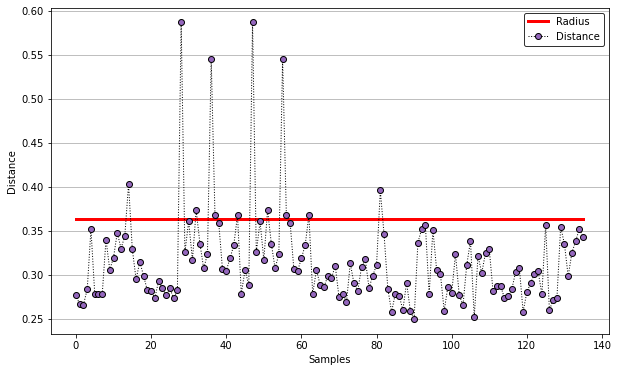

Wall time: 1h 25min 50s


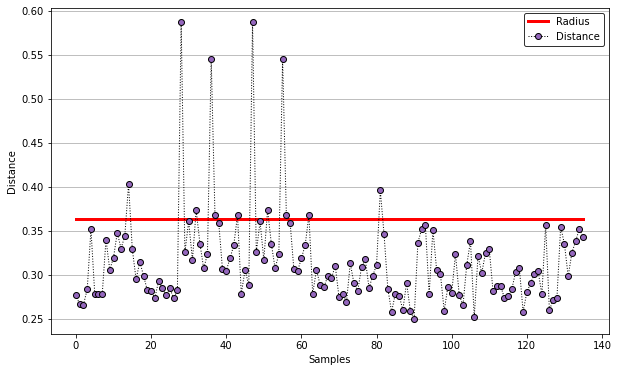

Wall time: 1h 25min 50s


In [5]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
    
    input_shape = (256,256, 3)
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(X_train, X_train,epochs=15,batch_size=16,shuffle=True,validation_data=(x_test, x_test))

    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)

    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-4), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    acc.append(svdd.accuracy)

Epoch 1/15
Epoch 1/15
17/17 [==============================] - 64s 4s/step - loss: 1.5049 - accuracy: 0.9883 - val_loss: 1.5015 - val_accuracy: 0.9883
Epoch 2/15
17/17 [==============================] - 64s 4s/step - loss: 1.5049 - accuracy: 0.9883 - val_loss: 1.5015 - val_accuracy: 0.9883
Epoch 2/15
17/17 [==============================] - 65s 4s/step - loss: 1.4997 - accuracy: 0.9883 - val_loss: 1.4941 - val_accuracy: 0.9883
Epoch 3/15
17/17 [==============================] - 65s 4s/step - loss: 1.4997 - accuracy: 0.9883 - val_loss: 1.4941 - val_accuracy: 0.9883
Epoch 3/15
17/17 [==============================] - 64s 4s/step - loss: 1.4900 - accuracy: 0.9883 - val_loss: 1.4829 - val_accuracy: 0.9883
Epoch 4/15
17/17 [==============================] - 64s 4s/step - loss: 1.4900 - accuracy: 0.9883 - val_loss: 1.4829 - val_accuracy: 0.9883
Epoch 4/15
17/17 [==============================] - 64s 4s/step - loss: 1.4822 - accuracy: 0.8666 - val_loss: 1.4810 - val_accuracy: 0.5229
Epoch 5/1

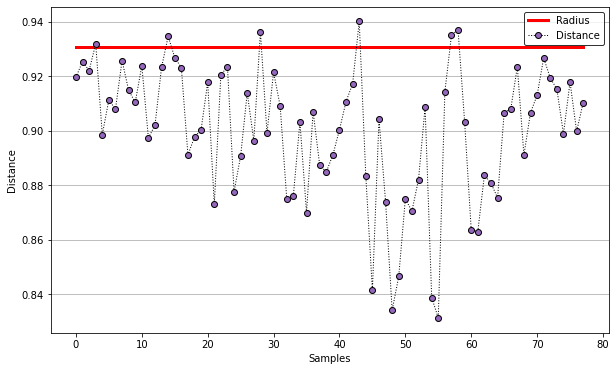

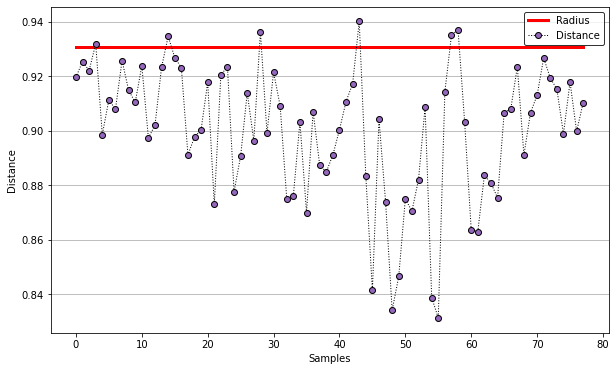

Epoch 1/15
Epoch 1/15
17/17 [==============================] - 66s 4s/step - loss: 1.5062 - accuracy: 1.5259e-05 - val_loss: 1.4999 - val_accuracy: 1.5259e-05
Epoch 2/15
17/17 [==============================] - 66s 4s/step - loss: 1.5062 - accuracy: 1.5259e-05 - val_loss: 1.4999 - val_accuracy: 1.5259e-05
Epoch 2/15
17/17 [==============================] - 63s 4s/step - loss: 1.4968 - accuracy: 1.5259e-05 - val_loss: 1.4989 - val_accuracy: 1.5259e-05
Epoch 3/15
Epoch 3/15
17/17 [==============================] - 64s 4s/step - loss: 1.4935 - accuracy: 4.4724e-04 - val_loss: 1.4933 - val_accuracy: 0.0030
Epoch 4/15
17/17 [==============================] - 64s 4s/step - loss: 1.4935 - accuracy: 4.4724e-04 - val_loss: 1.4933 - val_accuracy: 0.0030
Epoch 4/15
17/17 [==============================] - 63s 4s/step - loss: 1.4884 - accuracy: 0.0038 - val_loss: 1.4907 - val_accuracy: 0.0050
Epoch 5/15
Epoch 5/15
17/17 [==============================] - 63s 4s/step - loss: 1.4896 - accuracy: 0.00

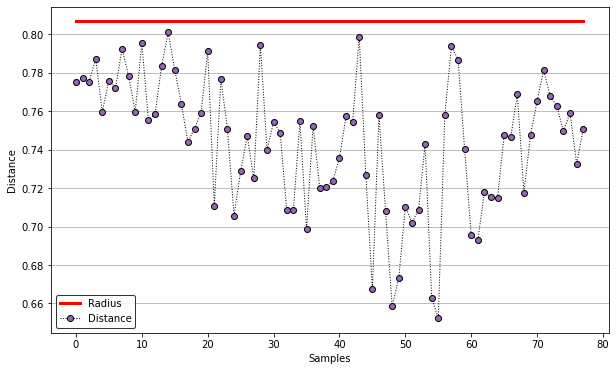

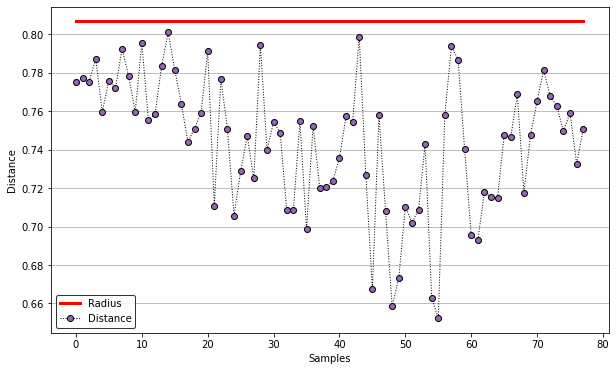

Epoch 1/15
Epoch 1/15
17/17 [==============================] - 65s 4s/step - loss: 1.7668 - accuracy: 0.0052 - val_loss: 1.5854 - val_accuracy: 0.0078
Epoch 2/15
Epoch 2/15
17/17 [==============================] - 64s 4s/step - loss: 1.5297 - accuracy: 0.3097 - val_loss: 1.4952 - val_accuracy: 0.9879
Epoch 3/15
17/17 [==============================] - 64s 4s/step - loss: 1.5297 - accuracy: 0.3097 - val_loss: 1.4952 - val_accuracy: 0.9879
Epoch 3/15
17/17 [==============================] - 63s 4s/step - loss: 1.4899 - accuracy: 0.9911 - val_loss: 1.4863 - val_accuracy: 0.9852
Epoch 4/15
17/17 [==============================] - 63s 4s/step - loss: 1.4899 - accuracy: 0.9911 - val_loss: 1.4863 - val_accuracy: 0.9852
Epoch 4/15
17/17 [==============================] - 63s 4s/step - loss: 1.4931 - accuracy: 0.6482 - val_loss: 1.5027 - val_accuracy: 0.0913
Epoch 5/15
17/17 [==============================] - 63s 4s/step - loss: 1.4931 - accuracy: 0.6482 - val_loss: 1.5027 - val_accuracy: 0.091

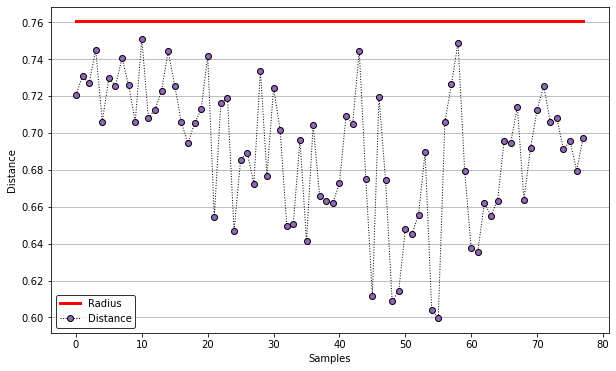

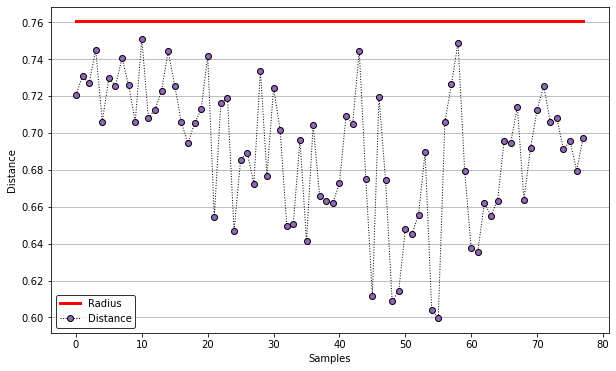

Epoch 1/15
Epoch 1/15
17/17 [==============================] - 65s 4s/step - loss: 1.5029 - accuracy: 0.0039 - val_loss: 1.4954 - val_accuracy: 0.0039
Epoch 2/15
17/17 [==============================] - 65s 4s/step - loss: 1.5029 - accuracy: 0.0039 - val_loss: 1.4954 - val_accuracy: 0.0039
Epoch 2/15
17/17 [==============================] - 64s 4s/step - loss: 1.4959 - accuracy: 0.0047 - val_loss: 1.4898 - val_accuracy: 0.0060
Epoch 3/15
17/17 [==============================] - 64s 4s/step - loss: 1.4959 - accuracy: 0.0047 - val_loss: 1.4898 - val_accuracy: 0.0060
Epoch 3/15
17/17 [==============================] - 63s 4s/step - loss: 1.4878 - accuracy: 0.0060 - val_loss: 1.4802 - val_accuracy: 0.0054
Epoch 4/15
17/17 [==============================] - 63s 4s/step - loss: 1.4878 - accuracy: 0.0060 - val_loss: 1.4802 - val_accuracy: 0.0054
Epoch 4/15
17/17 [==============================] - 63s 4s/step - loss: 1.4826 - accuracy: 0.0053 - val_loss: 1.4825 - val_accuracy: 0.0053
Epoch 5/1

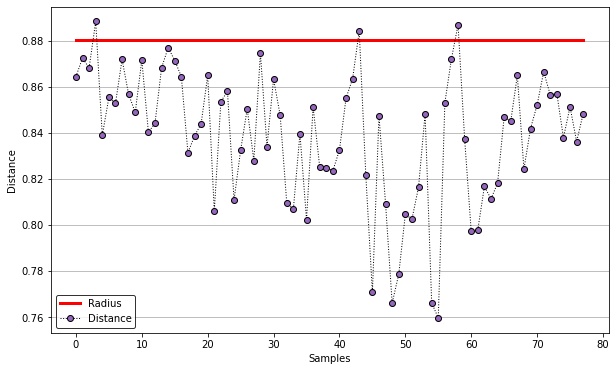

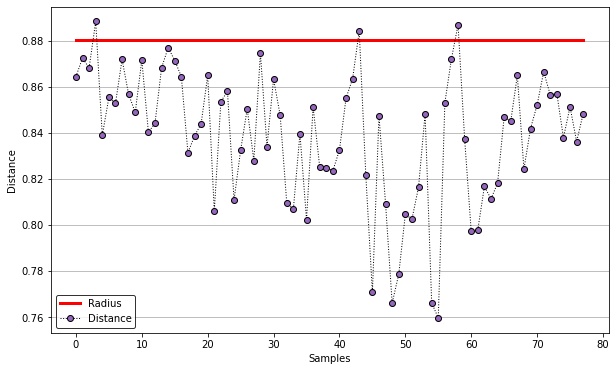

Epoch 1/15
Epoch 1/15
17/17 [==============================] - 64s 4s/step - loss: 1.6398 - accuracy: 0.4120 - val_loss: 1.6296 - val_accuracy: 0.8826
Epoch 2/15
17/17 [==============================] - 64s 4s/step - loss: 1.6398 - accuracy: 0.4120 - val_loss: 1.6296 - val_accuracy: 0.8826
Epoch 2/15
17/17 [==============================] - 64s 4s/step - loss: 1.6191 - accuracy: 0.9161 - val_loss: 1.6126 - val_accuracy: 0.6950
Epoch 3/15
17/17 [==============================] - 64s 4s/step - loss: 1.6191 - accuracy: 0.9161 - val_loss: 1.6126 - val_accuracy: 0.6950
Epoch 3/15
17/17 [==============================] - 63s 4s/step - loss: 1.6016 - accuracy: 0.4871 - val_loss: 1.5900 - val_accuracy: 0.3961
Epoch 4/15
Epoch 4/15
17/17 [==============================] - 63s 4s/step - loss: 1.5730 - accuracy: 0.3517 - val_loss: 1.5487 - val_accuracy: 0.3635
Epoch 5/15
17/17 [==============================] - 63s 4s/step - loss: 1.5730 - accuracy: 0.3517 - val_loss: 1.5487 - val_accuracy: 0.363

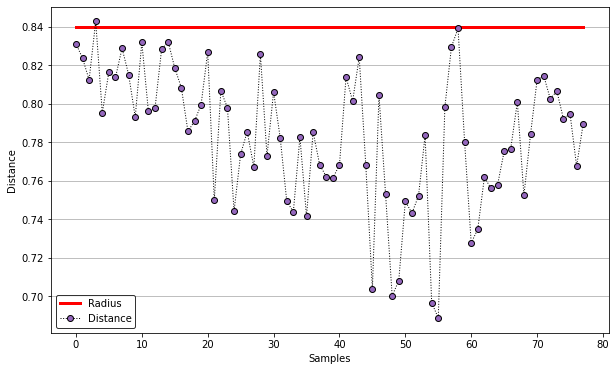

Wall time: 1h 20min 30s


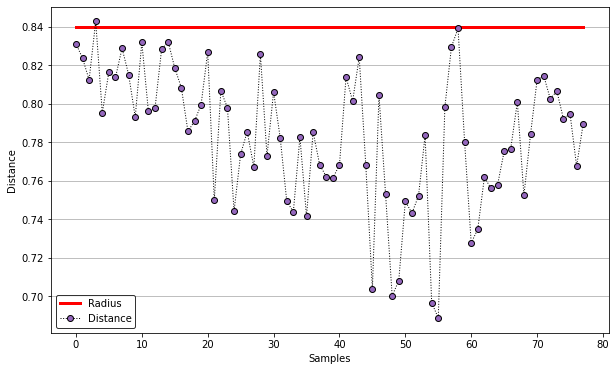

Wall time: 1h 20min 30s


In [6]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
    
    input_shape = (256,256, 3)
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(X_train, X_train,epochs=15,batch_size=16,shuffle=True,validation_data=(x_test, x_test))

    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)

    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-4), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    acc.append(svdd.accuracy)

Epoch 1/15
Epoch 1/15
25/25 [==============================] - 95s 4s/step - loss: 0.6668 - accuracy: 0.5991 - val_loss: 0.6622 - val_accuracy: 0.5977
Epoch 2/15
Epoch 2/15
25/25 [==============================] - 94s 4s/step - loss: 0.6596 - accuracy: 0.5993 - val_loss: 0.6565 - val_accuracy: 0.6233
Epoch 3/15
25/25 [==============================] - 94s 4s/step - loss: 0.6596 - accuracy: 0.5993 - val_loss: 0.6565 - val_accuracy: 0.6233
Epoch 3/15
25/25 [==============================] - 93s 4s/step - loss: 0.6509 - accuracy: 0.6234 - val_loss: 0.6497 - val_accuracy: 0.2605
Epoch 4/15
25/25 [==============================] - 93s 4s/step - loss: 0.6509 - accuracy: 0.6234 - val_loss: 0.6497 - val_accuracy: 0.2605
Epoch 4/15
25/25 [==============================] - 94s 4s/step - loss: 0.6522 - accuracy: 0.1605 - val_loss: 0.6506 - val_accuracy: 0.1426
Epoch 5/15
25/25 [==============================] - 94s 4s/step - loss: 0.6522 - accuracy: 0.1605 - val_loss: 0.6506 - val_accuracy: 0.142

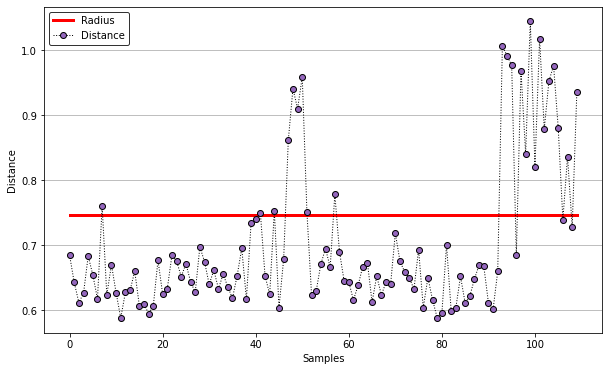

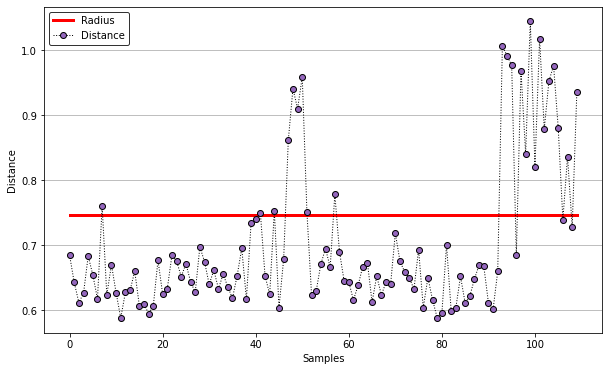

Epoch 1/15
Epoch 1/15
25/25 [==============================] - 96s 4s/step - loss: 0.7703 - accuracy: 0.0220 - val_loss: 0.6952 - val_accuracy: 0.0222
Epoch 2/15
Epoch 2/15
25/25 [==============================] - 94s 4s/step - loss: 0.6850 - accuracy: 0.0220 - val_loss: 0.6774 - val_accuracy: 0.0222
Epoch 3/15
25/25 [==============================] - 94s 4s/step - loss: 0.6850 - accuracy: 0.0220 - val_loss: 0.6774 - val_accuracy: 0.0222
Epoch 3/15
25/25 [==============================] - 95s 4s/step - loss: 0.6660 - accuracy: 0.0753 - val_loss: 0.6536 - val_accuracy: 0.2745
Epoch 4/15
25/25 [==============================] - 95s 4s/step - loss: 0.6660 - accuracy: 0.0753 - val_loss: 0.6536 - val_accuracy: 0.2745
Epoch 4/15
25/25 [==============================] - 93s 4s/step - loss: 0.6498 - accuracy: 0.3414 - val_loss: 0.6480 - val_accuracy: 0.3691
Epoch 5/15
25/25 [==============================] - 93s 4s/step - loss: 0.6498 - accuracy: 0.3414 - val_loss: 0.6480 - val_accuracy: 0.369

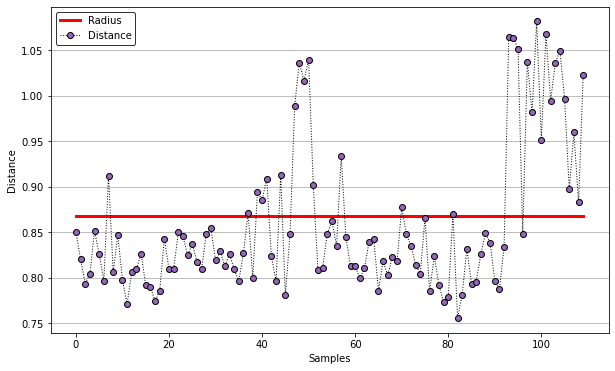

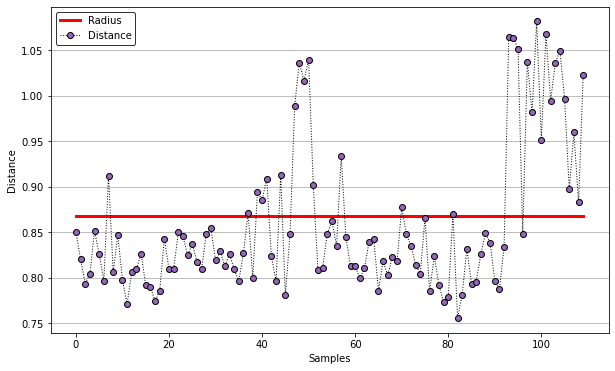

Epoch 1/15
Epoch 1/15
25/25 [==============================] - 96s 4s/step - loss: 0.7513 - accuracy: 0.6043 - val_loss: 0.6925 - val_accuracy: 0.6015
Epoch 2/15
25/25 [==============================] - 96s 4s/step - loss: 0.7513 - accuracy: 0.6043 - val_loss: 0.6925 - val_accuracy: 0.6015
Epoch 2/15
25/25 [==============================] - 94s 4s/step - loss: 0.6803 - accuracy: 0.5993 - val_loss: 0.6697 - val_accuracy: 0.6043
Epoch 3/15
25/25 [==============================] - 94s 4s/step - loss: 0.6803 - accuracy: 0.5993 - val_loss: 0.6697 - val_accuracy: 0.6043
Epoch 3/15
25/25 [==============================] - 94s 4s/step - loss: 0.6581 - accuracy: 0.7665 - val_loss: 0.6425 - val_accuracy: 0.9090
Epoch 4/15
25/25 [==============================] - 94s 4s/step - loss: 0.6581 - accuracy: 0.7665 - val_loss: 0.6425 - val_accuracy: 0.9090
Epoch 4/15
25/25 [==============================] - 93s 4s/step - loss: 0.6423 - accuracy: 0.7300 - val_loss: 0.6429 - val_accuracy: 0.5117
Epoch 5/1

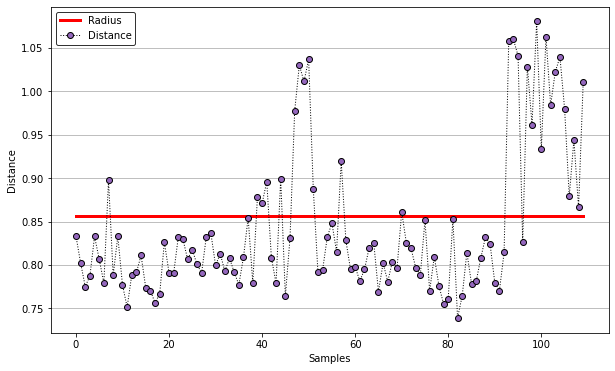

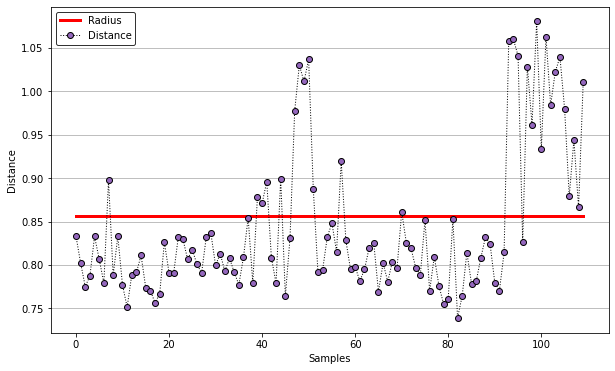

Epoch 1/15
Epoch 1/15
25/25 [==============================] - 96s 4s/step - loss: 0.7556 - accuracy: 0.0251 - val_loss: 0.6759 - val_accuracy: 0.0253
Epoch 2/15
25/25 [==============================] - 96s 4s/step - loss: 0.7556 - accuracy: 0.0251 - val_loss: 0.6759 - val_accuracy: 0.0253
Epoch 2/15
25/25 [==============================] - 96s 4s/step - loss: 0.6594 - accuracy: 0.0251 - val_loss: 0.6525 - val_accuracy: 0.0269
Epoch 3/15
Epoch 3/15
25/25 [==============================] - 94s 4s/step - loss: 0.6477 - accuracy: 0.1579 - val_loss: 0.6420 - val_accuracy: 0.3440
Epoch 4/15
25/25 [==============================] - 94s 4s/step - loss: 0.6477 - accuracy: 0.1579 - val_loss: 0.6420 - val_accuracy: 0.3440
Epoch 4/15
25/25 [==============================] - 94s 4s/step - loss: 0.6394 - accuracy: 0.3702 - val_loss: 0.6402 - val_accuracy: 0.3770
Epoch 5/15
25/25 [==============================] - 94s 4s/step - loss: 0.6394 - accuracy: 0.3702 - val_loss: 0.6402 - val_accuracy: 0.377

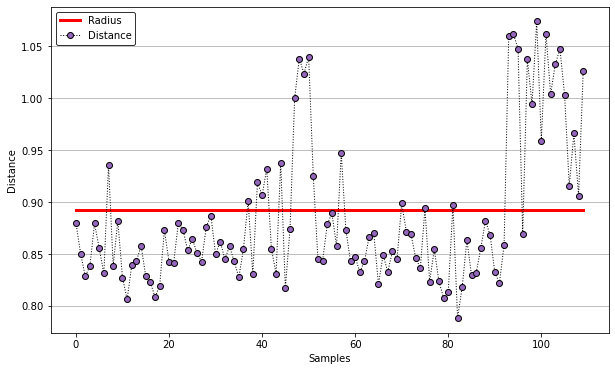

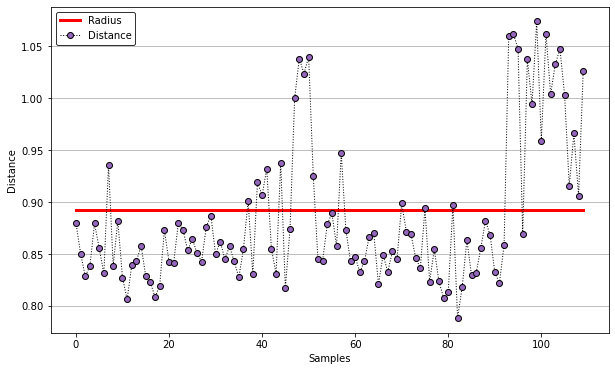

Epoch 1/15
Epoch 1/15
25/25 [==============================] - 96s 4s/step - loss: 0.6656 - accuracy: 0.3721 - val_loss: 0.6654 - val_accuracy: 0.3719
Epoch 2/15
25/25 [==============================] - 96s 4s/step - loss: 0.6656 - accuracy: 0.3721 - val_loss: 0.6654 - val_accuracy: 0.3719
Epoch 2/15
25/25 [==============================] - 94s 4s/step - loss: 0.6633 - accuracy: 0.3721 - val_loss: 0.6621 - val_accuracy: 0.3719
Epoch 3/15
25/25 [==============================] - 94s 4s/step - loss: 0.6633 - accuracy: 0.3721 - val_loss: 0.6621 - val_accuracy: 0.3719
Epoch 3/15
25/25 [==============================] - 93s 4s/step - loss: 0.6594 - accuracy: 0.3721 - val_loss: 0.6590 - val_accuracy: 0.3719
Epoch 4/15
25/25 [==============================] - 93s 4s/step - loss: 0.6594 - accuracy: 0.3721 - val_loss: 0.6590 - val_accuracy: 0.3719
Epoch 4/15
25/25 [==============================] - 93s 4s/step - loss: 0.6602 - accuracy: 0.3454 - val_loss: 0.6625 - val_accuracy: 0.2711
Epoch 5/1

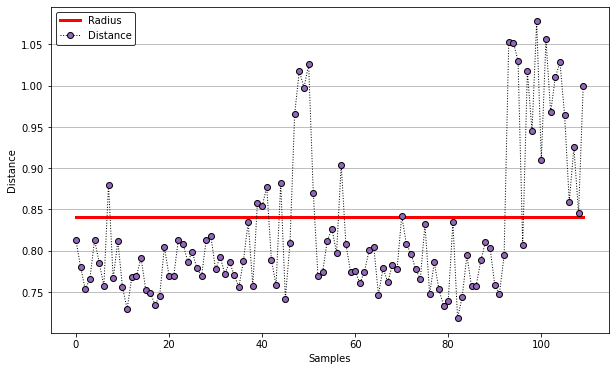

Wall time: 1h 59min 30s


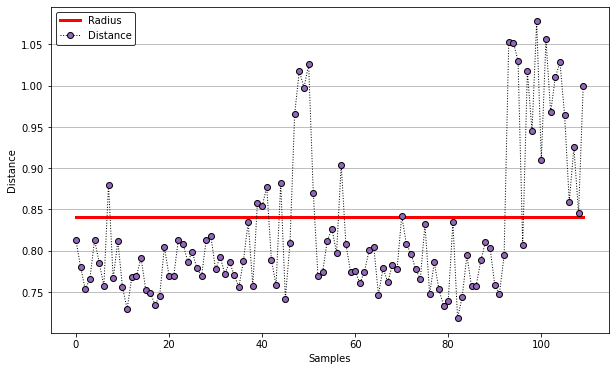

Wall time: 1h 59min 30s


In [7]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
    
    input_shape = (256,256, 3)
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(X_train, X_train,epochs=15,batch_size=16,shuffle=True,validation_data=(x_test, x_test))

    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)

    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-4), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    acc.append(svdd.accuracy)

Epoch 1/15
Epoch 1/15
16/16 [==============================] - 60s 4s/step - loss: 1.1078 - accuracy: 0.0039 - val_loss: 1.0078 - val_accuracy: 0.0039
Epoch 2/15
Epoch 2/15
16/16 [==============================] - 59s 4s/step - loss: 0.9694 - accuracy: 0.4129 - val_loss: 0.9460 - val_accuracy: 0.9922
Epoch 3/15
16/16 [==============================] - 59s 4s/step - loss: 0.9694 - accuracy: 0.4129 - val_loss: 0.9460 - val_accuracy: 0.9922
Epoch 3/15
16/16 [==============================] - 59s 4s/step - loss: 0.9402 - accuracy: 0.9951 - val_loss: 0.9383 - val_accuracy: 0.9961
Epoch 4/15
Epoch 4/15
16/16 [==============================] - 59s 4s/step - loss: 0.9362 - accuracy: 0.9961 - val_loss: 0.9380 - val_accuracy: 0.9961
Epoch 5/15
16/16 [==============================] - 59s 4s/step - loss: 0.9362 - accuracy: 0.9961 - val_loss: 0.9380 - val_accuracy: 0.9961
Epoch 5/15
16/16 [==============================] - 59s 4s/step - loss: 0.9370 - accuracy: 0.9961 - val_loss: 0.9384 - val_accu

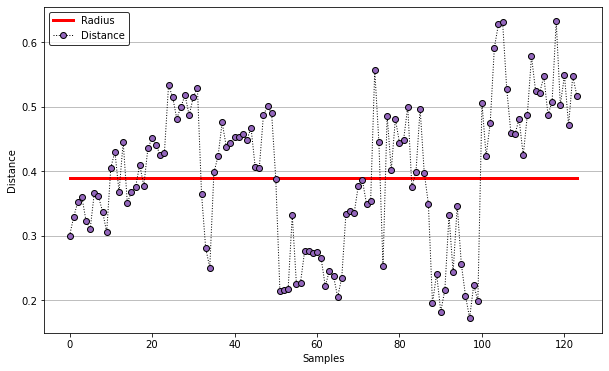

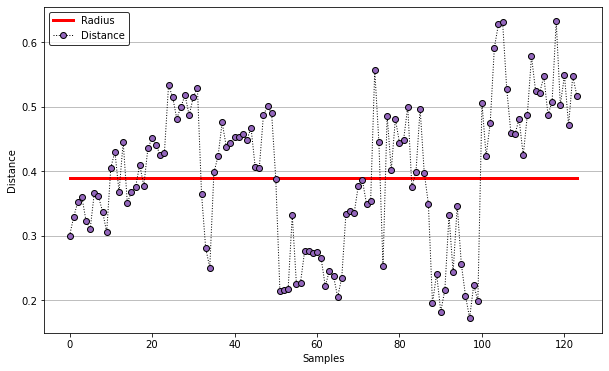

Epoch 1/15
Epoch 1/15
16/16 [==============================] - 60s 4s/step - loss: 0.9356 - accuracy: 0.9937 - val_loss: 0.9364 - val_accuracy: 0.9922
Epoch 2/15
Epoch 2/15
16/16 [==============================] - 59s 4s/step - loss: 0.9343 - accuracy: 0.9936 - val_loss: 0.9365 - val_accuracy: 0.9961
Epoch 3/15
16/16 [==============================] - 59s 4s/step - loss: 0.9343 - accuracy: 0.9936 - val_loss: 0.9365 - val_accuracy: 0.9961
Epoch 3/15
16/16 [==============================] - 59s 4s/step - loss: 0.9346 - accuracy: 0.9961 - val_loss: 0.9369 - val_accuracy: 0.9962
Epoch 4/15
Epoch 4/15
16/16 [==============================] - 59s 4s/step - loss: 0.9349 - accuracy: 0.9964 - val_loss: 0.9371 - val_accuracy: 0.9982
Epoch 5/15
Epoch 5/15
16/16 [==============================] - 59s 4s/step - loss: 0.9350 - accuracy: 0.9989 - val_loss: 0.9372 - val_accuracy: 0.9958
Epoch 6/15
16/16 [==============================] - 59s 4s/step - loss: 0.9350 - accuracy: 0.9989 - val_loss: 0.9372

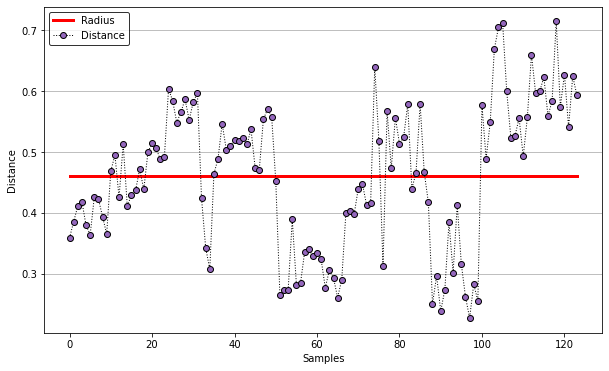

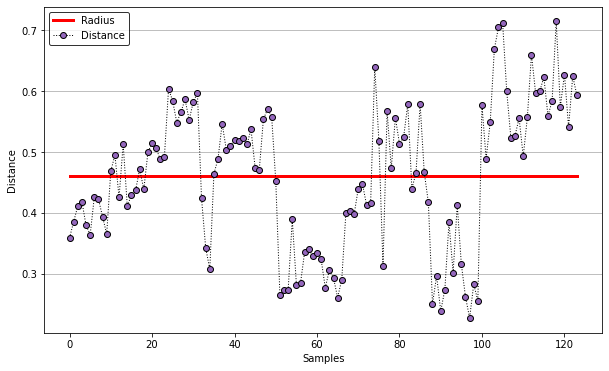

Epoch 1/15
Epoch 1/15
16/16 [==============================] - 60s 4s/step - loss: 0.9405 - accuracy: 0.9922 - val_loss: 0.9387 - val_accuracy: 0.9922
Epoch 2/15
Epoch 2/15
16/16 [==============================] - 59s 4s/step - loss: 0.9392 - accuracy: 0.9922 - val_loss: 0.9379 - val_accuracy: 0.9922
Epoch 3/15
Epoch 3/15
16/16 [==============================] - 59s 4s/step - loss: 0.9388 - accuracy: 0.9922 - val_loss: 0.9370 - val_accuracy: 0.9922
Epoch 4/15
16/16 [==============================] - 59s 4s/step - loss: 0.9388 - accuracy: 0.9922 - val_loss: 0.9370 - val_accuracy: 0.9922
Epoch 4/15
16/16 [==============================] - 59s 4s/step - loss: 0.9376 - accuracy: 0.9922 - val_loss: 0.9358 - val_accuracy: 0.9922
Epoch 5/15
Epoch 5/15
16/16 [==============================] - 59s 4s/step - loss: 0.9364 - accuracy: 0.9922 - val_loss: 0.9346 - val_accuracy: 0.9922
Epoch 6/15
16/16 [==============================] - 59s 4s/step - loss: 0.9364 - accuracy: 0.9922 - val_loss: 0.9346

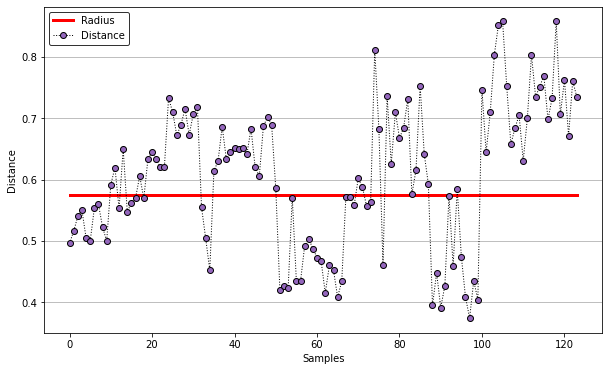

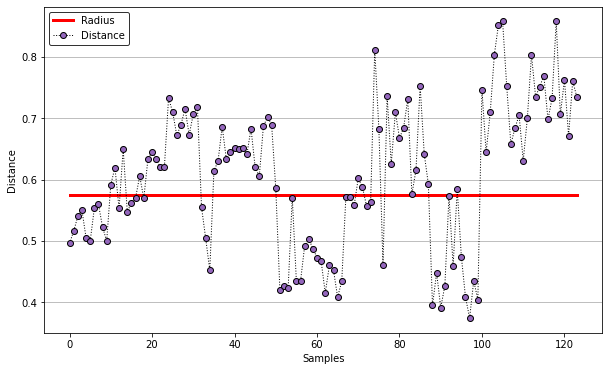

Epoch 1/15
Epoch 1/15
16/16 [==============================] - 60s 4s/step - loss: 0.9894 - accuracy: 0.9961 - val_loss: 0.9456 - val_accuracy: 0.9961
Epoch 2/15
Epoch 2/15
16/16 [==============================] - 59s 4s/step - loss: 0.9373 - accuracy: 0.9961 - val_loss: 0.9374 - val_accuracy: 0.9961
Epoch 3/15
16/16 [==============================] - 59s 4s/step - loss: 0.9373 - accuracy: 0.9961 - val_loss: 0.9374 - val_accuracy: 0.9961
Epoch 3/15
16/16 [==============================] - 59s 4s/step - loss: 0.9376 - accuracy: 0.9961 - val_loss: 0.9366 - val_accuracy: 0.9961
Epoch 4/15
16/16 [==============================] - 59s 4s/step - loss: 0.9376 - accuracy: 0.9961 - val_loss: 0.9366 - val_accuracy: 0.9961
Epoch 4/15
16/16 [==============================] - 59s 4s/step - loss: 0.9355 - accuracy: 0.9961 - val_loss: 0.9353 - val_accuracy: 0.9961
Epoch 5/15
Epoch 5/15
16/16 [==============================] - 59s 4s/step - loss: 0.9354 - accuracy: 0.9961 - val_loss: 0.9360 - val_accu

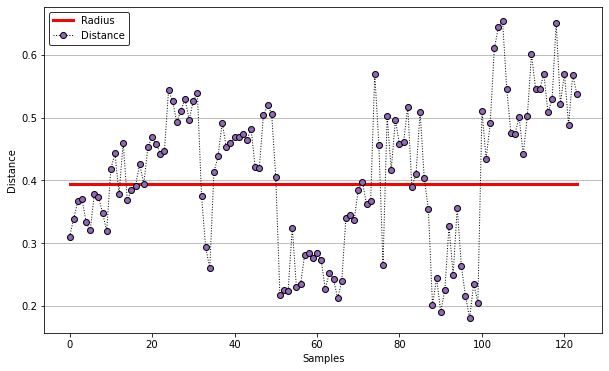

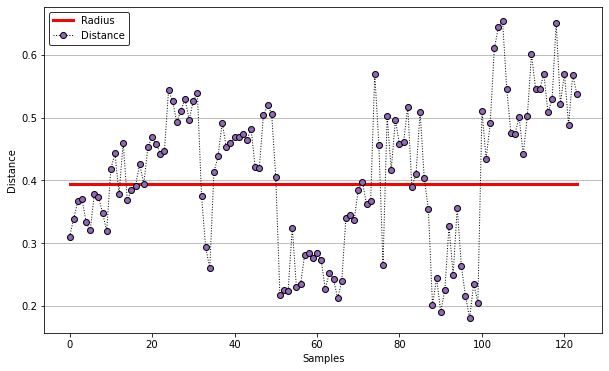

Epoch 1/15
Epoch 1/15
16/16 [==============================] - 61s 4s/step - loss: 0.9570 - accuracy: 0.4785 - val_loss: 0.9347 - val_accuracy: 0.9961
Epoch 2/15
Epoch 2/15
16/16 [==============================] - 63s 4s/step - loss: 0.9356 - accuracy: 0.9961 - val_loss: 0.9351 - val_accuracy: 0.9961
Epoch 3/15
16/16 [==============================] - 63s 4s/step - loss: 0.9356 - accuracy: 0.9961 - val_loss: 0.9351 - val_accuracy: 0.9961
Epoch 3/15
16/16 [==============================] - 60s 4s/step - loss: 0.9370 - accuracy: 0.9935 - val_loss: 0.9356 - val_accuracy: 0.9922
Epoch 4/15
16/16 [==============================] - 60s 4s/step - loss: 0.9370 - accuracy: 0.9935 - val_loss: 0.9356 - val_accuracy: 0.9922
Epoch 4/15
16/16 [==============================] - 59s 4s/step - loss: 0.9358 - accuracy: 0.9922 - val_loss: 0.9338 - val_accuracy: 0.9922
Epoch 5/15
16/16 [==============================] - 59s 4s/step - loss: 0.9358 - accuracy: 0.9922 - val_loss: 0.9338 - val_accuracy: 0.992

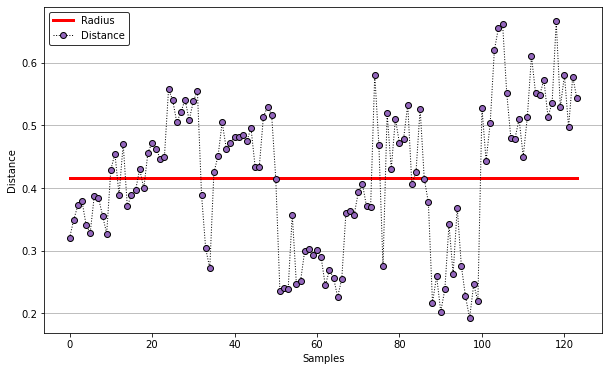

Wall time: 1h 15min 17s


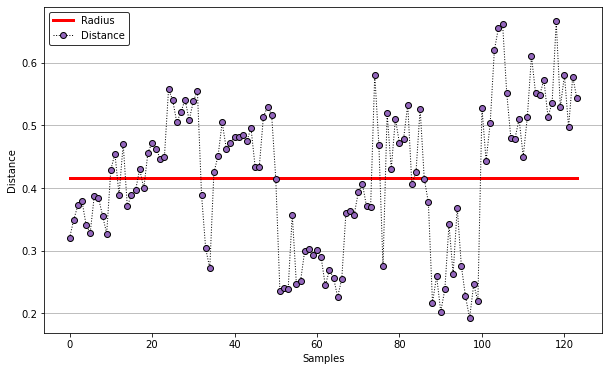

Wall time: 1h 15min 17s


In [8]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
    
    input_shape = (256,256, 3)
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(X_train, X_train,epochs=15,batch_size=16,shuffle=True,validation_data=(x_test, x_test))

    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)

    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-2), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    acc.append(svdd.accuracy)

Epoch 1/15
Epoch 1/15
14/14 [==============================] - 54s 4s/step - loss: 0.7952 - accuracy: 0.3484 - val_loss: 0.7779 - val_accuracy: 0.3484
Epoch 2/15
14/14 [==============================] - 54s 4s/step - loss: 0.7952 - accuracy: 0.3484 - val_loss: 0.7779 - val_accuracy: 0.3484
Epoch 2/15
14/14 [==============================] - 53s 4s/step - loss: 0.7751 - accuracy: 0.3484 - val_loss: 0.7734 - val_accuracy: 0.3484
Epoch 3/15
14/14 [==============================] - 53s 4s/step - loss: 0.7751 - accuracy: 0.3484 - val_loss: 0.7734 - val_accuracy: 0.3484
Epoch 3/15
14/14 [==============================] - 53s 4s/step - loss: 0.7724 - accuracy: 0.3484 - val_loss: 0.7714 - val_accuracy: 0.3484
Epoch 4/15
14/14 [==============================] - 53s 4s/step - loss: 0.7724 - accuracy: 0.3484 - val_loss: 0.7714 - val_accuracy: 0.3484
Epoch 4/15
14/14 [==============================] - 53s 4s/step - loss: 0.7691 - accuracy: 0.3484 - val_loss: 0.7662 - val_accuracy: 0.3484
Epoch 5/1

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.1406 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9745
number of samples    = 220
number of features   = 8192
number of SVs        = 121
ratio of SVs         = 55.0000 %
accuracy             = 53.6364 %




*** Prediction of the provided data is completed. ***

running time         = 0.0156 seconds
number of samples    = 22
number of alarm      = 13
accuracy             = 40.9091 %




*** Prediction of the provided data is completed. ***

running time         = 0.0312 seconds
number of samples    = 93
number of alarm      = 68
accuracy             = 73.1183 %




*** Prediction of the provided data is completed. ***

running time         = 0.0469 seconds
number of samples    = 115
number of alarm      = 81
accuracy             = 66.9565 %




*** Fitting of the SVDD model is completed. ***

running time         = 0.1406 seconds
kernel function      = rbf
iterations      

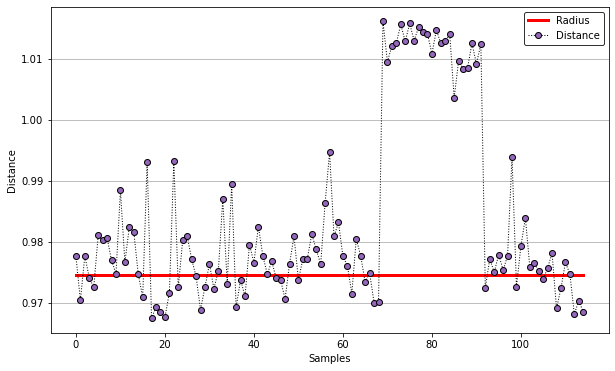

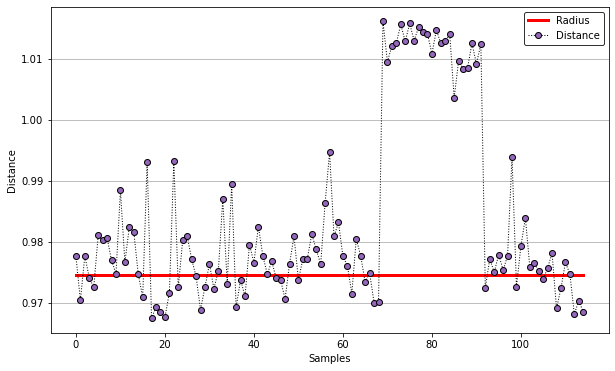

Epoch 1/15
Epoch 1/15
14/14 [==============================] - 55s 4s/step - loss: 1.0367 - accuracy: 0.0337 - val_loss: 0.9483 - val_accuracy: 0.0338
Epoch 2/15
14/14 [==============================] - 55s 4s/step - loss: 1.0367 - accuracy: 0.0337 - val_loss: 0.9483 - val_accuracy: 0.0338
Epoch 2/15
14/14 [==============================] - 54s 4s/step - loss: 0.8843 - accuracy: 0.0337 - val_loss: 0.8179 - val_accuracy: 0.0340
Epoch 3/15
14/14 [==============================] - 54s 4s/step - loss: 0.8843 - accuracy: 0.0337 - val_loss: 0.8179 - val_accuracy: 0.0340
Epoch 3/15
14/14 [==============================] - 53s 4s/step - loss: 0.7836 - accuracy: 0.0542 - val_loss: 0.7588 - val_accuracy: 0.1195
Epoch 4/15
14/14 [==============================] - 53s 4s/step - loss: 0.7836 - accuracy: 0.0542 - val_loss: 0.7588 - val_accuracy: 0.1195
Epoch 4/15
14/14 [==============================] - 53s 4s/step - loss: 0.7572 - accuracy: 0.3118 - val_loss: 0.7602 - val_accuracy: 0.3524
Epoch 5/1

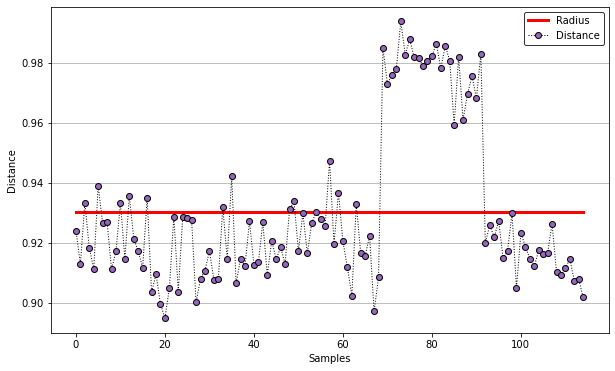

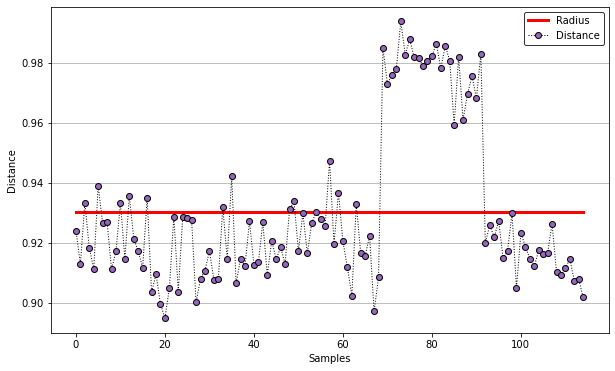

Epoch 1/15
Epoch 1/15
14/14 [==============================] - 54s 4s/step - loss: 0.7929 - accuracy: 0.3533 - val_loss: 0.7797 - val_accuracy: 0.3565
Epoch 2/15
14/14 [==============================] - 54s 4s/step - loss: 0.7929 - accuracy: 0.3533 - val_loss: 0.7797 - val_accuracy: 0.3565
Epoch 2/15
14/14 [==============================] - 53s 4s/step - loss: 0.7755 - accuracy: 0.3561 - val_loss: 0.7733 - val_accuracy: 0.3565
Epoch 3/15
14/14 [==============================] - 53s 4s/step - loss: 0.7755 - accuracy: 0.3561 - val_loss: 0.7733 - val_accuracy: 0.3565
Epoch 3/15
14/14 [==============================] - 53s 4s/step - loss: 0.7699 - accuracy: 0.3561 - val_loss: 0.7675 - val_accuracy: 0.3565
Epoch 4/15
14/14 [==============================] - 53s 4s/step - loss: 0.7699 - accuracy: 0.3561 - val_loss: 0.7675 - val_accuracy: 0.3565
Epoch 4/15
14/14 [==============================] - 54s 4s/step - loss: 0.7643 - accuracy: 0.3464 - val_loss: 0.7637 - val_accuracy: 0.2619
Epoch 5/1

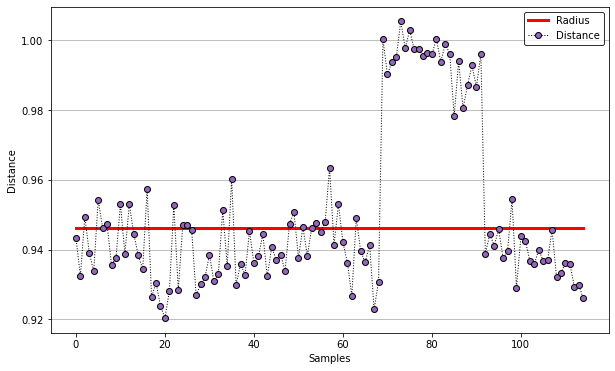

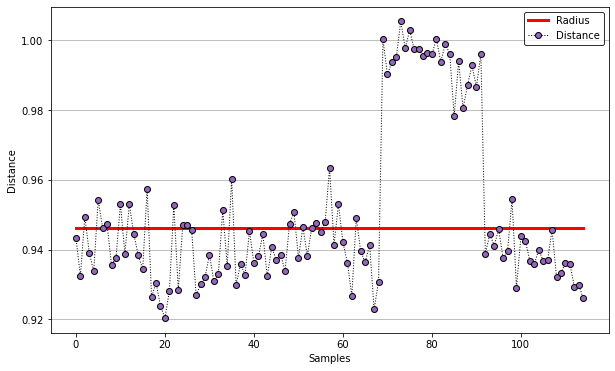

Epoch 1/15
Epoch 1/15
14/14 [==============================] - 54s 4s/step - loss: 0.8377 - accuracy: 0.6257 - val_loss: 0.7888 - val_accuracy: 0.6270
Epoch 2/15
Epoch 2/15
14/14 [==============================] - 53s 4s/step - loss: 0.7753 - accuracy: 0.6235 - val_loss: 0.7635 - val_accuracy: 0.6231
Epoch 3/15
14/14 [==============================] - 53s 4s/step - loss: 0.7753 - accuracy: 0.6235 - val_loss: 0.7635 - val_accuracy: 0.6231
Epoch 3/15
14/14 [==============================] - 53s 4s/step - loss: 0.7640 - accuracy: 0.6218 - val_loss: 0.7602 - val_accuracy: 0.6231
Epoch 4/15
14/14 [==============================] - 53s 4s/step - loss: 0.7640 - accuracy: 0.6218 - val_loss: 0.7602 - val_accuracy: 0.6231
Epoch 4/15
14/14 [==============================] - 53s 4s/step - loss: 0.7615 - accuracy: 0.6218 - val_loss: 0.7577 - val_accuracy: 0.6231
Epoch 5/15
14/14 [==============================] - 53s 4s/step - loss: 0.7615 - accuracy: 0.6218 - val_loss: 0.7577 - val_accuracy: 0.623

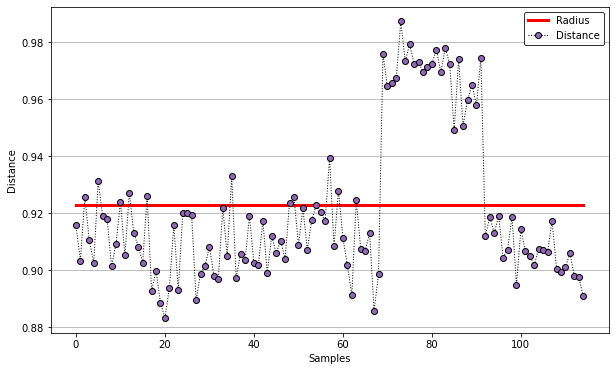

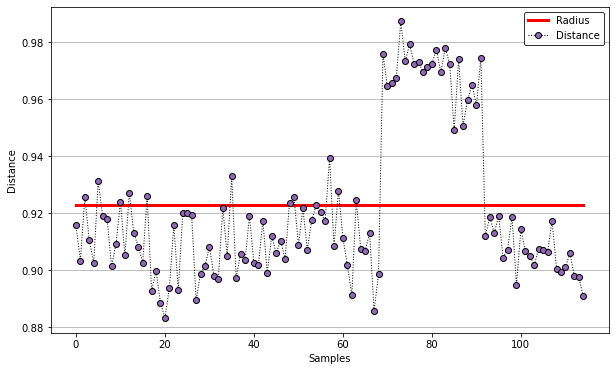

Epoch 1/15
Epoch 1/15
14/14 [==============================] - 54s 4s/step - loss: 0.8077 - accuracy: 0.0298 - val_loss: 0.7956 - val_accuracy: 0.0300
Epoch 2/15
14/14 [==============================] - 54s 4s/step - loss: 0.8077 - accuracy: 0.0298 - val_loss: 0.7956 - val_accuracy: 0.0300
Epoch 2/15
14/14 [==============================] - 53s 4s/step - loss: 0.7933 - accuracy: 0.0298 - val_loss: 0.7903 - val_accuracy: 0.0300
Epoch 3/15
14/14 [==============================] - 53s 4s/step - loss: 0.7933 - accuracy: 0.0298 - val_loss: 0.7903 - val_accuracy: 0.0300
Epoch 3/15
14/14 [==============================] - 53s 4s/step - loss: 0.7864 - accuracy: 0.0298 - val_loss: 0.7799 - val_accuracy: 0.0300
Epoch 4/15
Epoch 4/15
14/14 [==============================] - 53s 4s/step - loss: 0.7730 - accuracy: 0.0307 - val_loss: 0.7653 - val_accuracy: 0.0660
Epoch 5/15
14/14 [==============================] - 53s 4s/step - loss: 0.7730 - accuracy: 0.0307 - val_loss: 0.7653 - val_accuracy: 0.066

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.1406 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9764
number of samples    = 220
number of features   = 8192
number of SVs        = 122
ratio of SVs         = 55.4545 %
accuracy             = 51.8182 %




*** Prediction of the provided data is completed. ***

running time         = 0.0156 seconds
number of samples    = 22
number of alarm      = 13
accuracy             = 40.9091 %




*** Prediction of the provided data is completed. ***

running time         = 0.0469 seconds
number of samples    = 93
number of alarm      = 69
accuracy             = 74.1935 %




*** Prediction of the provided data is completed. ***

running time         = 0.0469 seconds
number of samples    = 115
number of alarm      = 82
accuracy             = 67.8261 %




*** Fitting of the SVDD model is completed. ***

running time         = 0.1406 seconds
kernel function      = rbf
iterations      

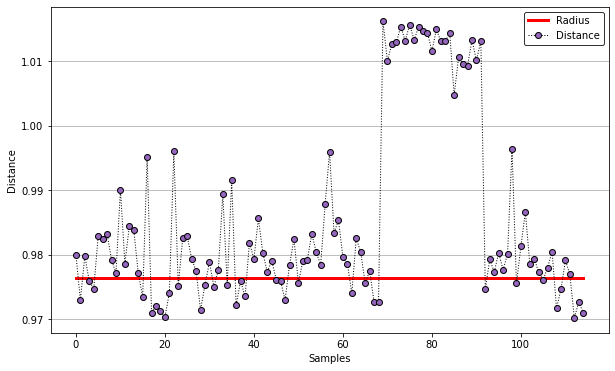

Wall time: 1h 7min 10s


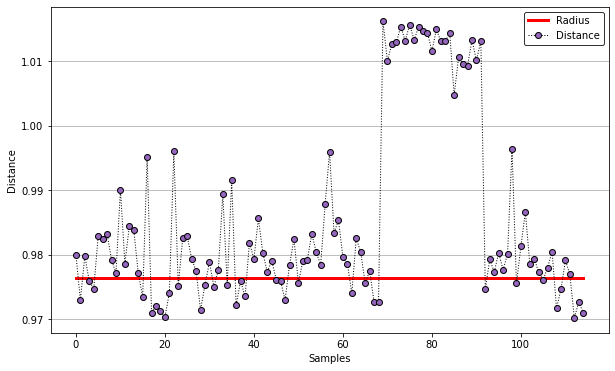

Wall time: 1h 7min 10s


In [9]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
    
    input_shape = (256,256, 3)
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(X_train, X_train,epochs=15,batch_size=16,shuffle=True,validation_data=(x_test, x_test))

    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)

    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-2), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    acc.append(svdd.accuracy)

Epoch 1/15
Epoch 1/15
17/17 [==============================] - 65s 4s/step - loss: 1.0622 - accuracy: 0.7253 - val_loss: 1.0257 - val_accuracy: 0.7229
Epoch 2/15
17/17 [==============================] - 65s 4s/step - loss: 1.0622 - accuracy: 0.7253 - val_loss: 1.0257 - val_accuracy: 0.7229
Epoch 2/15
17/17 [==============================] - 64s 4s/step - loss: 1.0228 - accuracy: 0.4749 - val_loss: 1.0227 - val_accuracy: 0.1263
Epoch 3/15
Epoch 3/15
17/17 [==============================] - 65s 4s/step - loss: 1.0217 - accuracy: 0.4338 - val_loss: 1.0197 - val_accuracy: 0.7029
Epoch 4/15
17/17 [==============================] - 65s 4s/step - loss: 1.0217 - accuracy: 0.4338 - val_loss: 1.0197 - val_accuracy: 0.7029
Epoch 4/15
17/17 [==============================] - 65s 4s/step - loss: 1.0205 - accuracy: 0.7155 - val_loss: 1.0236 - val_accuracy: 0.7070
Epoch 5/15
17/17 [==============================] - 65s 4s/step - loss: 1.0205 - accuracy: 0.7155 - val_loss: 1.0236 - val_accuracy: 0.707

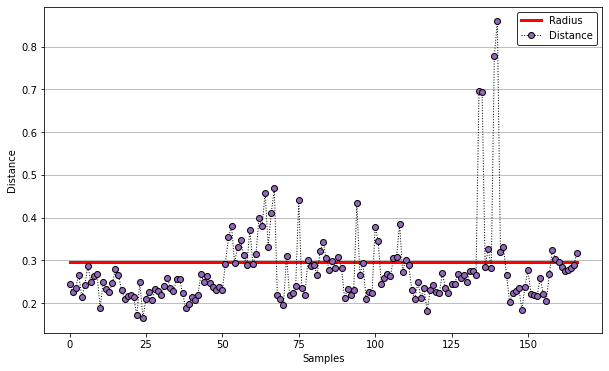

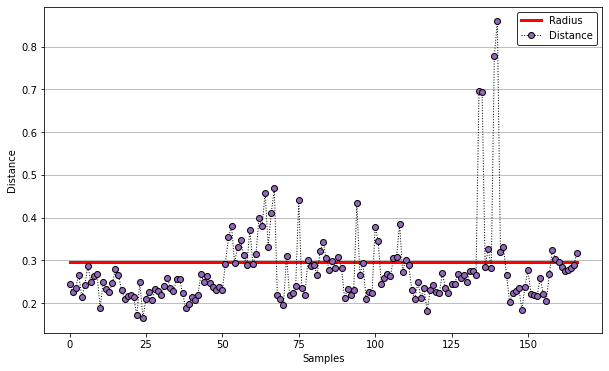

Epoch 1/15
Epoch 1/15
17/17 [==============================] - 65s 4s/step - loss: 1.0623 - accuracy: 0.1226 - val_loss: 1.0227 - val_accuracy: 0.1265
Epoch 2/15
17/17 [==============================] - 65s 4s/step - loss: 1.0623 - accuracy: 0.1226 - val_loss: 1.0227 - val_accuracy: 0.1265
Epoch 2/15
17/17 [==============================] - 65s 4s/step - loss: 1.0229 - accuracy: 0.6232 - val_loss: 1.0235 - val_accuracy: 0.7270
Epoch 3/15
17/17 [==============================] - 65s 4s/step - loss: 1.0229 - accuracy: 0.6232 - val_loss: 1.0235 - val_accuracy: 0.7270
Epoch 3/15
17/17 [==============================] - 65s 4s/step - loss: 1.0221 - accuracy: 0.7271 - val_loss: 1.0210 - val_accuracy: 0.7269
Epoch 4/15
17/17 [==============================] - 65s 4s/step - loss: 1.0221 - accuracy: 0.7271 - val_loss: 1.0210 - val_accuracy: 0.7269
Epoch 4/15
17/17 [==============================] - 65s 4s/step - loss: 1.0219 - accuracy: 0.7131 - val_loss: 1.0229 - val_accuracy: 0.7043
Epoch 5/1

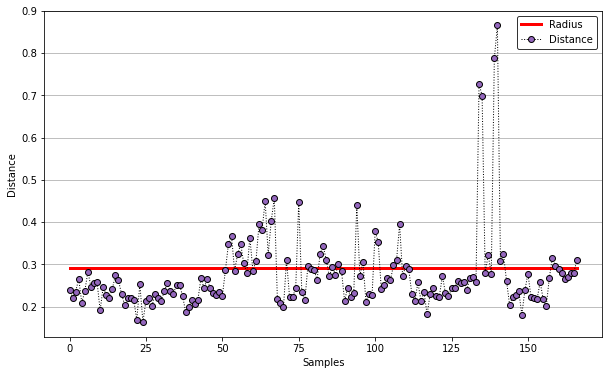

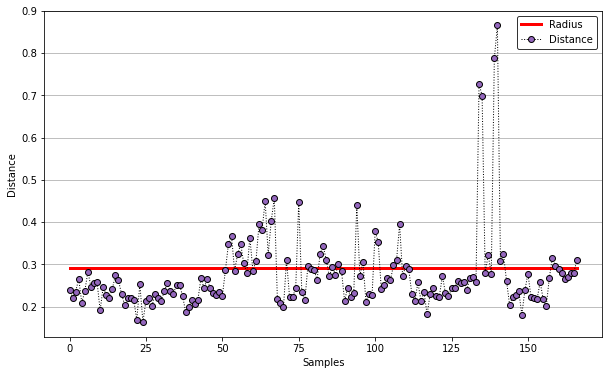

Epoch 1/15
Epoch 1/15
17/17 [==============================] - 65s 4s/step - loss: 1.1338 - accuracy: 0.1504 - val_loss: 1.0571 - val_accuracy: 0.1503
Epoch 2/15
17/17 [==============================] - 65s 4s/step - loss: 1.1338 - accuracy: 0.1504 - val_loss: 1.0571 - val_accuracy: 0.1503
Epoch 2/15
17/17 [==============================] - 65s 4s/step - loss: 1.0342 - accuracy: 0.1916 - val_loss: 1.0229 - val_accuracy: 0.7233
Epoch 3/15
17/17 [==============================] - 65s 4s/step - loss: 1.0342 - accuracy: 0.1916 - val_loss: 1.0229 - val_accuracy: 0.7233
Epoch 3/15
17/17 [==============================] - 64s 4s/step - loss: 1.0230 - accuracy: 0.7266 - val_loss: 1.0224 - val_accuracy: 0.7272
Epoch 4/15
17/17 [==============================] - 64s 4s/step - loss: 1.0230 - accuracy: 0.7266 - val_loss: 1.0224 - val_accuracy: 0.7272
Epoch 4/15
17/17 [==============================] - 65s 4s/step - loss: 1.0227 - accuracy: 0.7291 - val_loss: 1.0229 - val_accuracy: 0.7597
Epoch 5/1

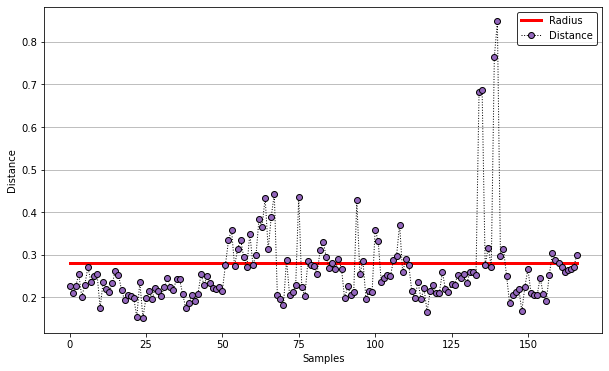

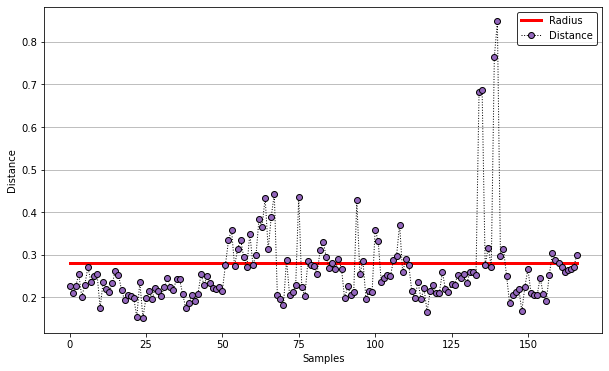

Epoch 1/15
Epoch 1/15
17/17 [==============================] - 65s 4s/step - loss: 1.1813 - accuracy: 0.1504 - val_loss: 1.0852 - val_accuracy: 0.1506
Epoch 2/15
17/17 [==============================] - 65s 4s/step - loss: 1.1813 - accuracy: 0.1504 - val_loss: 1.0852 - val_accuracy: 0.1506
Epoch 2/15
17/17 [==============================] - 64s 4s/step - loss: 1.0459 - accuracy: 0.1504 - val_loss: 1.0242 - val_accuracy: 0.1506
Epoch 3/15
17/17 [==============================] - 64s 4s/step - loss: 1.0459 - accuracy: 0.1504 - val_loss: 1.0242 - val_accuracy: 0.1506
Epoch 3/15
17/17 [==============================] - 65s 4s/step - loss: 1.0251 - accuracy: 0.1266 - val_loss: 1.0298 - val_accuracy: 0.2453
Epoch 4/15
Epoch 4/15
17/17 [==============================] - 64s 4s/step - loss: 1.0293 - accuracy: 0.5723 - val_loss: 1.0307 - val_accuracy: 0.6224
Epoch 5/15
17/17 [==============================] - 64s 4s/step - loss: 1.0293 - accuracy: 0.5723 - val_loss: 1.0307 - val_accuracy: 0.622

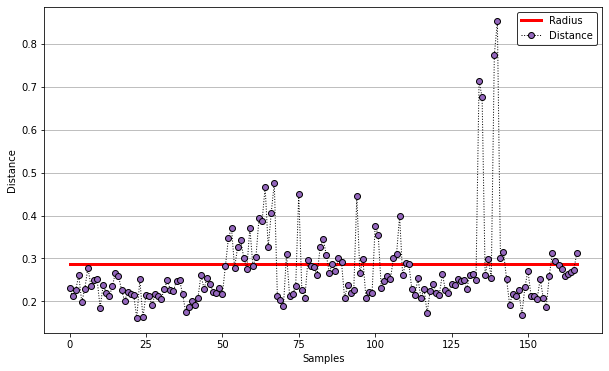

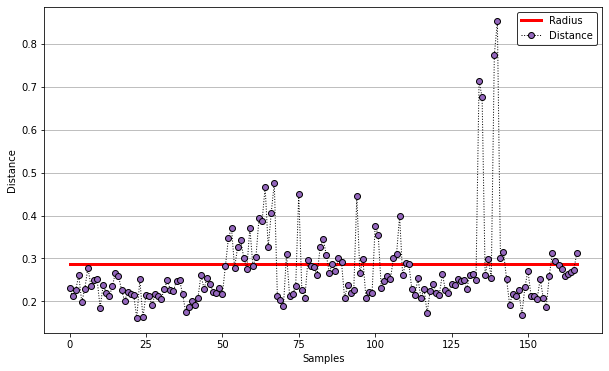

Epoch 1/15
Epoch 1/15
17/17 [==============================] - 65s 4s/step - loss: 1.0227 - accuracy: 0.3017 - val_loss: 1.0214 - val_accuracy: 0.1448
Epoch 2/15
17/17 [==============================] - 65s 4s/step - loss: 1.0227 - accuracy: 0.3017 - val_loss: 1.0214 - val_accuracy: 0.1448
Epoch 2/15
17/17 [==============================] - 65s 4s/step - loss: 1.0219 - accuracy: 0.1350 - val_loss: 1.0213 - val_accuracy: 0.1847
Epoch 3/15
17/17 [==============================] - 65s 4s/step - loss: 1.0219 - accuracy: 0.1350 - val_loss: 1.0213 - val_accuracy: 0.1847
Epoch 3/15
17/17 [==============================] - 64s 4s/step - loss: 1.0213 - accuracy: 0.5500 - val_loss: 1.0208 - val_accuracy: 0.7017
Epoch 4/15
17/17 [==============================] - 64s 4s/step - loss: 1.0213 - accuracy: 0.5500 - val_loss: 1.0208 - val_accuracy: 0.7017
Epoch 4/15
17/17 [==============================] - 65s 4s/step - loss: 1.0221 - accuracy: 0.6944 - val_loss: 1.0242 - val_accuracy: 0.3976
Epoch 5/1

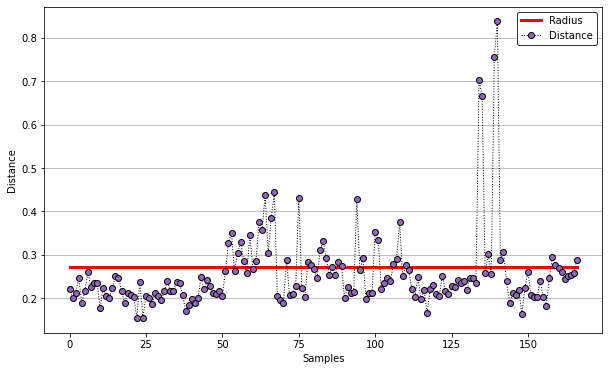

Wall time: 1h 21min 52s


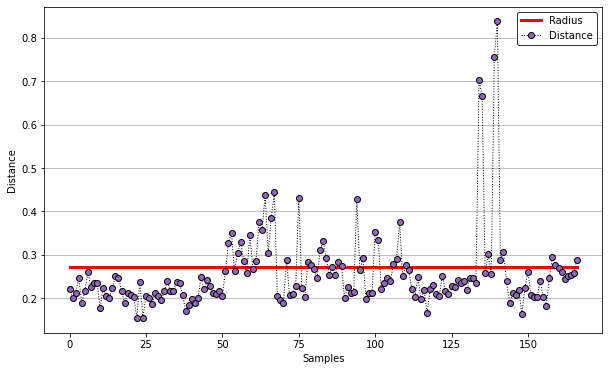

Wall time: 1h 21min 52s


In [10]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
    
    input_shape = (256,256, 3)
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(X_train, X_train,epochs=15,batch_size=16,shuffle=True,validation_data=(x_test, x_test))

    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)

    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-4), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    acc.append(svdd.accuracy)

Epoch 1/15
Epoch 1/15
20/20 [==============================] - 78s 4s/step - loss: 2.8685 - accuracy: 0.0039 - val_loss: 2.8588 - val_accuracy: 0.0039
Epoch 2/15
20/20 [==============================] - 78s 4s/step - loss: 2.8685 - accuracy: 0.0039 - val_loss: 2.8588 - val_accuracy: 0.0039
Epoch 2/15
20/20 [==============================] - 77s 4s/step - loss: 2.8383 - accuracy: 0.0039 - val_loss: 2.7891 - val_accuracy: 0.0039
Epoch 3/15
20/20 [==============================] - 77s 4s/step - loss: 2.8383 - accuracy: 0.0039 - val_loss: 2.7891 - val_accuracy: 0.0039
Epoch 3/15
20/20 [==============================] - 78s 4s/step - loss: 2.7004 - accuracy: 0.0036 - val_loss: 2.5671 - val_accuracy: 3.0088e-04
Epoch 4/15
20/20 [==============================] - 78s 4s/step - loss: 2.7004 - accuracy: 0.0036 - val_loss: 2.5671 - val_accuracy: 3.0088e-04
Epoch 4/15
20/20 [==============================] - 76s 4s/step - loss: 2.4631 - accuracy: 0.0023 - val_loss: 2.3912 - val_accuracy: 0.0144
E

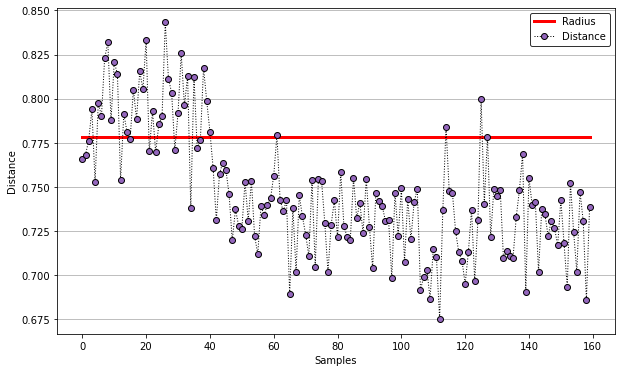

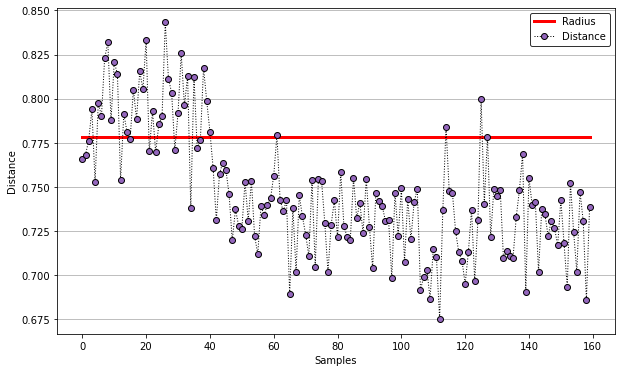

Epoch 1/15
Epoch 1/15
20/20 [==============================] - 78s 4s/step - loss: 3.0236 - accuracy: 0.0000e+00 - val_loss: 2.9929 - val_accuracy: 0.0000e+00
Epoch 2/15
Epoch 2/15
20/20 [==============================] - 77s 4s/step - loss: 2.9482 - accuracy: 0.0000e+00 - val_loss: 2.8889 - val_accuracy: 0.0000e+00
Epoch 3/15
20/20 [==============================] - 77s 4s/step - loss: 2.9482 - accuracy: 0.0000e+00 - val_loss: 2.8889 - val_accuracy: 0.0000e+00
Epoch 3/15
20/20 [==============================] - 76s 4s/step - loss: 2.7833 - accuracy: 0.0000e+00 - val_loss: 2.6399 - val_accuracy: 0.0000e+00
Epoch 4/15
20/20 [==============================] - 76s 4s/step - loss: 2.7833 - accuracy: 0.0000e+00 - val_loss: 2.6399 - val_accuracy: 0.0000e+00
Epoch 4/15
20/20 [==============================] - 77s 4s/step - loss: 2.5272 - accuracy: 0.0507 - val_loss: 2.4465 - val_accuracy: 0.4297
Epoch 5/15
Epoch 5/15
20/20 [==============================] - 76s 4s/step - loss: 2.4328 - accura

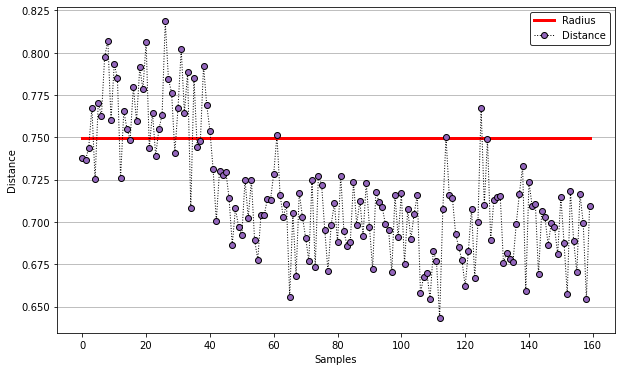

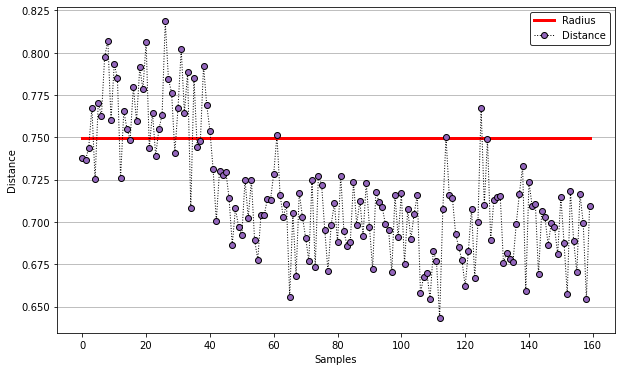

Epoch 1/15
Epoch 1/15
20/20 [==============================] - 78s 4s/step - loss: 2.5060 - accuracy: 0.9961 - val_loss: 2.5041 - val_accuracy: 0.9961
Epoch 2/15
Epoch 2/15
20/20 [==============================] - 77s 4s/step - loss: 2.5031 - accuracy: 0.9961 - val_loss: 2.4978 - val_accuracy: 0.9961
Epoch 3/15
20/20 [==============================] - 77s 4s/step - loss: 2.5031 - accuracy: 0.9961 - val_loss: 2.4978 - val_accuracy: 0.9961
Epoch 3/15
20/20 [==============================] - 78s 4s/step - loss: 2.4888 - accuracy: 0.9961 - val_loss: 2.4703 - val_accuracy: 0.9961
Epoch 4/15
Epoch 4/15
20/20 [==============================] - 77s 4s/step - loss: 2.4442 - accuracy: 0.9961 - val_loss: 2.4125 - val_accuracy: 0.9961
Epoch 5/15
20/20 [==============================] - 77s 4s/step - loss: 2.4442 - accuracy: 0.9961 - val_loss: 2.4125 - val_accuracy: 0.9961
Epoch 5/15
20/20 [==============================] - 77s 4s/step - loss: 2.4130 - accuracy: 0.9661 - val_loss: 2.4217 - val_accu

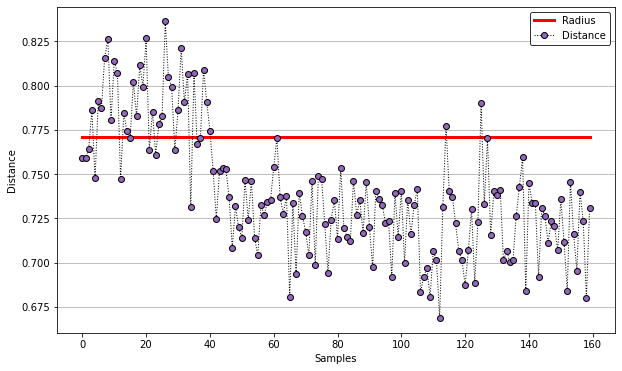

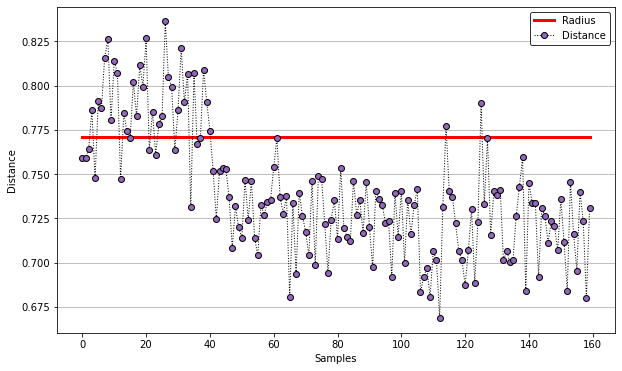

Epoch 1/15
Epoch 1/15
20/20 [==============================] - 79s 4s/step - loss: 2.4764 - accuracy: 0.9844 - val_loss: 2.4744 - val_accuracy: 0.9622
Epoch 2/15
20/20 [==============================] - 79s 4s/step - loss: 2.4764 - accuracy: 0.9844 - val_loss: 2.4744 - val_accuracy: 0.9622
Epoch 2/15
20/20 [==============================] - 77s 4s/step - loss: 2.4676 - accuracy: 0.3793 - val_loss: 2.4610 - val_accuracy: 0.0308
Epoch 3/15
20/20 [==============================] - 77s 4s/step - loss: 2.4676 - accuracy: 0.3793 - val_loss: 2.4610 - val_accuracy: 0.0308
Epoch 3/15
20/20 [==============================] - 77s 4s/step - loss: 2.4506 - accuracy: 0.0187 - val_loss: 2.4422 - val_accuracy: 0.0117
Epoch 4/15
Epoch 4/15
20/20 [==============================] - 77s 4s/step - loss: 2.4307 - accuracy: 0.0116 - val_loss: 2.4154 - val_accuracy: 0.0116
Epoch 5/15
Epoch 5/15
20/20 [==============================] - 78s 4s/step - loss: 2.4081 - accuracy: 0.0113 - val_loss: 2.4136 - val_accu

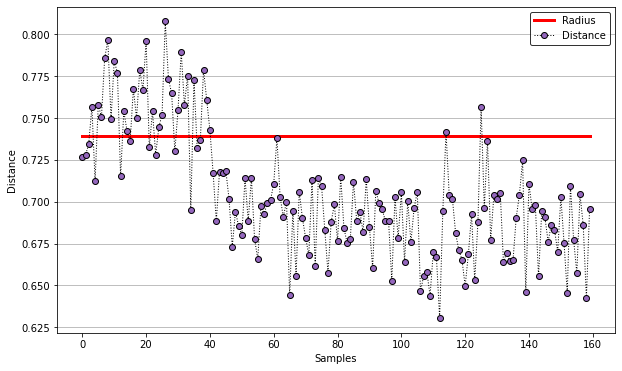

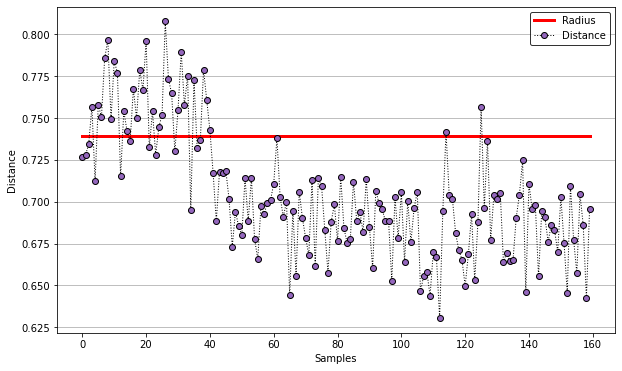

Epoch 1/15
Epoch 1/15
20/20 [==============================] - 80s 4s/step - loss: 2.4313 - accuracy: 0.9922 - val_loss: 2.4223 - val_accuracy: 0.9922
Epoch 2/15
Epoch 2/15
20/20 [==============================] - 77s 4s/step - loss: 2.4150 - accuracy: 0.9402 - val_loss: 2.3991 - val_accuracy: 0.3243
Epoch 3/15
Epoch 3/15
20/20 [==============================] - 77s 4s/step - loss: 2.3990 - accuracy: 0.0959 - val_loss: 2.4038 - val_accuracy: 0.0287
Epoch 4/15
Epoch 4/15
20/20 [==============================] - 77s 4s/step - loss: 2.4286 - accuracy: 0.0175 - val_loss: 2.4485 - val_accuracy: 0.0101
Epoch 5/15
20/20 [==============================] - 77s 4s/step - loss: 2.4286 - accuracy: 0.0175 - val_loss: 2.4485 - val_accuracy: 0.0101
Epoch 5/15
20/20 [==============================] - 77s 4s/step - loss: 2.4549 - accuracy: 0.0063 - val_loss: 2.4387 - val_accuracy: 0.0050
Epoch 6/15
20/20 [==============================] - 77s 4s/step - loss: 2.4549 - accuracy: 0.0063 - val_loss: 2.4387

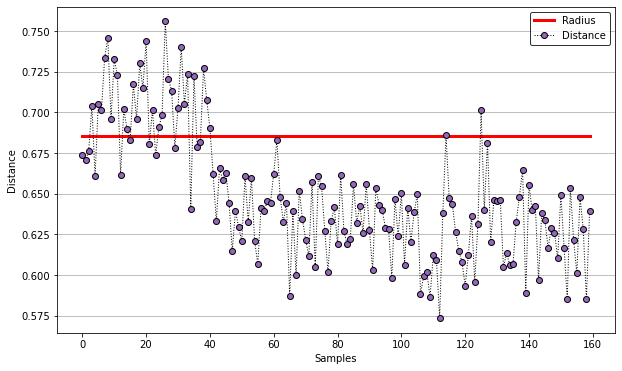

Wall time: 1h 37min 48s


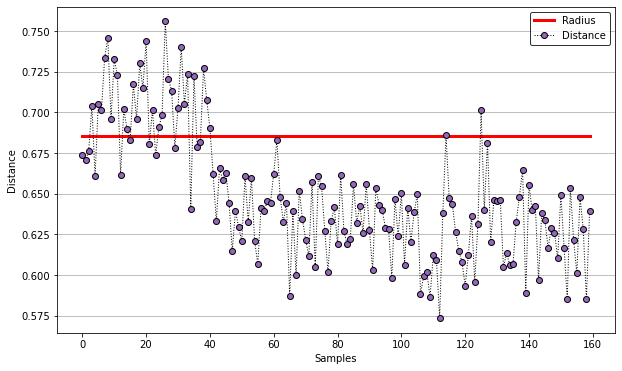

Wall time: 1h 37min 48s


In [11]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
    
    input_shape = (256,256, 3)
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(X_train, X_train,epochs=15,batch_size=16,shuffle=True,validation_data=(x_test, x_test))

    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)

    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-4), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    acc.append(svdd.accuracy)

Epoch 1/15
Epoch 1/15
15/15 [==============================] - 56s 4s/step - loss: 1.7484 - accuracy: 0.0500 - val_loss: 1.6210 - val_accuracy: 0.0513
Epoch 2/15
Epoch 2/15
15/15 [==============================] - 55s 4s/step - loss: 1.5856 - accuracy: 0.1847 - val_loss: 1.5553 - val_accuracy: 0.2780
Epoch 3/15
15/15 [==============================] - 55s 4s/step - loss: 1.5856 - accuracy: 0.1847 - val_loss: 1.5553 - val_accuracy: 0.2780
Epoch 3/15
15/15 [==============================] - 55s 4s/step - loss: 1.5434 - accuracy: 0.2801 - val_loss: 1.5268 - val_accuracy: 0.2801
Epoch 4/15
Epoch 4/15
15/15 [==============================] - 55s 4s/step - loss: 1.5214 - accuracy: 0.2732 - val_loss: 1.5131 - val_accuracy: 0.2683
Epoch 5/15
Epoch 5/15
15/15 [==============================] - 55s 4s/step - loss: 1.5148 - accuracy: 0.3751 - val_loss: 1.5161 - val_accuracy: 0.6169
Epoch 6/15
15/15 [==============================] - 55s 4s/step - loss: 1.5148 - accuracy: 0.3751 - val_loss: 1.5161

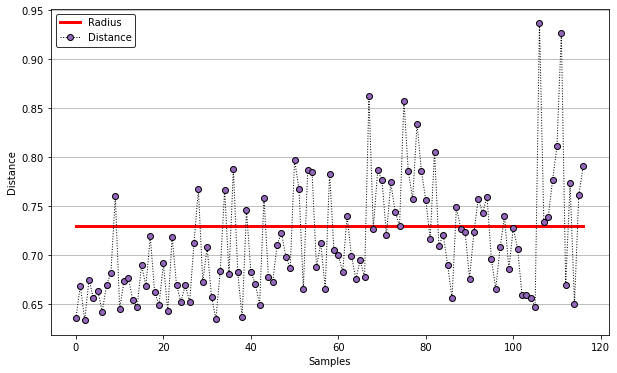

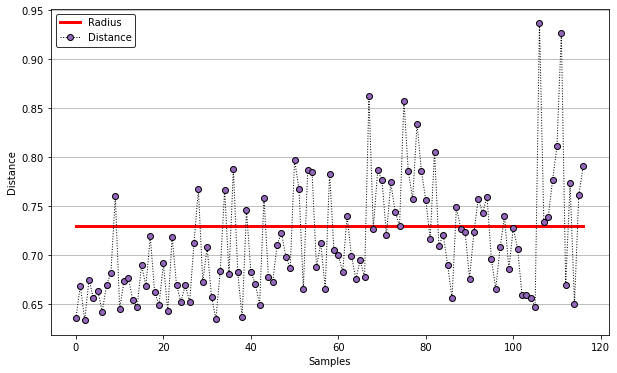

Epoch 1/15
Epoch 1/15
15/15 [==============================] - 56s 4s/step - loss: 1.6051 - accuracy: 0.6692 - val_loss: 1.5307 - val_accuracy: 0.6656
Epoch 2/15
15/15 [==============================] - 56s 4s/step - loss: 1.6051 - accuracy: 0.6692 - val_loss: 1.5307 - val_accuracy: 0.6656
Epoch 2/15
15/15 [==============================] - 56s 4s/step - loss: 1.5188 - accuracy: 0.6648 - val_loss: 1.5163 - val_accuracy: 0.6655
Epoch 3/15
Epoch 3/15
15/15 [==============================] - 55s 4s/step - loss: 1.5145 - accuracy: 0.6647 - val_loss: 1.5169 - val_accuracy: 0.6637
Epoch 4/15
15/15 [==============================] - 55s 4s/step - loss: 1.5145 - accuracy: 0.6647 - val_loss: 1.5169 - val_accuracy: 0.6637
Epoch 4/15
15/15 [==============================] - 55s 4s/step - loss: 1.5170 - accuracy: 0.5207 - val_loss: 1.5241 - val_accuracy: 0.3055
Epoch 5/15
Epoch 5/15
15/15 [==============================] - 56s 4s/step - loss: 1.5295 - accuracy: 0.3011 - val_loss: 1.5390 - val_accu

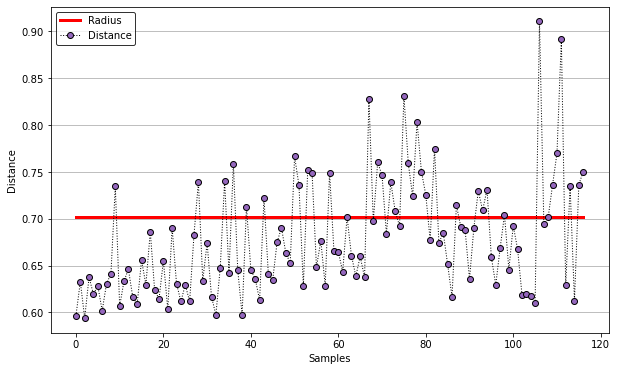

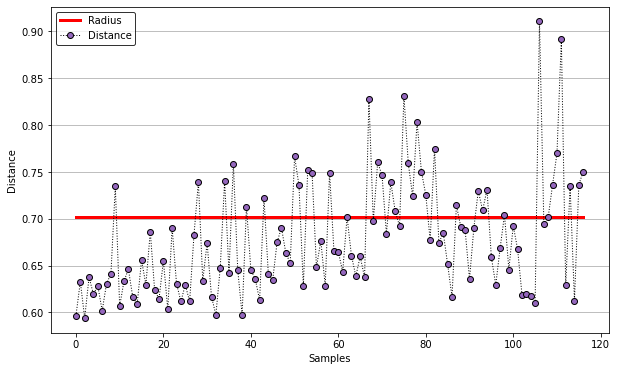

Epoch 1/15
Epoch 1/15
15/15 [==============================] - 56s 4s/step - loss: 1.6631 - accuracy: 0.3631 - val_loss: 1.6243 - val_accuracy: 0.6649
Epoch 2/15
Epoch 2/15
15/15 [==============================] - 56s 4s/step - loss: 1.6183 - accuracy: 0.6643 - val_loss: 1.6077 - val_accuracy: 0.6649
Epoch 3/15
Epoch 3/15
15/15 [==============================] - 55s 4s/step - loss: 1.6084 - accuracy: 0.6643 - val_loss: 1.6019 - val_accuracy: 0.6649
Epoch 4/15
15/15 [==============================] - 55s 4s/step - loss: 1.6084 - accuracy: 0.6643 - val_loss: 1.6019 - val_accuracy: 0.6649
Epoch 4/15
15/15 [==============================] - 55s 4s/step - loss: 1.6012 - accuracy: 0.6643 - val_loss: 1.5891 - val_accuracy: 0.6649
Epoch 5/15
Epoch 5/15
15/15 [==============================] - 55s 4s/step - loss: 1.5807 - accuracy: 0.6606 - val_loss: 1.5587 - val_accuracy: 0.6323
Epoch 6/15
15/15 [==============================] - 55s 4s/step - loss: 1.5807 - accuracy: 0.6606 - val_loss: 1.5587

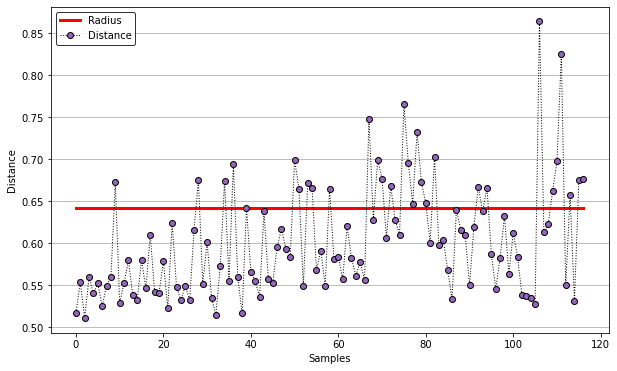

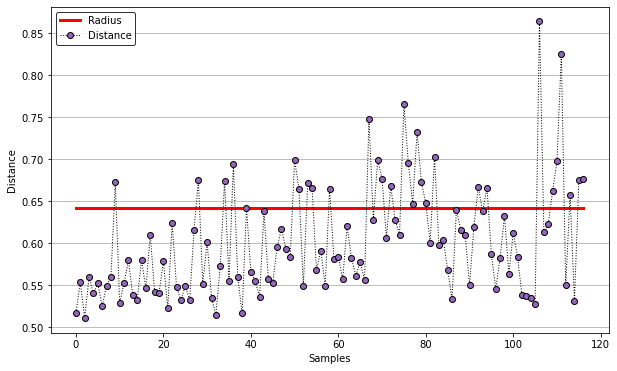

Epoch 1/15
Epoch 1/15
15/15 [==============================] - 56s 4s/step - loss: 1.5438 - accuracy: 0.0498 - val_loss: 1.5254 - val_accuracy: 0.0494
Epoch 2/15
15/15 [==============================] - 56s 4s/step - loss: 1.5438 - accuracy: 0.0498 - val_loss: 1.5254 - val_accuracy: 0.0494
Epoch 2/15
15/15 [==============================] - 56s 4s/step - loss: 1.5243 - accuracy: 0.0498 - val_loss: 1.5251 - val_accuracy: 0.0494
Epoch 3/15
Epoch 3/15
15/15 [==============================] - 55s 4s/step - loss: 1.5241 - accuracy: 0.0498 - val_loss: 1.5227 - val_accuracy: 0.0494
Epoch 4/15
15/15 [==============================] - 55s 4s/step - loss: 1.5241 - accuracy: 0.0498 - val_loss: 1.5227 - val_accuracy: 0.0494
Epoch 4/15
15/15 [==============================] - 56s 4s/step - loss: 1.5195 - accuracy: 0.0498 - val_loss: 1.5163 - val_accuracy: 0.0494
Epoch 5/15
15/15 [==============================] - 56s 4s/step - loss: 1.5195 - accuracy: 0.0498 - val_loss: 1.5163 - val_accuracy: 0.049

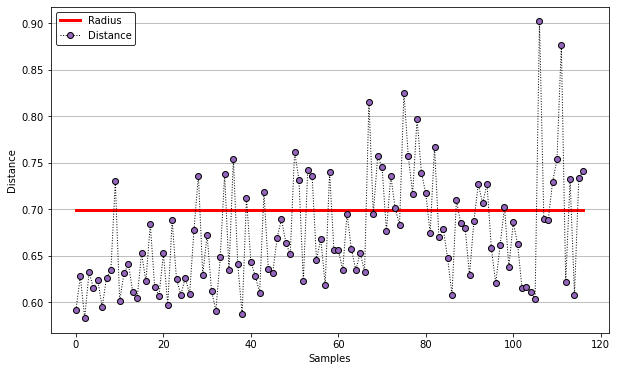

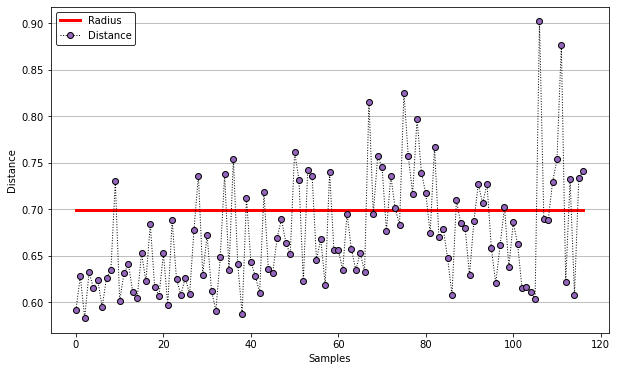

Epoch 1/15
Epoch 1/15
15/15 [==============================] - 57s 4s/step - loss: 1.6922 - accuracy: 0.6644 - val_loss: 1.6726 - val_accuracy: 0.6673
Epoch 2/15
Epoch 2/15
15/15 [==============================] - 57s 4s/step - loss: 1.6623 - accuracy: 0.6650 - val_loss: 1.6539 - val_accuracy: 0.6692
Epoch 3/15
15/15 [==============================] - 57s 4s/step - loss: 1.6623 - accuracy: 0.6650 - val_loss: 1.6539 - val_accuracy: 0.6692
Epoch 3/15
15/15 [==============================] - 56s 4s/step - loss: 1.6403 - accuracy: 0.6658 - val_loss: 1.6219 - val_accuracy: 0.6692
Epoch 4/15
15/15 [==============================] - 56s 4s/step - loss: 1.6403 - accuracy: 0.6658 - val_loss: 1.6219 - val_accuracy: 0.6692
Epoch 4/15
15/15 [==============================] - 56s 4s/step - loss: 1.5958 - accuracy: 0.6654 - val_loss: 1.5633 - val_accuracy: 0.6677
Epoch 5/15
Epoch 5/15
15/15 [==============================] - 55s 4s/step - loss: 1.5408 - accuracy: 0.6639 - val_loss: 1.5318 - val_accu

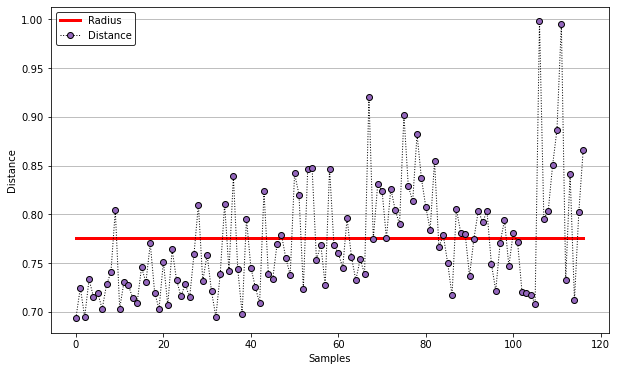

Wall time: 1h 10min 34s


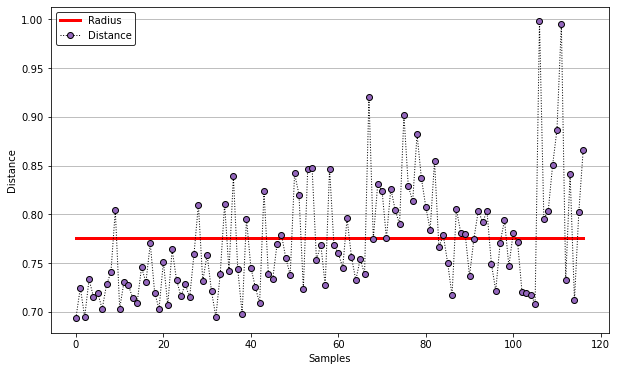

Wall time: 1h 10min 34s


In [12]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
    
    input_shape = (256,256, 3)
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(X_train, X_train,epochs=15,batch_size=16,shuffle=True,validation_data=(x_test, x_test))

    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)

    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-3), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    acc.append(svdd.accuracy)

Epoch 1/15
Epoch 1/15
4/4 [==============================] - 15s 4s/step - loss: 0.6887 - accuracy: 0.1699 - val_loss: 0.6719 - val_accuracy: 0.1750
Epoch 2/15
4/4 [==============================] - 15s 4s/step - loss: 0.6887 - accuracy: 0.1699 - val_loss: 0.6719 - val_accuracy: 0.1750
Epoch 2/15
4/4 [==============================] - 14s 4s/step - loss: 0.6718 - accuracy: 0.1699 - val_loss: 0.6610 - val_accuracy: 0.1750
Epoch 3/15
4/4 [==============================] - 14s 4s/step - loss: 0.6718 - accuracy: 0.1699 - val_loss: 0.6610 - val_accuracy: 0.1750
Epoch 3/15
4/4 [==============================] - 14s 4s/step - loss: 0.6639 - accuracy: 0.1699 - val_loss: 0.6573 - val_accuracy: 0.1750
Epoch 4/15
Epoch 4/15
4/4 [==============================] - 14s 4s/step - loss: 0.6611 - accuracy: 0.1699 - val_loss: 0.6557 - val_accuracy: 0.1750
Epoch 5/15
Epoch 5/15
4/4 [==============================] - 14s 4s/step - loss: 0.6597 - accuracy: 0.1699 - val_loss: 0.6547 - val_accuracy: 0.1750
E

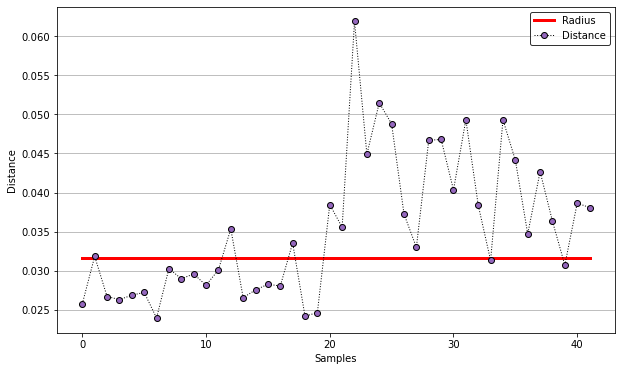

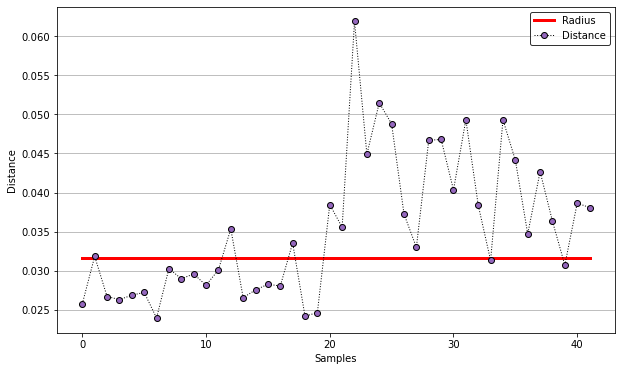

Epoch 1/15
Epoch 1/15
4/4 [==============================] - 15s 4s/step - loss: 0.6733 - accuracy: 0.0544 - val_loss: 0.6697 - val_accuracy: 0.0530
Epoch 2/15
4/4 [==============================] - 15s 4s/step - loss: 0.6733 - accuracy: 0.0544 - val_loss: 0.6697 - val_accuracy: 0.0530
Epoch 2/15
4/4 [==============================] - 14s 4s/step - loss: 0.6726 - accuracy: 0.0544 - val_loss: 0.6690 - val_accuracy: 0.0530
Epoch 3/15
Epoch 3/15
4/4 [==============================] - 15s 4s/step - loss: 0.6720 - accuracy: 0.0544 - val_loss: 0.6684 - val_accuracy: 0.0530
Epoch 4/15
4/4 [==============================] - 15s 4s/step - loss: 0.6720 - accuracy: 0.0544 - val_loss: 0.6684 - val_accuracy: 0.0530
Epoch 4/15
4/4 [==============================] - 15s 4s/step - loss: 0.6715 - accuracy: 0.0544 - val_loss: 0.6678 - val_accuracy: 0.0530
Epoch 5/15
4/4 [==============================] - 15s 4s/step - loss: 0.6715 - accuracy: 0.0544 - val_loss: 0.6678 - val_accuracy: 0.0530
Epoch 5/15
4

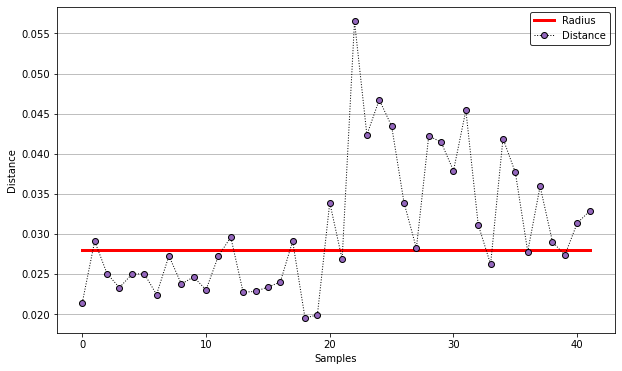

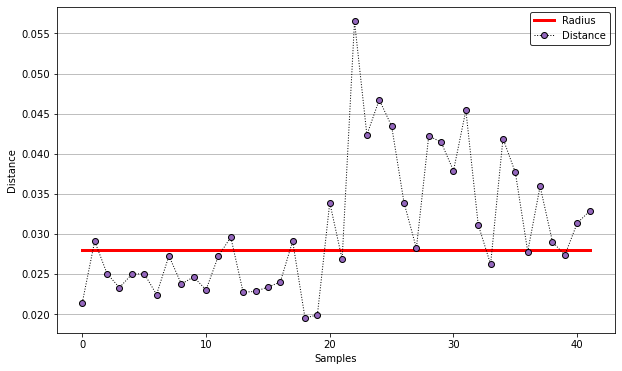

Epoch 1/15
Epoch 1/15
4/4 [==============================] - 15s 4s/step - loss: 0.6753 - accuracy: 0.7719 - val_loss: 0.6693 - val_accuracy: 0.7719
Epoch 2/15
4/4 [==============================] - 15s 4s/step - loss: 0.6753 - accuracy: 0.7719 - val_loss: 0.6693 - val_accuracy: 0.7719
Epoch 2/15
4/4 [==============================] - 15s 4s/step - loss: 0.6653 - accuracy: 0.7718 - val_loss: 0.6655 - val_accuracy: 0.7719
Epoch 3/15
4/4 [==============================] - 15s 4s/step - loss: 0.6653 - accuracy: 0.7718 - val_loss: 0.6655 - val_accuracy: 0.7719
Epoch 3/15
4/4 [==============================] - 14s 4s/step - loss: 0.6625 - accuracy: 0.7718 - val_loss: 0.6638 - val_accuracy: 0.7719
Epoch 4/15
4/4 [==============================] - 14s 4s/step - loss: 0.6625 - accuracy: 0.7718 - val_loss: 0.6638 - val_accuracy: 0.7719
Epoch 4/15
4/4 [==============================] - 15s 4s/step - loss: 0.6610 - accuracy: 0.7718 - val_loss: 0.6626 - val_accuracy: 0.7719
Epoch 5/15
4/4 [=======

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


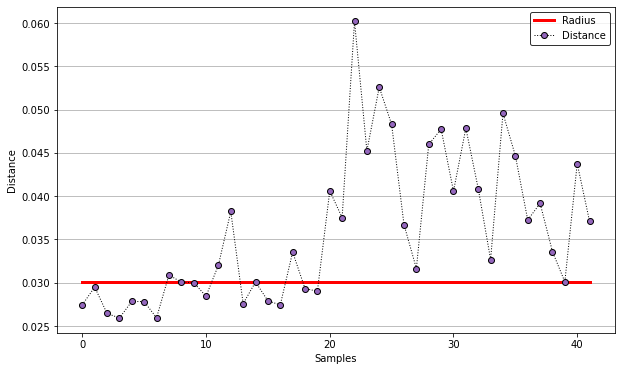



*** Fitting of the SVDD model is completed. ***

running time         = 0.0156 seconds
kernel function      = rbf
iterations           = 7
radius               = 0.0301
number of samples    = 60
number of features   = 8192
number of SVs        = 60
ratio of SVs         = 100.0000 %
accuracy             = 51.6667 %




*** Prediction of the provided data is completed. ***

running time         = 0.0156 seconds
number of samples    = 12
number of alarm      = 2
accuracy             = 83.3333 %




*** Prediction of the provided data is completed. ***

running time         = 0.0000 seconds
number of samples    = 30
number of alarm      = 24
accuracy             = 80.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.0156 seconds
number of samples    = 42
number of alarm      = 26
accuracy             = 80.9524 %




C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


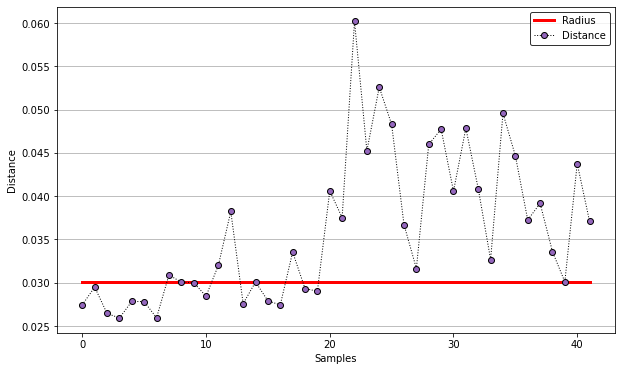

Epoch 1/15
Epoch 1/15
4/4 [==============================] - 15s 4s/step - loss: 0.7662 - accuracy: 0.0505 - val_loss: 0.7454 - val_accuracy: 0.0500
Epoch 2/15
Epoch 2/15
4/4 [==============================] - 15s 4s/step - loss: 0.7363 - accuracy: 0.0505 - val_loss: 0.7182 - val_accuracy: 0.0500
Epoch 3/15
4/4 [==============================] - 15s 4s/step - loss: 0.7363 - accuracy: 0.0505 - val_loss: 0.7182 - val_accuracy: 0.0500
Epoch 3/15
4/4 [==============================] - 14s 4s/step - loss: 0.7108 - accuracy: 0.0505 - val_loss: 0.6961 - val_accuracy: 0.0500
Epoch 4/15
Epoch 4/15
4/4 [==============================] - 14s 4s/step - loss: 0.6909 - accuracy: 0.0505 - val_loss: 0.6799 - val_accuracy: 0.0500
Epoch 5/15
Epoch 5/15
4/4 [==============================] - 14s 4s/step - loss: 0.6770 - accuracy: 0.0505 - val_loss: 0.6696 - val_accuracy: 0.0500
Epoch 6/15
4/4 [==============================] - 14s 4s/step - loss: 0.6770 - accuracy: 0.0505 - val_loss: 0.6696 - val_accurac

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


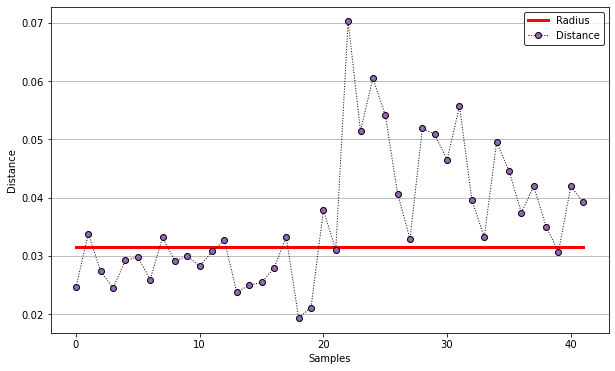



*** Fitting of the SVDD model is completed. ***

running time         = 0.0312 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.0315
number of samples    = 60
number of features   = 8192
number of SVs        = 53
ratio of SVs         = 88.3333 %
accuracy             = 65.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.0000 seconds
number of samples    = 12
number of alarm      = 2
accuracy             = 83.3333 %




*** Prediction of the provided data is completed. ***

running time         = 0.0000 seconds
number of samples    = 30
number of alarm      = 22
accuracy             = 73.3333 %




*** Prediction of the provided data is completed. ***

running time         = 0.0156 seconds
number of samples    = 42
number of alarm      = 24
accuracy             = 76.1905 %




C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


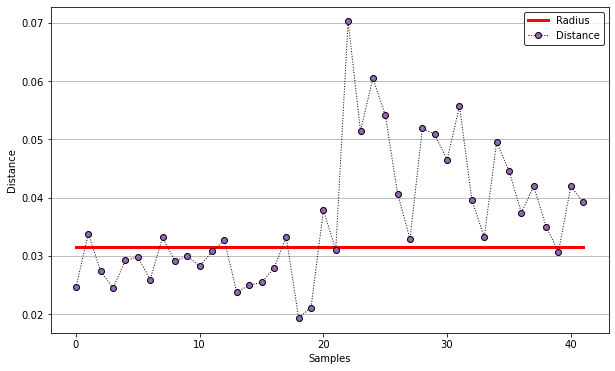

Epoch 1/15
Epoch 1/15
4/4 [==============================] - 15s 4s/step - loss: 0.6439 - accuracy: 0.7719 - val_loss: 0.6427 - val_accuracy: 0.7682
Epoch 2/15
4/4 [==============================] - 15s 4s/step - loss: 0.6439 - accuracy: 0.7719 - val_loss: 0.6427 - val_accuracy: 0.7682
Epoch 2/15
4/4 [==============================] - 15s 4s/step - loss: 0.6439 - accuracy: 0.7719 - val_loss: 0.6427 - val_accuracy: 0.7682
Epoch 3/15
4/4 [==============================] - 15s 4s/step - loss: 0.6439 - accuracy: 0.7719 - val_loss: 0.6427 - val_accuracy: 0.7682
Epoch 3/15
4/4 [==============================] - 15s 4s/step - loss: 0.6438 - accuracy: 0.7719 - val_loss: 0.6426 - val_accuracy: 0.7682
Epoch 4/15
4/4 [==============================] - 15s 4s/step - loss: 0.6438 - accuracy: 0.7719 - val_loss: 0.6426 - val_accuracy: 0.7682
Epoch 4/15
4/4 [==============================] - 15s 4s/step - loss: 0.6437 - accuracy: 0.7719 - val_loss: 0.6423 - val_accuracy: 0.7682
Epoch 5/15
Epoch 5/15
4

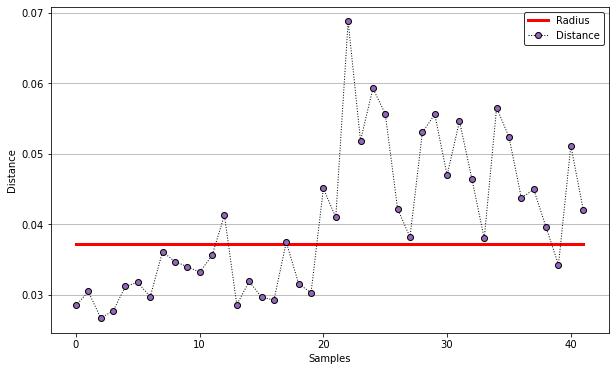

Wall time: 18min 31s


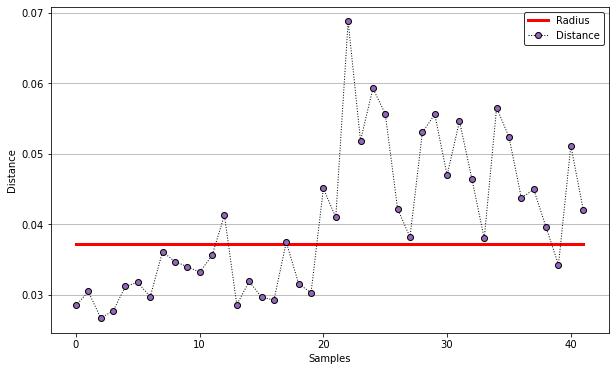

Wall time: 18min 31s


In [13]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
    
    input_shape = (256,256, 3)
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(X_train, X_train,epochs=15,batch_size=16,shuffle=True,validation_data=(x_test, x_test))

    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)

    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-4), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    acc.append(svdd.accuracy)

Epoch 1/15
Epoch 1/15
14/14 [==============================] - 52s 4s/step - loss: 1.0280 - accuracy: 0.9564 - val_loss: 0.9909 - val_accuracy: 0.9569
Epoch 2/15
Epoch 2/15
14/14 [==============================] - 51s 4s/step - loss: 0.9823 - accuracy: 0.9577 - val_loss: 0.9813 - val_accuracy: 0.9607
Epoch 3/15
Epoch 3/15
14/14 [==============================] - 51s 4s/step - loss: 0.9798 - accuracy: 0.9603 - val_loss: 0.9795 - val_accuracy: 0.9607
Epoch 4/15
Epoch 4/15
14/14 [==============================] - 51s 4s/step - loss: 0.9779 - accuracy: 0.9603 - val_loss: 0.9788 - val_accuracy: 0.9607
Epoch 5/15
14/14 [==============================] - 51s 4s/step - loss: 0.9779 - accuracy: 0.9603 - val_loss: 0.9788 - val_accuracy: 0.9607
Epoch 5/15
14/14 [==============================] - 51s 4s/step - loss: 0.9780 - accuracy: 0.9603 - val_loss: 0.9790 - val_accuracy: 0.9607
Epoch 6/15
14/14 [==============================] - 51s 4s/step - loss: 0.9780 - accuracy: 0.9603 - val_loss: 0.9790

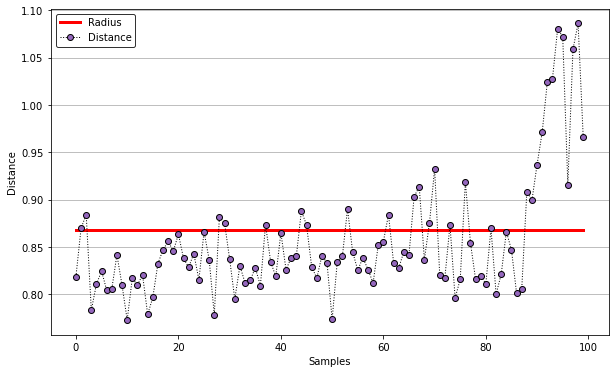

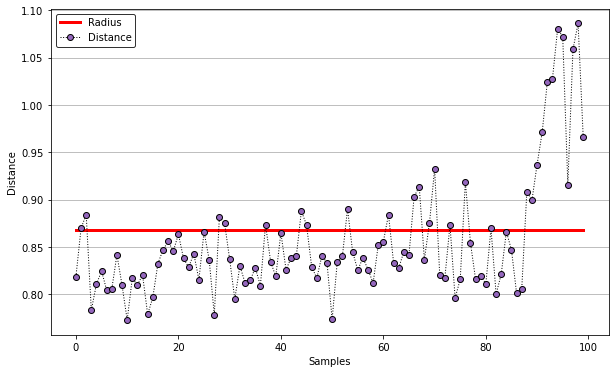

Epoch 1/15
Epoch 1/15
14/14 [==============================] - 53s 4s/step - loss: 1.0679 - accuracy: 0.3236 - val_loss: 1.0098 - val_accuracy: 0.9523
Epoch 2/15
Epoch 2/15
14/14 [==============================] - 51s 4s/step - loss: 0.9945 - accuracy: 0.9526 - val_loss: 0.9806 - val_accuracy: 0.9523
Epoch 3/15
Epoch 3/15
14/14 [==============================] - 51s 4s/step - loss: 0.9804 - accuracy: 0.9526 - val_loss: 0.9764 - val_accuracy: 0.9523
Epoch 4/15
14/14 [==============================] - 51s 4s/step - loss: 0.9804 - accuracy: 0.9526 - val_loss: 0.9764 - val_accuracy: 0.9523
Epoch 4/15
14/14 [==============================] - 51s 4s/step - loss: 0.9789 - accuracy: 0.9526 - val_loss: 0.9774 - val_accuracy: 0.9523
Epoch 5/15
14/14 [==============================] - 51s 4s/step - loss: 0.9789 - accuracy: 0.9526 - val_loss: 0.9774 - val_accuracy: 0.9523
Epoch 5/15
14/14 [==============================] - 51s 4s/step - loss: 0.9795 - accuracy: 0.9526 - val_loss: 0.9767 - val_accu

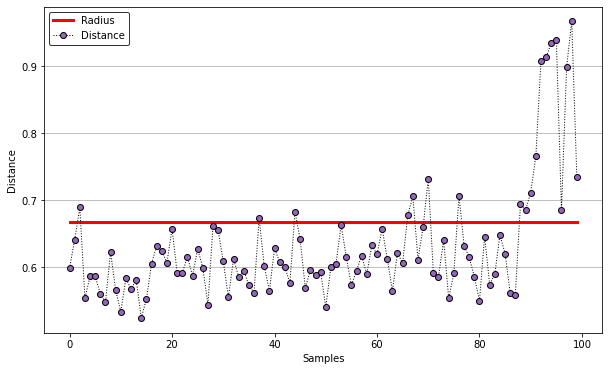

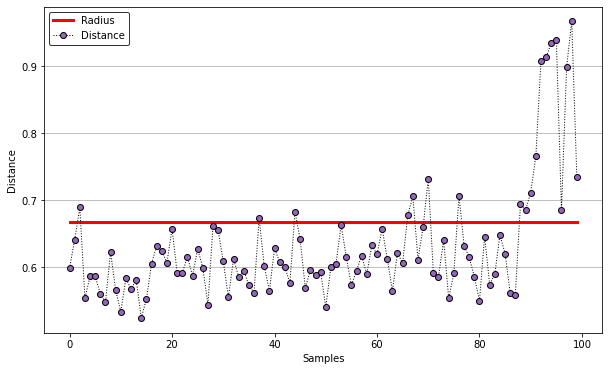

Epoch 1/15
Epoch 1/15
14/14 [==============================] - 52s 4s/step - loss: 1.0359 - accuracy: 0.0115 - val_loss: 0.9938 - val_accuracy: 0.0139
Epoch 2/15
14/14 [==============================] - 52s 4s/step - loss: 1.0359 - accuracy: 0.0115 - val_loss: 0.9938 - val_accuracy: 0.0139
Epoch 2/15
14/14 [==============================] - 51s 4s/step - loss: 0.9843 - accuracy: 0.7925 - val_loss: 0.9781 - val_accuracy: 0.9561
Epoch 3/15
14/14 [==============================] - 51s 4s/step - loss: 0.9843 - accuracy: 0.7925 - val_loss: 0.9781 - val_accuracy: 0.9561
Epoch 3/15
14/14 [==============================] - 51s 4s/step - loss: 0.9806 - accuracy: 0.9553 - val_loss: 0.9782 - val_accuracy: 0.9245
Epoch 4/15
14/14 [==============================] - 51s 4s/step - loss: 0.9806 - accuracy: 0.9553 - val_loss: 0.9782 - val_accuracy: 0.9245
Epoch 4/15
14/14 [==============================] - 53s 4s/step - loss: 0.9798 - accuracy: 0.8620 - val_loss: 0.9790 - val_accuracy: 0.8155
Epoch 5/1

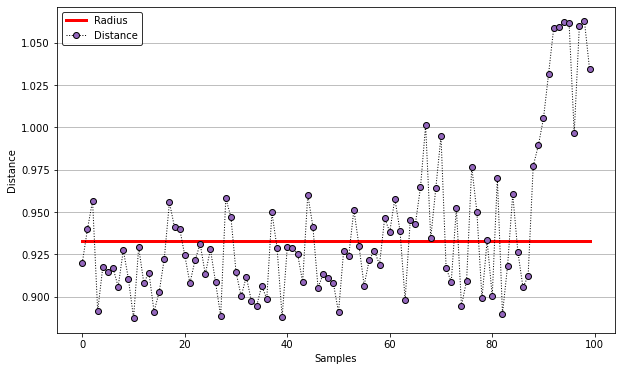

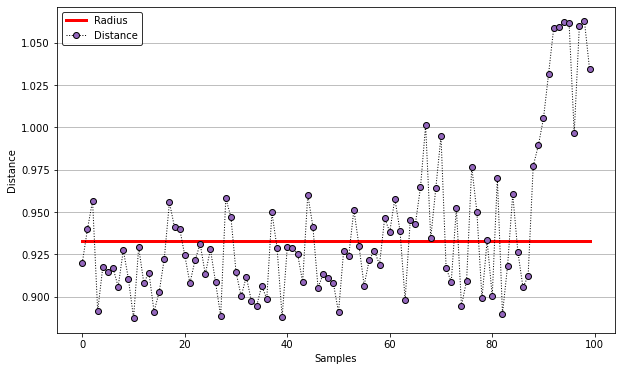

Epoch 1/15
Epoch 1/15
14/14 [==============================] - 52s 4s/step - loss: 1.0157 - accuracy: 0.1787 - val_loss: 0.9810 - val_accuracy: 0.9606
Epoch 2/15
Epoch 2/15
14/14 [==============================] - 52s 4s/step - loss: 0.9777 - accuracy: 0.9603 - val_loss: 0.9772 - val_accuracy: 0.9606
Epoch 3/15
Epoch 3/15
14/14 [==============================] - 51s 4s/step - loss: 0.9773 - accuracy: 0.9603 - val_loss: 0.9785 - val_accuracy: 0.9606
Epoch 4/15
Epoch 4/15
14/14 [==============================] - 51s 4s/step - loss: 0.9790 - accuracy: 0.9603 - val_loss: 0.9796 - val_accuracy: 0.9606
Epoch 5/15
Epoch 5/15
14/14 [==============================] - 51s 4s/step - loss: 0.9789 - accuracy: 0.9603 - val_loss: 0.9785 - val_accuracy: 0.9606
Epoch 6/15
Epoch 6/15
14/14 [==============================] - 53s 4s/step - loss: 0.9780 - accuracy: 0.9603 - val_loss: 0.9780 - val_accuracy: 0.9606
Epoch 7/15
14/14 [==============================] - 53s 4s/step - loss: 0.9780 - accuracy: 0.9

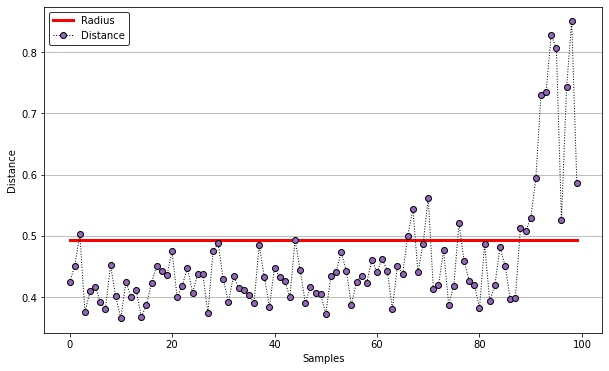

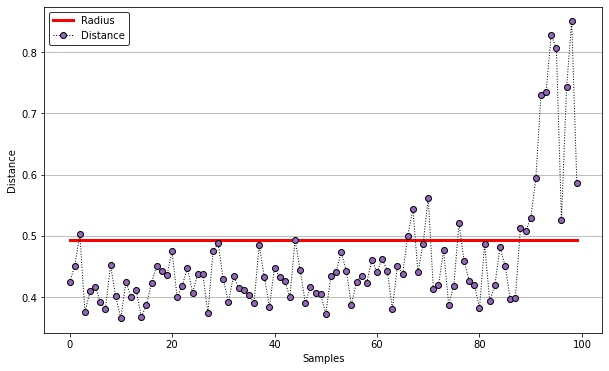

Epoch 1/15
Epoch 1/15
14/14 [==============================] - 53s 4s/step - loss: 1.2982 - accuracy: 0.0040 - val_loss: 1.1723 - val_accuracy: 0.0040
Epoch 2/15
14/14 [==============================] - 53s 4s/step - loss: 1.2982 - accuracy: 0.0040 - val_loss: 1.1723 - val_accuracy: 0.0040
Epoch 2/15
14/14 [==============================] - 52s 4s/step - loss: 1.1004 - accuracy: 0.0040 - val_loss: 1.0266 - val_accuracy: 0.0040
Epoch 3/15
14/14 [==============================] - 52s 4s/step - loss: 1.1004 - accuracy: 0.0040 - val_loss: 1.0266 - val_accuracy: 0.0040
Epoch 3/15
14/14 [==============================] - 52s 4s/step - loss: 0.9997 - accuracy: 0.3839 - val_loss: 0.9789 - val_accuracy: 0.9524
Epoch 4/15
14/14 [==============================] - 52s 4s/step - loss: 0.9997 - accuracy: 0.3839 - val_loss: 0.9789 - val_accuracy: 0.9524
Epoch 4/15
14/14 [==============================] - 51s 4s/step - loss: 0.9778 - accuracy: 0.9561 - val_loss: 0.9769 - val_accuracy: 0.9563
Epoch 5/1

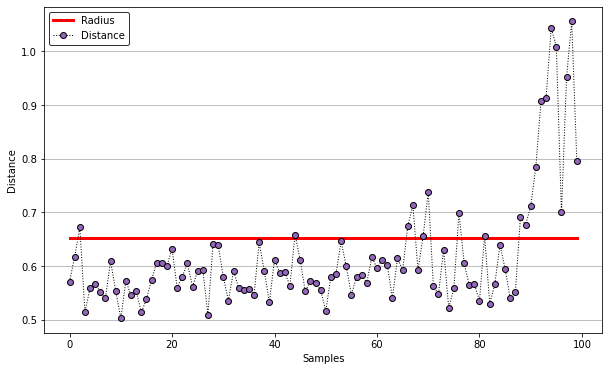

Wall time: 1h 5min 33s


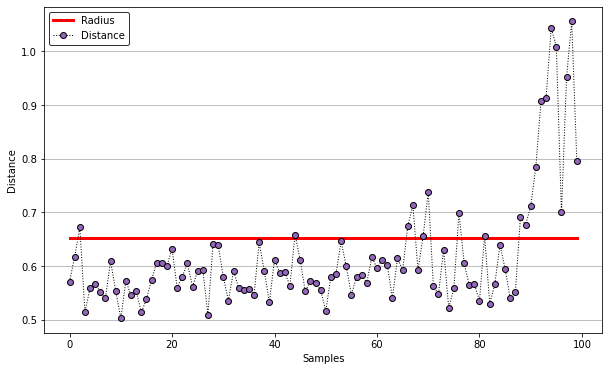

Wall time: 1h 5min 33s


In [14]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
    
    input_shape = (256,256, 3)
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(X_train, X_train,epochs=15,batch_size=16,shuffle=True,validation_data=(x_test, x_test))

    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)

    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-4), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    acc.append(svdd.accuracy)

Epoch 1/15
Epoch 1/15
16/16 [==============================] - 60s 4s/step - loss: 1.7463 - accuracy: 0.0014 - val_loss: 1.6500 - val_accuracy: 0.0039
Epoch 2/15
16/16 [==============================] - 60s 4s/step - loss: 1.7463 - accuracy: 0.0014 - val_loss: 1.6500 - val_accuracy: 0.0039
Epoch 2/15
16/16 [==============================] - 60s 4s/step - loss: 1.6316 - accuracy: 0.0063 - val_loss: 1.6206 - val_accuracy: 0.0078
Epoch 3/15
Epoch 3/15
16/16 [==============================] - 60s 4s/step - loss: 1.6159 - accuracy: 0.0571 - val_loss: 1.6114 - val_accuracy: 0.9311
Epoch 4/15
16/16 [==============================] - 60s 4s/step - loss: 1.6159 - accuracy: 0.0571 - val_loss: 1.6114 - val_accuracy: 0.9311
Epoch 4/15
16/16 [==============================] - 60s 4s/step - loss: 1.6070 - accuracy: 0.9825 - val_loss: 1.6020 - val_accuracy: 0.9911
Epoch 5/15
16/16 [==============================] - 60s 4s/step - loss: 1.6070 - accuracy: 0.9825 - val_loss: 1.6020 - val_accuracy: 0.991

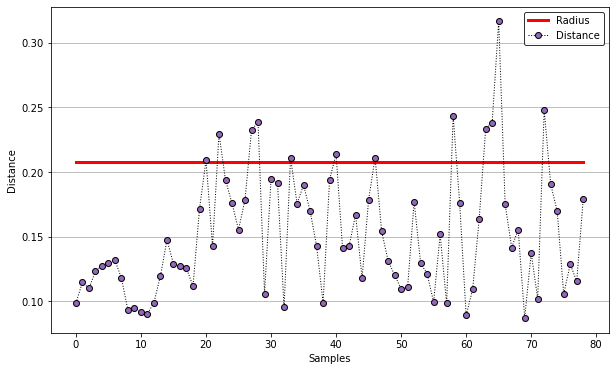

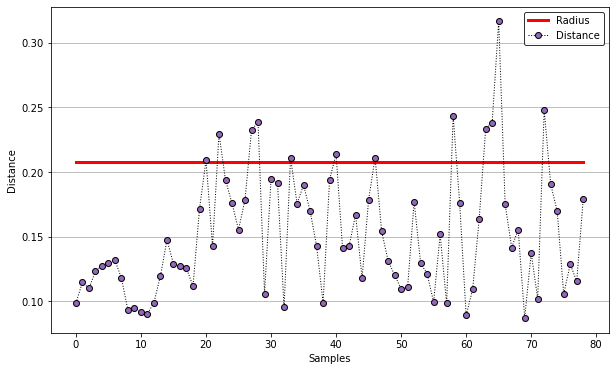

Epoch 1/15
Epoch 1/15
16/16 [==============================] - 60s 4s/step - loss: 1.6335 - accuracy: 0.9961 - val_loss: 1.6265 - val_accuracy: 0.9961
Epoch 2/15
16/16 [==============================] - 60s 4s/step - loss: 1.6335 - accuracy: 0.9961 - val_loss: 1.6265 - val_accuracy: 0.9961
Epoch 2/15
16/16 [==============================] - 60s 4s/step - loss: 1.6243 - accuracy: 0.9961 - val_loss: 1.6245 - val_accuracy: 0.9961
Epoch 3/15
16/16 [==============================] - 60s 4s/step - loss: 1.6243 - accuracy: 0.9961 - val_loss: 1.6245 - val_accuracy: 0.9961
Epoch 3/15
16/16 [==============================] - 60s 4s/step - loss: 1.6222 - accuracy: 0.9961 - val_loss: 1.6230 - val_accuracy: 0.9961
Epoch 4/15
16/16 [==============================] - 60s 4s/step - loss: 1.6222 - accuracy: 0.9961 - val_loss: 1.6230 - val_accuracy: 0.9961
Epoch 4/15
16/16 [==============================] - 59s 4s/step - loss: 1.6221 - accuracy: 0.9961 - val_loss: 1.6246 - val_accuracy: 0.9961
Epoch 5/1

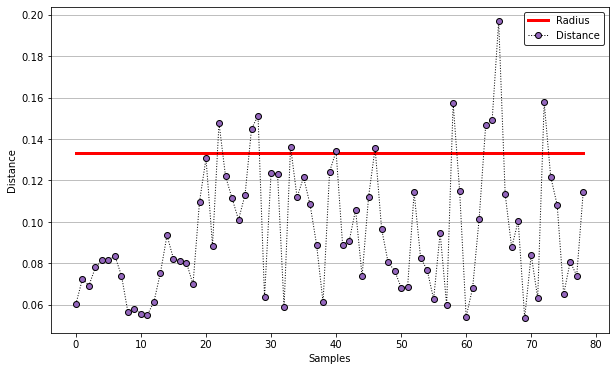

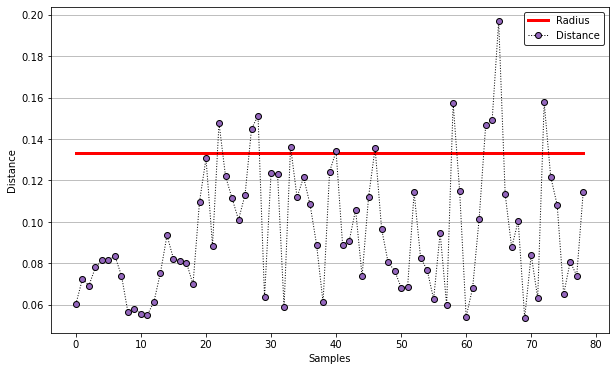

Epoch 1/15
Epoch 1/15
16/16 [==============================] - 60s 4s/step - loss: 1.6054 - accuracy: 1.0000 - val_loss: 1.6036 - val_accuracy: 1.0000
Epoch 2/15
Epoch 2/15
16/16 [==============================] - 61s 4s/step - loss: 1.6011 - accuracy: 0.9994 - val_loss: 1.5986 - val_accuracy: 0.9965
Epoch 3/15
Epoch 3/15
16/16 [==============================] - 70s 4s/step - loss: 1.5974 - accuracy: 0.9963 - val_loss: 1.5984 - val_accuracy: 0.9962
Epoch 4/15
16/16 [==============================] - 70s 4s/step - loss: 1.5974 - accuracy: 0.9963 - val_loss: 1.5984 - val_accuracy: 0.9962
Epoch 4/15
16/16 [==============================] - 60s 4s/step - loss: 1.6032 - accuracy: 0.9962 - val_loss: 1.6126 - val_accuracy: 0.9962
Epoch 5/15
16/16 [==============================] - 60s 4s/step - loss: 1.6032 - accuracy: 0.9962 - val_loss: 1.6126 - val_accuracy: 0.9962
Epoch 5/15
16/16 [==============================] - 61s 4s/step - loss: 1.6210 - accuracy: 0.9962 - val_loss: 1.6296 - val_accu

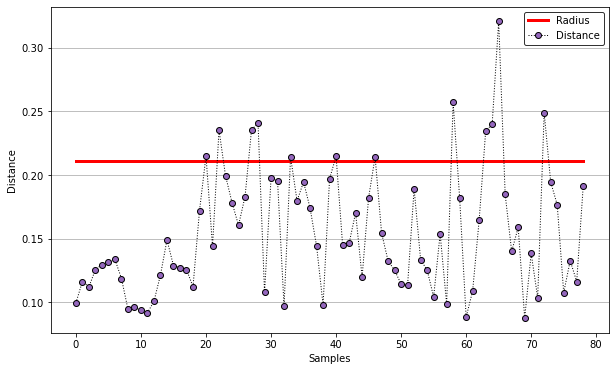

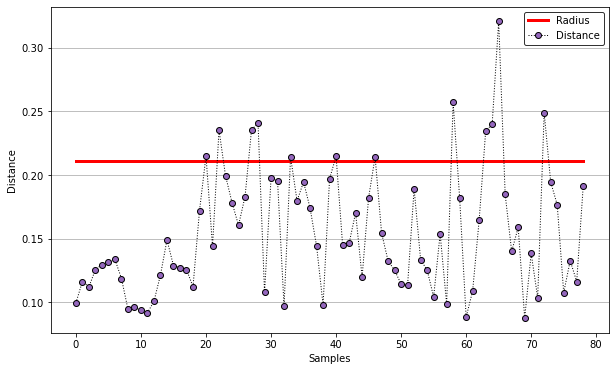

Epoch 1/15
Epoch 1/15
16/16 [==============================] - 62s 4s/step - loss: 1.8610 - accuracy: 0.0000e+00 - val_loss: 1.7699 - val_accuracy: 0.0000e+00
Epoch 2/15
16/16 [==============================] - 62s 4s/step - loss: 1.8610 - accuracy: 0.0000e+00 - val_loss: 1.7699 - val_accuracy: 0.0000e+00
Epoch 2/15
16/16 [==============================] - 61s 4s/step - loss: 1.7365 - accuracy: 0.0000e+00 - val_loss: 1.7062 - val_accuracy: 0.0000e+00
Epoch 3/15
Epoch 3/15
16/16 [==============================] - 60s 4s/step - loss: 1.6854 - accuracy: 0.0000e+00 - val_loss: 1.6541 - val_accuracy: 0.0000e+00
Epoch 4/15
16/16 [==============================] - 60s 4s/step - loss: 1.6854 - accuracy: 0.0000e+00 - val_loss: 1.6541 - val_accuracy: 0.0000e+00
Epoch 4/15
16/16 [==============================] - 60s 4s/step - loss: 1.6285 - accuracy: 0.3744 - val_loss: 1.6025 - val_accuracy: 0.9043
Epoch 5/15
16/16 [==============================] - 60s 4s/step - loss: 1.6285 - accuracy: 0.3744 

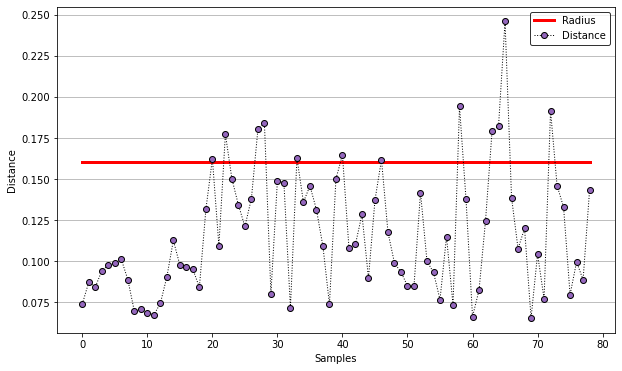

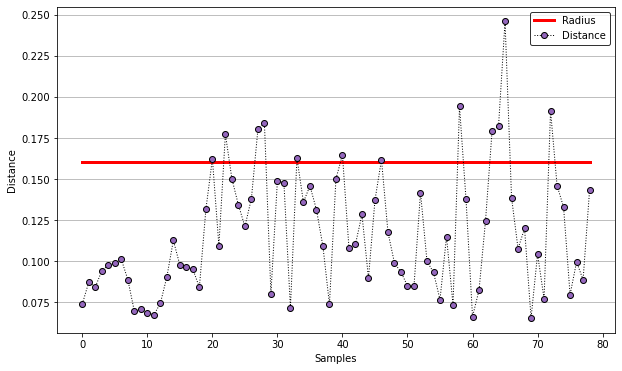

Epoch 1/15
Epoch 1/15
16/16 [==============================] - 61s 4s/step - loss: 1.8469 - accuracy: 1.0000 - val_loss: 1.7297 - val_accuracy: 1.0000
Epoch 2/15
16/16 [==============================] - 61s 4s/step - loss: 1.8469 - accuracy: 1.0000 - val_loss: 1.7297 - val_accuracy: 1.0000
Epoch 2/15
16/16 [==============================] - 61s 4s/step - loss: 1.7148 - accuracy: 1.0000 - val_loss: 1.7076 - val_accuracy: 1.0000
Epoch 3/15
16/16 [==============================] - 61s 4s/step - loss: 1.7148 - accuracy: 1.0000 - val_loss: 1.7076 - val_accuracy: 1.0000
Epoch 3/15
16/16 [==============================] - 60s 4s/step - loss: 1.7078 - accuracy: 1.0000 - val_loss: 1.7031 - val_accuracy: 1.0000
Epoch 4/15
Epoch 4/15
16/16 [==============================] - 60s 4s/step - loss: 1.6949 - accuracy: 1.0000 - val_loss: 1.6783 - val_accuracy: 1.0000
Epoch 5/15
16/16 [==============================] - 60s 4s/step - loss: 1.6949 - accuracy: 1.0000 - val_loss: 1.6783 - val_accuracy: 1.000

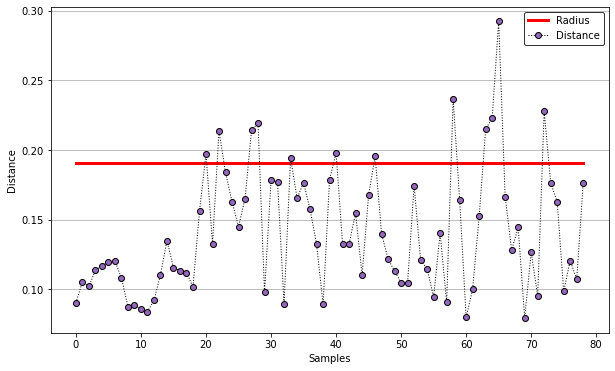

Wall time: 1h 16min 23s


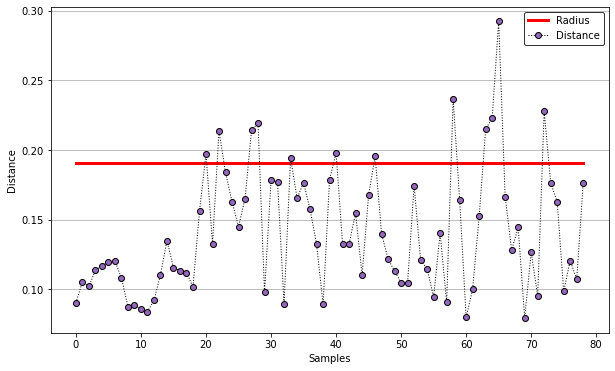

Wall time: 1h 16min 23s


In [15]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
    
    input_shape = (256,256, 3)
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(X_train, X_train,epochs=15,batch_size=16,shuffle=True,validation_data=(x_test, x_test))

    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)

    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-5), gamma=10**(-5), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    acc.append(svdd.accuracy)

Epoch 1/15
Epoch 1/15
15/15 [==============================] - 59s 4s/step - loss: 1.3774 - accuracy: 0.5367 - val_loss: 1.3487 - val_accuracy: 0.0079
Epoch 2/15
15/15 [==============================] - 59s 4s/step - loss: 1.3774 - accuracy: 0.5367 - val_loss: 1.3487 - val_accuracy: 0.0079
Epoch 2/15
15/15 [==============================] - 58s 4s/step - loss: 1.3385 - accuracy: 0.0111 - val_loss: 1.3318 - val_accuracy: 0.0119
Epoch 3/15
15/15 [==============================] - 58s 4s/step - loss: 1.3385 - accuracy: 0.0111 - val_loss: 1.3318 - val_accuracy: 0.0119
Epoch 3/15
15/15 [==============================] - 58s 4s/step - loss: 1.3320 - accuracy: 0.0127 - val_loss: 1.3319 - val_accuracy: 0.0117
Epoch 4/15
Epoch 4/15
15/15 [==============================] - 58s 4s/step - loss: 1.3316 - accuracy: 0.0087 - val_loss: 1.3296 - val_accuracy: 0.0091
Epoch 5/15
15/15 [==============================] - 58s 4s/step - loss: 1.3316 - accuracy: 0.0087 - val_loss: 1.3296 - val_accuracy: 0.009

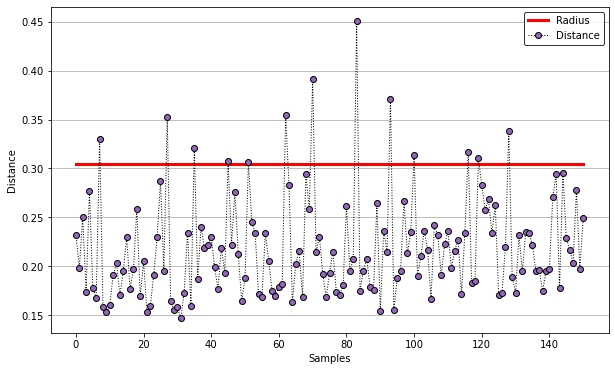

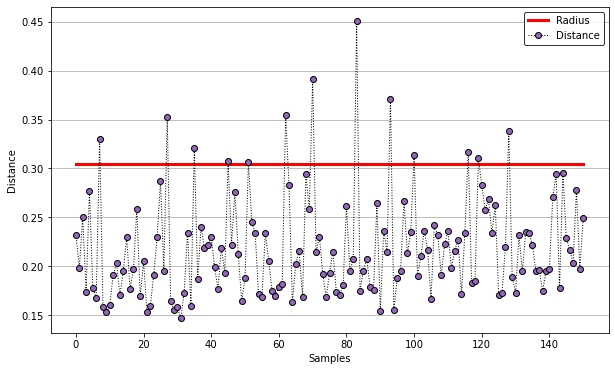

Epoch 1/15
Epoch 1/15
15/15 [==============================] - 61s 4s/step - loss: 1.4887 - accuracy: 0.9922 - val_loss: 1.3945 - val_accuracy: 0.9922
Epoch 2/15
Epoch 2/15
15/15 [==============================] - 63s 4s/step - loss: 1.3596 - accuracy: 0.4084 - val_loss: 1.3396 - val_accuracy: 0.0152
Epoch 3/15
Epoch 3/15
15/15 [==============================] - 60s 4s/step - loss: 1.3400 - accuracy: 0.0488 - val_loss: 1.3424 - val_accuracy: 0.1884
Epoch 4/15
15/15 [==============================] - 60s 4s/step - loss: 1.3400 - accuracy: 0.0488 - val_loss: 1.3424 - val_accuracy: 0.1884
Epoch 4/15
15/15 [==============================] - 60s 4s/step - loss: 1.3463 - accuracy: 0.2303 - val_loss: 1.3488 - val_accuracy: 0.2571
Epoch 5/15
15/15 [==============================] - 60s 4s/step - loss: 1.3463 - accuracy: 0.2303 - val_loss: 1.3488 - val_accuracy: 0.2571
Epoch 5/15
15/15 [==============================] - 60s 4s/step - loss: 1.3494 - accuracy: 0.2662 - val_loss: 1.3481 - val_accu

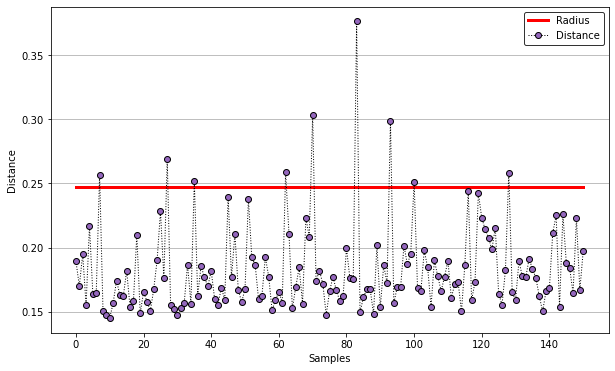

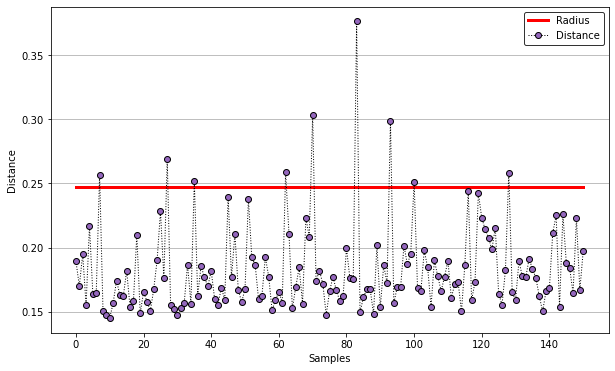

Epoch 1/15
Epoch 1/15
15/15 [==============================] - 63s 4s/step - loss: 1.3257 - accuracy: 0.2239 - val_loss: 1.3262 - val_accuracy: 0.0479
Epoch 2/15
15/15 [==============================] - 63s 4s/step - loss: 1.3257 - accuracy: 0.2239 - val_loss: 1.3262 - val_accuracy: 0.0479
Epoch 2/15
15/15 [==============================] - 61s 4s/step - loss: 1.3266 - accuracy: 0.0460 - val_loss: 1.3275 - val_accuracy: 0.0510
Epoch 3/15
Epoch 3/15
15/15 [==============================] - 61s 4s/step - loss: 1.3288 - accuracy: 0.0612 - val_loss: 1.3313 - val_accuracy: 0.0952
Epoch 4/15
Epoch 4/15
15/15 [==============================] - 60s 4s/step - loss: 1.3359 - accuracy: 0.2303 - val_loss: 1.3433 - val_accuracy: 0.5407
Epoch 5/15
15/15 [==============================] - 60s 4s/step - loss: 1.3359 - accuracy: 0.2303 - val_loss: 1.3433 - val_accuracy: 0.5407
Epoch 5/15
15/15 [==============================] - 62s 4s/step - loss: 1.3506 - accuracy: 0.6448 - val_loss: 1.3571 - val_accu

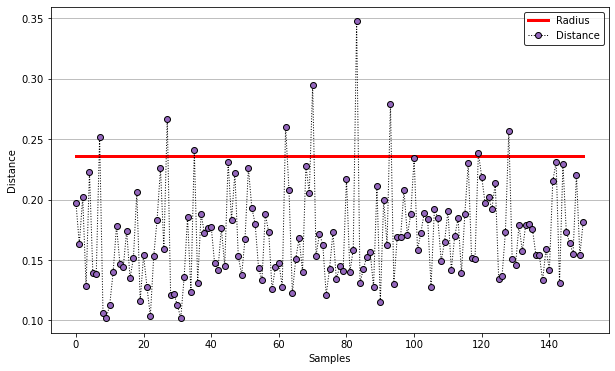

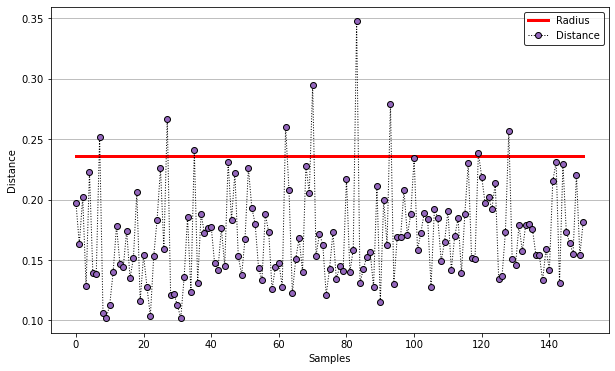

Epoch 1/15
Epoch 1/15
15/15 [==============================] - 61s 4s/step - loss: 1.3379 - accuracy: 0.0108 - val_loss: 1.3361 - val_accuracy: 0.0105
Epoch 2/15
15/15 [==============================] - 61s 4s/step - loss: 1.3379 - accuracy: 0.0108 - val_loss: 1.3361 - val_accuracy: 0.0105
Epoch 2/15
15/15 [==============================] - 60s 4s/step - loss: 1.3363 - accuracy: 0.0090 - val_loss: 1.3344 - val_accuracy: 0.0078
Epoch 3/15
Epoch 3/15
15/15 [==============================] - 60s 4s/step - loss: 1.3340 - accuracy: 0.0079 - val_loss: 1.3314 - val_accuracy: 0.0086
Epoch 4/15
Epoch 4/15
15/15 [==============================] - 61s 4s/step - loss: 1.3311 - accuracy: 0.0081 - val_loss: 1.3294 - val_accuracy: 0.0052
Epoch 5/15
15/15 [==============================] - 61s 4s/step - loss: 1.3311 - accuracy: 0.0081 - val_loss: 1.3294 - val_accuracy: 0.0052
Epoch 5/15
15/15 [==============================] - 59s 4s/step - loss: 1.3323 - accuracy: 0.0071 - val_loss: 1.3363 - val_accu

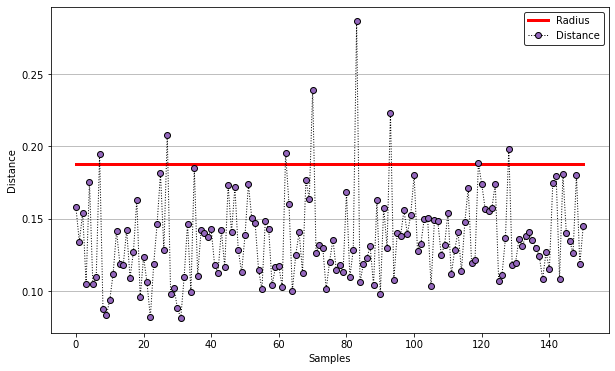

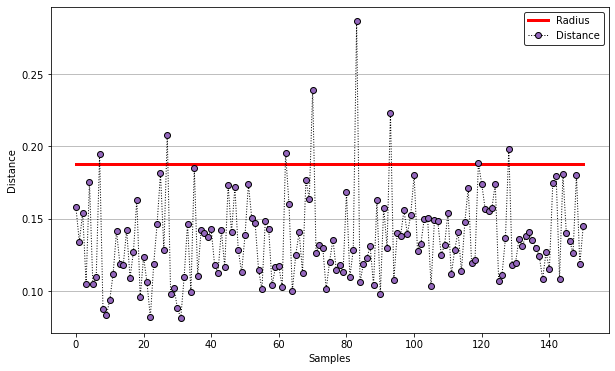

Epoch 1/15
Epoch 1/15
15/15 [==============================] - 60s 4s/step - loss: 1.5134 - accuracy: 1.5259e-05 - val_loss: 1.3841 - val_accuracy: 1.5259e-05
Epoch 2/15
15/15 [==============================] - 60s 4s/step - loss: 1.5134 - accuracy: 1.5259e-05 - val_loss: 1.3841 - val_accuracy: 1.5259e-05
Epoch 2/15
15/15 [==============================] - 58s 4s/step - loss: 1.3428 - accuracy: 0.0435 - val_loss: 1.3260 - val_accuracy: 0.3427
Epoch 3/15
15/15 [==============================] - 58s 4s/step - loss: 1.3428 - accuracy: 0.0435 - val_loss: 1.3260 - val_accuracy: 0.3427
Epoch 3/15
15/15 [==============================] - 58s 4s/step - loss: 1.3333 - accuracy: 0.8147 - val_loss: 1.3446 - val_accuracy: 0.7721
Epoch 4/15
15/15 [==============================] - 58s 4s/step - loss: 1.3333 - accuracy: 0.8147 - val_loss: 1.3446 - val_accuracy: 0.7721
Epoch 4/15
15/15 [==============================] - 58s 4s/step - loss: 1.3517 - accuracy: 0.7658 - val_loss: 1.3600 - val_accuracy: 

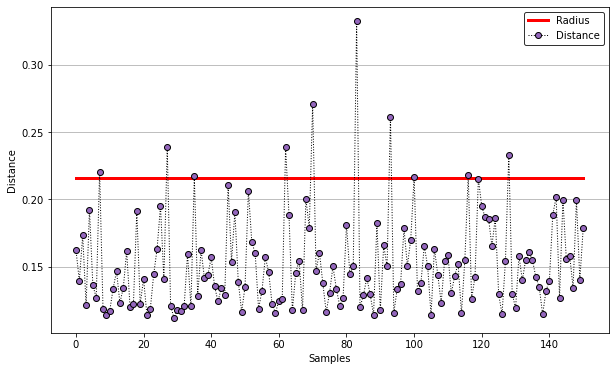

Wall time: 1h 15min 31s


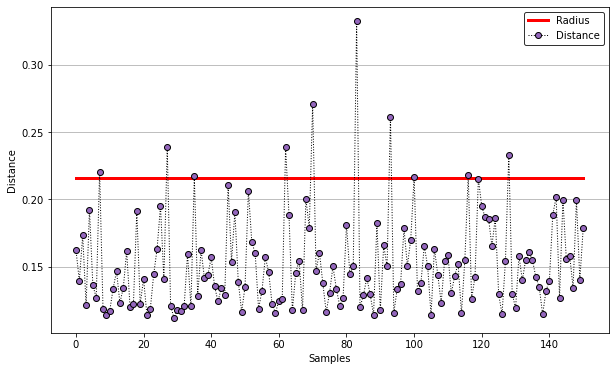

Wall time: 1h 15min 31s


In [16]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
    
    input_shape = (256,256, 3)
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(X_train, X_train,epochs=15,batch_size=16,shuffle=True,validation_data=(x_test, x_test))

    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)

    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-4), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    acc.append(svdd.accuracy)

In [20]:
acc=np.array(acc)
acc.reshape(15,5)

array([[0.89156627, 0.91566265, 0.89156627, 0.89156627, 0.89156627],
       [0.6       , 0.62142857, 0.58571429, 0.60714286, 0.61428571],
       [0.18181818, 0.18181818, 0.18939394, 0.18181818, 0.1969697 ],
       [0.27941176, 0.27941176, 0.27941176, 0.31617647, 0.27941176],
       [0.29487179, 0.26923077, 0.26923077, 0.28205128, 0.25641026],
       [0.55454545, 0.58181818, 0.58181818, 0.59090909, 0.58181818],
       [0.52419355, 0.52419355, 0.57258065, 0.53225806, 0.51612903],
       [0.66956522, 0.4173913 , 0.46086957, 0.4       , 0.67826087],
       [0.38323353, 0.38922156, 0.38922156, 0.4011976 , 0.4011976 ],
       [0.1       , 0.09375   , 0.0875    , 0.0875    , 0.0875    ],
       [0.57264957, 0.56410256, 0.4957265 , 0.54700855, 0.63247863],
       [0.78571429, 0.73809524, 0.80952381, 0.76190476, 0.83333333],
       [0.72      , 0.73      , 0.76      , 0.75      , 0.76      ],
       [0.39240506, 0.37974684, 0.39240506, 0.39240506, 0.39240506],
       [0.27152318, 0.24503311, 0.

array([[0.89156627, 0.91566265, 0.89156627, 0.89156627, 0.89156627],
       [0.6       , 0.62142857, 0.58571429, 0.60714286, 0.61428571],
       [0.18181818, 0.18181818, 0.18939394, 0.18181818, 0.1969697 ],
       [0.27941176, 0.27941176, 0.27941176, 0.31617647, 0.27941176],
       [0.29487179, 0.26923077, 0.26923077, 0.28205128, 0.25641026],
       [0.55454545, 0.58181818, 0.58181818, 0.59090909, 0.58181818],
       [0.52419355, 0.52419355, 0.57258065, 0.53225806, 0.51612903],
       [0.66956522, 0.4173913 , 0.46086957, 0.4       , 0.67826087],
       [0.38323353, 0.38922156, 0.38922156, 0.4011976 , 0.4011976 ],
       [0.1       , 0.09375   , 0.0875    , 0.0875    , 0.0875    ],
       [0.57264957, 0.56410256, 0.4957265 , 0.54700855, 0.63247863],
       [0.78571429, 0.73809524, 0.80952381, 0.76190476, 0.83333333],
       [0.72      , 0.73      , 0.76      , 0.75      , 0.76      ],
       [0.39240506, 0.37974684, 0.39240506, 0.39240506, 0.39240506],
       [0.27152318, 0.24503311, 0.